In [33]:
import torch
import os
import sys
sys.path.append('/home/ebutz/ESL2024/code/utils' )
import optuna
import torch.nn.functional as F
from torch_geometric.data import HeteroData
from torch_geometric.loader import LinkNeighborLoader
from torch_geometric.sampler import NegativeSampling
import torch_geometric.transforms as T
import pickle
import os
import sys
import torch
import torch.optim as optim
import torch_geometric
from torch_geometric.nn import ComplEx
from torch_geometric.data import Data
from torch_geometric.transforms import RandomLinkSplit
from torch_geometric.loader import DataLoader
import torch.nn.functional as F
from nxontology.imports import from_file
import wandb
from play_with_complex import *
from data_utils import *
from train_utils import *
from model_utils import *
import numpy as np
import pandas as pd
from tqdm import tqdm
tqdm.pandas()
from torchmetrics.retrieval import RetrievalMRR, RetrievalHitRate
import play_with_complex as pwc

# How to calculate loss ?
#  Choices are : 'usual', 'rand_linsim', linsim', 'gaussian_noise'usual'
labels_type = 'linsim'

# How many epochs between 2 time-consuming evaluations ?
eval_period = 5

# Wandb
xp_name = 'GNN Baseline VS LinSim VS Noise'
run_name = f'{labels_type} labels'
print(xp_name,':',run_name)

# Iric
iric_path = '/home/ebutz/ESL2024/data/full_iric/iric.csv'
mapped_iric_path  = '/home/ebutz/ESL2024/data/full_iric/altailed_mapped_iric.pickle'
altails_dict_path = '/home/ebutz/ESL2024/data/full_iric/altail_iric_DICT.pickle'
check_dicts = True

ontology_path = '/home/ebutz/ESL2024/data/go-basic.json.gz'

# Set device
os.environ["CUDA_VISIBLE_DEVICES"] = "0"
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
device = 'cpu'
print(f"Device: '{device}'")

run = wandb.init(project=xp_name, name = run_name)
config = wandb.config
config.labels_type = labels_type
config.val_ratio=0.1
config.homogeneous=False
config.scorelist_size=1000
config.split_ratio=0.8
config.val_ratio=0.1
config.test_ratio=0.1
config.num_neighbors=[70,55,13,89,85]
config.batch_size=1024
config.train_neg_sampling_ratio=224
config.epochs=18
config.disjoint_train_ratio=0.6
config.lr=0.0015308253347932983
config.stopper_metric= 'hit_at_10'
config.stopper_direction="maximize"
config.stopper_patience=5
config.stopper_frequency=1
config.stopper_relative_delta=0.05
config.gamma=1.3
config.alpha=0.42680473078813763
config.gnn_layer='ResGatedGraphConv'
config.dropout=0.1
config.norm='DiffGroupNorm'
config.aggregation = 'min'
config.hidden_channels=115
config.num_layers=3
config.attention_heads=4
config.homogeneous = False
config.labels = {'head' : 'genes', 'relation' : 'gene_ontology', 'tail' : 'go'}

print('Graph is homogeneous :',config.homogeneous)

data = load_iric_data('/home/ebutz/ESL2024/data/full_iric/iric.csv', featureless=False)
data  = T.ToUndirected(merge=True)(data) # Convert the graph to an undirected graph. Creates reverse edges for each edge.
data = T.RemoveDuplicatedEdges()(data) # Remove duplicated edges
print(data)
print('data look valid : ',data.validate())

train_data, val_data, test_data = split_data(data, config)
train_loader, val_loader, test_loader = build_dataloaders(train_data, val_data, test_data, config)

# # ------------- Loading ontology ------------- #

print("\nLoading ontology...")
nxo = from_file(ontology_path)
nxo.freeze()
pwc.nxo = nxo

df = pd.read_csv(iric_path, index_col=0, dtype=str)
df['source_node'] = df.index
df.columns = [x.lower() for x in df.columns]
go_map = get_nodelist(df, 'go')
go_to_idx = {node: i for i, node in enumerate(go_map)}
idx_to_go = {i: node for i, node in enumerate(go_map)}

# # ------------- Making global variables accessibles to pwc ------------- #

pwc.map_to_GO        = idx_to_go
pwc.mapped_alt_tails = None
pwc.device           = device

batchy = next(iter(train_loader))

Failed to detect the name of this notebook, you can set it manually with the WANDB_NOTEBOOK_NAME environment variable to enable code saving.


GNN Baseline VS LinSim VS Noise : linsim labels
Device: 'cpu'


wandb: Currently logged in as: butzelliot (esl2024). Use `wandb login --relogin` to force relogin


Graph is homogeneous : False


/home/ebutz/ESL2024/code/utils/train_utils.py:184: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_links['source_node'] = df_links.index


HeteroData(
  genes={ x=[72335, 29] },
  go={ x=[42979, 3] },
  po={ x=[1662, 2] },
  traito={ x=[1636, 1] },
  prosite_profiles={ x=[627, 1] },
  prosite_patterns={ x=[652, 1] },
  superfamily={ x=[957, 1] },
  panther={ x=[5971, 1] },
  prints={ x=[420, 1] },
  (genes, interacts_with, genes)={ edge_index=[2, 1120849] },
  (genes, gene_ontology, go)={ edge_index=[2, 169248] },
  (genes, trait_ontology, traito)={ edge_index=[2, 15080] },
  (genes, plant_ontology, po)={ edge_index=[2, 6125] },
  (genes, profile, prosite_profiles)={ edge_index=[2, 12239] },
  (genes, pattern, prosite_patterns)={ edge_index=[2, 6677] },
  (genes, family, superfamily)={ edge_index=[2, 20742] },
  (genes, panther_id, panther)={ edge_index=[2, 25319] },
  (genes, prints_id, prints)={ edge_index=[2, 4365] },
  (go, is_a, go)={ edge_index=[2, 136436] },
  (po, is_a, po)={ edge_index=[2, 3548] },
  (traito, is_a, traito)={ edge_index=[2, 3770] },
  (go, rev_gene_ontology, genes)={ edge_index=[2, 169248] },
  (t

In [36]:
print(batchy)

HeteroData(
  genes={
    x=[25017, 29],
    n_id=[25017],
    num_sampled_nodes=[6],
    src_index=[1024],
  },
  go={
    x=[42973, 3],
    n_id=[42973],
    num_sampled_nodes=[6],
    dst_pos_index=[1024],
    dst_neg_index=[1024, 224],
  },
  po={
    x=[1483, 2],
    n_id=[1483],
    num_sampled_nodes=[6],
  },
  traito={
    x=[1510, 1],
    n_id=[1510],
    num_sampled_nodes=[6],
  },
  prosite_profiles={
    x=[622, 1],
    n_id=[622],
    num_sampled_nodes=[6],
  },
  prosite_patterns={
    x=[652, 1],
    n_id=[652],
    num_sampled_nodes=[6],
  },
  superfamily={
    x=[949, 1],
    n_id=[949],
    num_sampled_nodes=[6],
  },
  panther={
    x=[5515, 1],
    n_id=[5515],
    num_sampled_nodes=[6],
  },
  prints={
    x=[420, 1],
    n_id=[420],
    num_sampled_nodes=[6],
  },
  (genes, interacts_with, genes)={
    edge_index=[2, 488080],
    e_id=[488080],
    num_sampled_edges=[5],
  },
  (genes, gene_ontology, go)={
    edge_index=[2, 32286],
    edge_label=[81240],
    e_

In [51]:
batchy['go']['dst_pos_index']

tensor([29667, 11256, 13816,  ..., 41443, 29514, 27923])

In [52]:
batchy['go']['dst_neg_index']

tensor([[26571, 21609,  8660,  ..., 39293, 21777,  7075],
        [23272,  5983, 24770,  ..., 31439, 32191, 33596],
        [24311, 25341, 41184,  ...,  5227, 10957, 18279],
        ...,
        [39256, 37557,  1785,  ..., 15280, 15529, 24096],
        [10927, 25454, 11546,  ..., 10155, 10686,  1824],
        [13106,  3202, 33082,  ..., 19620, 12795,  3273]])

In [53]:
gnn_layers = get_gnn_layers(config)
norm_layers = get_norm_layers(config, len(data.node_types))

model = Model(config, data, norm_layers, gnn_layers).to(device)

In [54]:
print(model(batchy, config).tolist())

tensor([0.0698, 0.1367, 0.1581,  ..., 0.0433, 0.0449, 0.0432],
       grad_fn=<ViewBackward0>)

In [55]:
model(batchy, config)

tensor([0.0230, 0.4575, 0.1835,  ..., 0.0324, 0.0373, 0.0528],
       grad_fn=<ViewBackward0>)

In [56]:
model(batchy, config)

tensor([0.1855, 0.4272, 0.1997,  ..., 0.0275, 0.0375, 0.0573],
       grad_fn=<ViewBackward0>)

In [57]:
model(batchy, config)

tensor([0.1822, 0.6267, 0.1617,  ..., 0.0434, 0.0375, 0.0416],
       grad_fn=<ViewBackward0>)

In [58]:
model(batchy, config)


tensor([0.1226, 0.2149, 0.1951,  ..., 0.0273, 0.0330, 0.0281],
       grad_fn=<ViewBackward0>)

In [43]:
batchy.neg_edge_index

AttributeError: 'HeteroData' has no attribute 'neg_edge_index'

In [3]:
df = pd.read_csv(iric_path, index_col=0, dtype=str)
df['source_node'] = df.index
df.columns = [x.lower() for x in df.columns]
go_map = get_nodelist(df, 'go')
go_to_idx = {node: i for i, node in enumerate(go_map)}
idx_to_go = {i: node for i, node in enumerate(go_map)}

# # ------------- Making global variables accessibles to pwc ------------- #

pwc.map_to_GO        = idx_to_go
pwc.mapped_alt_tails = None
pwc.device           = device



In [4]:
print(idx_to_go)

{0: 'GO:0071943', 1: 'GO:1903769', 2: 'GO:0008083', 3: 'GO:1900294', 4: 'GO:0090190', 5: 'GO:0015030', 6: 'GO:0046107', 7: 'GO:0061139', 8: 'GO:0070715', 9: 'GO:0099583', 10: 'GO:0000785', 11: 'GO:1990616', 12: 'GO:0042327', 13: 'GO:0051121', 14: 'GO:0033149', 15: 'GO:0070515', 16: 'GO:1903340', 17: 'GO:1902087', 18: 'GO:1990808', 19: 'GO:1990891', 20: 'GO:0002799', 21: 'GO:0017183', 22: 'GO:1903378', 23: 'GO:0004420', 24: 'GO:0061710', 25: 'GO:0102754', 26: 'GO:0052032', 27: 'GO:0050843', 28: 'GO:0031039', 29: 'GO:1900805', 30: 'GO:0014720', 31: 'GO:0033118', 32: 'GO:0062243', 33: 'GO:0035530', 34: 'GO:1900790', 35: 'GO:0061755', 36: 'GO:1905090', 37: 'GO:0005452', 38: 'GO:0033503', 39: 'GO:0120204', 40: 'GO:0002432', 41: 'GO:1900605', 42: 'GO:0035769', 43: 'GO:0003025', 44: 'GO:0140590', 45: 'GO:0061716', 46: 'GO:0018220', 47: 'GO:0110019', 48: 'GO:0034486', 49: 'GO:0030332', 50: 'GO:0050308', 51: 'GO:0036334', 52: 'GO:0060106', 53: 'GO:0045089', 54: 'GO:0048361', 55: 'GO:1902856', 5

In [31]:
import pandas as pd
import swifter
import psutil


a = list(range(999999))
df = pd.DataFrame(a)
df.columns = ["in"]
num_cpus = psutil.cpu_count(logical=True)
num_partitions = num_cpus // 2
def some_function(x):
    return x + 3

false_tails = batchy[config.labels['tail']].dst_neg_index.view(-1)
true_tails = batchy['go']['dst_pos_index']
true_tails = torch.repeat_interleave(true_tails,int(false_tails.size()[0]/true_tails.size()[0]))

/home/ebutz/miniconda3/envs/pyg2/lib/python3.11/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


NameError: name 'batchy' is not defined

In [22]:
import pandas as pd
import torch

In [28]:
df = pd.DataFrame({'col1': [{1}, {2}],
                   'col2': [{0.5}, {0.75}]},
                  index=['row1', 'row2'])

display(df)

col1    col2
row1  {1}   {0.5}
row2  {2}  {0.75}

In [27]:
torch.tensor(list(df['col2'][1]))

/tmp/ipykernel_15403/4169408509.py:1: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  torch.tensor(list(df['col2'][1]))


tensor([0.7500])

In [29]:
d = df.set_index('col1')['col2'].to_dict()

TypeError: unhashable type: 'set'

In [17]:
k = list(d.keys())
print(type(k[0]))

<class 'int'>


In [ ]:
def make_

In [6]:
map_to_GO = idx_to_go

In [7]:
pip install pandarallel

Note: you may need to restart the kernel to use updated packages.


In [9]:
print(true_tails, false_tails)



tensor([ 6426,  6426,  6426,  ..., 36101, 36101, 36101]) tensor([41504, 24424,  6928,  ...,  9925,   484,  1865])


In [ ]:
%%timeit
Accelerated_lin_sims_for_batch(term1=true_tails, term2=false_tails, num_core=10)

11.8 s ± 331 ms per loop (mean ± std. dev. of 7 runs, 1 loop each)


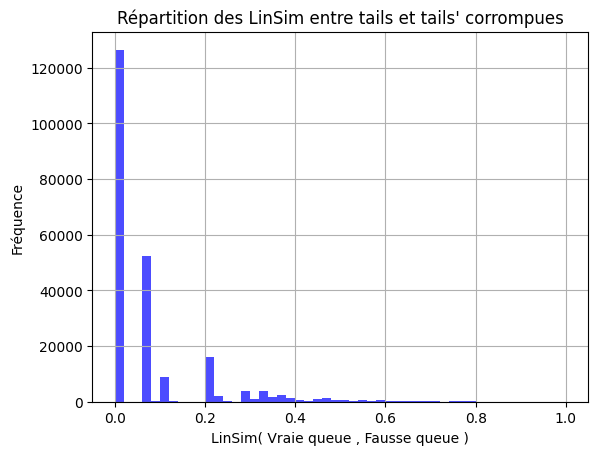

In [18]:
# %%timeit
ls = lin_sims_for_batch(term1=true_tails, term2=false_tails)
# import matplotlib.pyplot as plt
# import numpy as np

tensor_array = np.array(ls)

# Créer un histogramme
plt.hist(tensor_array.flatten(), bins=50, color='blue', alpha=0.7)
plt.xlabel('LinSim( Vraie queue , Fausse queue )')
plt.ylabel('Fréquence')
plt.title('Répartition des LinSim entre tails et tails\' corrompues')
plt.grid(True)
plt.show()

In [22]:
pandarallel.initialize(progress_bar=True)

# df.apply(func)
df.parallel_apply(func)

AttributeError: module 'pandarallel' has no attribute 'initialize'

: 

In [ ]:
# %%timeit
Accelerated_lin_sims_for_batch(term1=true_tails, term2=false_tails, num_core=10)

Dask Apply:  36%|███▋      | 4/11 [01:43<03:01, 25.97s/it]Traceback (most recent call last):
  File "/home/ebutz/miniconda3/envs/pyg2/lib/python3.11/multiprocessing/process.py", line 314, in _bootstrap
    self.run()
  File "/home/ebutz/miniconda3/envs/pyg2/lib/python3.11/multiprocessing/process.py", line 108, in run
    self._target(*self._args, **self._kwargs)
  File "/home/ebutz/miniconda3/envs/pyg2/lib/python3.11/concurrent/futures/process.py", line 249, in _process_worker
    call_item = call_queue.get(block=True)
                ^^^^^^^^^^^^^^^^^^^^^^^^^^
  File "/home/ebutz/miniconda3/envs/pyg2/lib/python3.11/multiprocessing/queues.py", line 103, in get
    res = self._recv_bytes()
          ^^^^^^^^^^^^^^^^^^
  File "/home/ebutz/miniconda3/envs/pyg2/lib/python3.11/multiprocessing/connection.py", line 216, in recv_bytes
    buf = self._recv_bytes(maxlength)
          ^^^^^^^^^^^^^^^^^^^^^^^^^^^
  File "/home/ebutz/miniconda3/envs/pyg2/lib/python3.11/multiprocessing/connection.py

KeyboardInterrupt: 

In [ ]:
df['out'] = df['in'].apply(some_function)

In [ ]:
df['out'] = df['in'].swifter.set_npartitions(num_partitions).apply(some_function)


In [ ]:


# Calculez le nombre de partitions à utiliser (la moitié des CPU disponibles)

def some_function(data):
    return data * 10

# Appliquer la fonction en utilisant la moitié des partitions


In [ ]:
print("\nImports...")
import sys

import play_with_complex
from utils.train_utils import *
from model_utils import *
from utils.ogb_utils import *
import play_with_complex as pwc

import numpy as np
import pandas as pd
from tqdm import tqdm
tqdm.pandas()

import pickle
import os
import sys


import torch
import torch.optim as optim
import torch_geometric
from torch_geometric.nn import ComplEx
from torch_geometric.data import Data
from torch_geometric.transforms import RandomLinkSplit
from torch_geometric.loader import DataLoader
import torch.nn.functional as F

from nxontology.imports import from_file


Imports...


ModuleNotFoundError: No module named 'utils'

In [ ]:
# ------------- Paths ------------- #

# Iric
mapped_iric_path  = '/home/ebutz/ESL2024/data/Os_to_GO_iric/altailed_Os_to_GO_iric.pickle'
altails_dict_path = '/home/ebutz/ESL2024/data/Os_to_GO_iric/DICT_altailed_Os_to_GO_iric.pickle'

# Model to train :
hidden_channels = 176
batch_size      = 4096
epochs          = 200
eval_period     = 2
lin_factor      = 1

use_wandb  = True

params_save_name = f"PARAMS_ComplEx_6_times_{hidden_channels}_HC_{epochs}_epochs_{batch_size}_BS_on_full_iric"
model_parameters_path = "/home/ebutz/ESL2024/data/mapping_datasets_and_model_for_genes_to_phenotypes_iric/"+params_save_name

# Ontology
ontology_path = "/home/ebutz/ESL2024/data/go-basic.json.gz"
check_dicts = False

# ------------- Cuda ------------- #

print("\nCuda check...")

device = 'cpu'

# ------------- Loading datas ------------- #

print("\nLoading iric...")
mapped_iric = pd.read_pickle(mapped_iric_path)
print(mapped_iric.head())
print('mapped_alt_tails type :', type(mapped_iric.iloc[0]['mapped_alt_tails']))

GO_to_map = mapped_iric.set_index('object')['mapped_object'].to_dict()
map_to_GO = {value: key for key, value in GO_to_map.items()}

if check_dicts:
    looks_ok: bool = True
    for i in tqdm(range(len(list(mapped_iric['object']))), desc = "Checking GO to MAP dict"):
        if GO_to_map[mapped_iric['object'][i]]!=mapped_iric['mapped_object'][i] :
            looks_ok = False
    print('GO - Mapping dicts looks ok :', looks_ok)

with open(altails_dict_path, 'rb') as handle:
    mapped_alt_tails = pickle.load(handle)
print("Alternative tails dict (first key-value pair):", list(mapped_alt_tails.items())[0])

# # ------------- Making datasets ------------- #

print("\nMaking datasets...")
# Edges index :
heads = list(mapped_iric['mapped_subject'])
tails = list(mapped_iric['mapped_object'])
edge_index = torch.tensor([heads,tails], dtype=torch.long)
# edges attributes :
edge_attributes = torch.tensor(mapped_iric['mapped_predicate'])


iric_pyg = Data(
                num_nodes = len(set(mapped_iric['object']).union(set(mapped_iric['subject']))),
                edge_index = edge_index,
                edge_attr = edge_attributes
                )

print(iric_pyg)

print("\nDataset looks valid :",iric_pyg.validate(raise_on_error=True))

transform = RandomLinkSplit(
                            num_val = 0.1,
                            num_test = 0.1,
                            is_undirected = False,
                            add_negative_train_samples = False,
                            )

train_set, val_set, test_set = transform(iric_pyg)
print('Dataset splits look valid (train, val, test):',train_set.validate(raise_on_error = True),
                                                      val_set.validate(raise_on_error   = True),
                                                      test_set.validate(raise_on_error  = True))

# ------------- Loading ontology ------------- #

print("\nLoading ontology...")
nxo = from_file(ontology_path)
nxo.freeze()

# ------------- Making global variables accessibles to pwc ------------- #

pwc.map_to_GO        = map_to_GO
pwc.nxo              = nxo
pwc.mapped_alt_tails = mapped_alt_tails
pwc.device           = device


print('All done.')



Cuda check...

Loading iric...
            subject      predicate      object  mapped_subject  \
0  OsNippo01g010050  gene ontology  GO:0031267           29269   
1  OsNippo01g010050  gene ontology  GO:0006886           29269   
2  OsNippo01g010050  gene ontology  GO:0005622           29269   
3  OsNippo01g010050  gene ontology  GO:0005623           29269   
4  OsNippo01g010050  gene ontology  GO:0090630           29269   

   mapped_predicate  mapped_object                            mapped_alt_tails  
0                 0           8105  [20179, 25142, 11107, 11397, 25543, 24490]  
1                 0          20179   [8105, 25142, 11107, 11397, 25543, 24490]  
2                 0          25142   [8105, 20179, 11107, 11397, 25543, 24490]  
3                 0          11107   [8105, 20179, 25142, 11397, 25543, 24490]  
4                 0          11397   [8105, 20179, 25142, 11107, 25543, 24490]  
mapped_alt_tails type : <class 'numpy.ndarray'>
Alternative tails dict (first key-val

In [ ]:
pwc.map_to_GO        = map_to_GO
pwc.nxo              = nxo
pwc.mapped_alt_tails = mapped_alt_tails
pwc.device           = device


In [ ]:
xp1 = {
    'model_name': 'ComplEx_L_labels',
    'hidden_channels_list': [1000],
    'epochs': 1000,
    'eval_period': 5,
    'device': 'cpu',
    'use_wandb': True,
    'xp_name': '1000 HC !',
    'train_set': train_set,
    'test_set': test_set,
    'file_import': pwc
}

xp2 =  {
    'model_name': 'tail_only_ComplEx',
    'hidden_channels_list': [1000],
    'epochs': 1000,
    'eval_period': 5,
    'device': 'cpu',
    'use_wandb': True,
    'xp_name': '1000 HC !',
    'train_set': train_set,
    'test_set': test_set,
    'file_import': pwc
}

xp3 =  {
    'model_name': 'ComplEx_LGN_labels',
    'hidden_channels_list': [1000],
    'epochs': 1000,
    'eval_period': 5,
    'device': 'cpu',
    'use_wandb': True,
    'xp_name': '1000 HC !',
    'train_set': train_set,
    'test_set': test_set,
    'file_import': pwc
}

xp4 =  {
    'model_name': 'ComplEx_UGN_labels',
    'hidden_channels_list': [1000],
    'epochs': 1000,
    'eval_period': 5,
    'device': 'cpu',
    'use_wandb': True,
    'xp_name': '1000 HC !',
    'train_set': train_set,
    'test_set': test_set,
    'file_import': pwc
}

In [ ]:
pwc.train_model(model_name='tail_only_ComplEx', hidden_channels_list=[1000], epochs=150, eval_period=10,
                device='cpu', use_wandb=True, xp_name='1000 HC !',
                train_set=train_set, test_set=test_set,
                file_import = pwc)

pwc.train_model(model_name='ComplEx_LGN_labels', hidden_channels_list=[1000], epochs=150, eval_period=5,
                device='cpu', use_wandb=True, xp_name='1000 HC !',
                train_set=train_set, test_set=test_set,
                file_import = pwc)

pwc.train_model(model_name='ComplEx_GN_U_labels', hidden_channels_list=[1000], epochs=150, eval_period=5,
                device='cpu', use_wandb=True, xp_name='1000 HC !',
                train_set=train_set, test_set=test_set,
                file_import = pwc)

pwc.train_model(model_name='ComplEx_L_labels', hidden_channels_list=[1000], epochs=150, eval_period=5,
                device='cpu', use_wandb=True, xp_name='1000 HC !',
                train_set=train_set, test_set=test_set,
                file_import = pwc)



pwc.train_model(model_name='ComplEx_UGN_labels', hidden_channels_list=[1000], epochs=150, eval_period=5,
                device='cpu', use_wandb=True, xp_name='1000 HC !',
                train_set=train_set, test_set=test_set,
                file_import = pwc)

Train and test.
Model type : <class 'play_with_complex.tail_only_ComplEx'>
Hidden channels : 6 * 1000
Epochs : 150
Eval period : 10
Use WanDB : True
Device : cpu Could reach GPU : False
Evaluation each 10 epochs.


Epoch: 000/150
Loss on train set : 12.4068
Loss on test set  : 11.7575
Eval...
batch : (tensor([21208,  8318,  4038,  ..., 26384, 29008, 20678]), tensor([0, 0, 0,  ..., 0, 0, 0]), tensor([17386, 30104,  9275,  ..., 17386, 27984, 23191]))


Calculating mean rank; MRR, Hit@10 among 1000 triples: 100%|██████████| 1000/1000 [00:02<00:00, 403.97it/s]


Epoch: 000/150, Val Mean Rank: 476.96 Val MRR: 0.0091, Val Hits@10: 0.0140
Epoch: 001/150
Loss on train set : 11.4674
Loss on test set  : 11.0271
Epoch: 002/150
Loss on train set : 10.6892
Loss on test set  : 10.2093
Epoch: 003/150
Loss on train set : 9.7626
Loss on test set  : 9.3882
Epoch: 004/150
Loss on train set : 8.8603
Loss on test set  : 8.5593
Epoch: 005/150
Loss on train set : 7.9491
Loss on test set  : 7.7414
Epoch: 006/150
Loss on train set : 7.1354
Loss on test set  : 6.9926
Epoch: 007/150
Loss on train set : 6.4011
Loss on test set  : 6.4237
Epoch: 008/150
Loss on train set : 5.8372
Loss on test set  : 5.8994
Epoch: 009/150
Loss on train set : 5.2792
Loss on test set  : 5.4756
Epoch: 010/150
Loss on train set : 4.9105
Loss on test set  : 5.1515
Eval...
batch : (tensor([ 3477, 13987, 10190,  ...,  6127,  9605, 11326]), tensor([0, 0, 0,  ..., 0, 0, 0]), tensor([22679,    63, 19686,  ..., 26336, 29474,  9409]))


Calculating mean rank; MRR, Hit@10 among 1000 triples: 100%|██████████| 1000/1000 [00:04<00:00, 226.69it/s]


Epoch: 010/150, Val Mean Rank: 497.35 Val MRR: 0.0075, Val Hits@10: 0.0090
Epoch: 011/150
Loss on train set : 4.5584
Loss on test set  : 4.8997
Epoch: 012/150
Loss on train set : 4.3168
Loss on test set  : 4.6811
Epoch: 013/150
Loss on train set : 4.1170
Loss on test set  : 4.4534
Epoch: 014/150
Loss on train set : 3.9014
Loss on test set  : 4.2707
Epoch: 015/150
Loss on train set : 3.7862
Loss on test set  : 4.1582
Epoch: 016/150
Loss on train set : 3.6208
Loss on test set  : 3.9820
Epoch: 017/150
Loss on train set : 3.4811
Loss on test set  : 3.8370
Epoch: 018/150
Loss on train set : 3.3658
Loss on test set  : 3.6999
Epoch: 019/150
Loss on train set : 3.2429
Loss on test set  : 3.5780
Epoch: 020/150
Loss on train set : 3.1347
Loss on test set  : 3.4619
Eval...
batch : (tensor([ 3295, 24497, 24389,  ...,  9634, 21597, 12123]), tensor([0, 0, 0,  ..., 0, 0, 0]), tensor([23017, 30025, 11870,  ...,  3993, 13425, 10322]))


Calculating mean rank; MRR, Hit@10 among 1000 triples: 100%|██████████| 1000/1000 [00:02<00:00, 348.88it/s]


Epoch: 020/150, Val Mean Rank: 502.69 Val MRR: 0.0104, Val Hits@10: 0.0160
Epoch: 021/150
Loss on train set : 3.0090
Loss on test set  : 3.3634
Epoch: 022/150
Loss on train set : 2.9156
Loss on test set  : 3.2220
Epoch: 023/150
Loss on train set : 2.7883
Loss on test set  : 3.1068
Epoch: 024/150
Loss on train set : 2.6540
Loss on test set  : 2.9984
Epoch: 025/150
Loss on train set : 2.5778
Loss on test set  : 2.8693
Epoch: 026/150
Loss on train set : 2.4882
Loss on test set  : 2.7937
Epoch: 027/150
Loss on train set : 2.3760
Loss on test set  : 2.6846
Epoch: 028/150
Loss on train set : 2.2651
Loss on test set  : 2.5738
Epoch: 029/150
Loss on train set : 2.1768
Loss on test set  : 2.4780
Epoch: 030/150
Loss on train set : 2.1020
Loss on test set  : 2.3840
Eval...
batch : (tensor([12540,  4968, 16111,  ...,  8879, 20096, 19696]), tensor([0, 0, 0,  ..., 0, 0, 0]), tensor([29823, 19581, 13738,  ..., 11938, 10217,  8320]))


Calculating mean rank; MRR, Hit@10 among 1000 triples: 100%|██████████| 1000/1000 [00:02<00:00, 417.51it/s]


Epoch: 030/150, Val Mean Rank: 484.55 Val MRR: 0.0111, Val Hits@10: 0.0160
Epoch: 031/150
Loss on train set : 1.9822
Loss on test set  : 2.2909
Epoch: 032/150
Loss on train set : 1.9027
Loss on test set  : 2.2081
Epoch: 033/150
Loss on train set : 1.7989
Loss on test set  : 2.1057
Epoch: 034/150
Loss on train set : 1.7278
Loss on test set  : 2.0163
Epoch: 035/150
Loss on train set : 1.6454
Loss on test set  : 1.9387
Epoch: 036/150
Loss on train set : 1.5652
Loss on test set  : 1.8480
Epoch: 037/150
Loss on train set : 1.4759
Loss on test set  : 1.7738
Epoch: 038/150
Loss on train set : 1.4205
Loss on test set  : 1.7160
Epoch: 039/150
Loss on train set : 1.3348
Loss on test set  : 1.6483
Epoch: 040/150
Loss on train set : 1.2711
Loss on test set  : 1.5753
Eval...
batch : (tensor([29482, 15361, 26915,  ..., 18537, 20192, 21520]), tensor([0, 0, 0,  ..., 0, 0, 0]), tensor([27984, 16445, 21223,  ..., 24473, 24960, 11843]))


Calculating mean rank; MRR, Hit@10 among 1000 triples: 100%|██████████| 1000/1000 [00:03<00:00, 315.50it/s]


Epoch: 040/150, Val Mean Rank: 464.68 Val MRR: 0.0126, Val Hits@10: 0.0240
Epoch: 041/150
Loss on train set : 1.2064
Loss on test set  : 1.5039
Epoch: 042/150
Loss on train set : 1.1521
Loss on test set  : 1.4434
Epoch: 043/150
Loss on train set : 1.0731
Loss on test set  : 1.3958
Epoch: 044/150
Loss on train set : 1.0194
Loss on test set  : 1.3374
Epoch: 045/150
Loss on train set : 0.9560
Loss on test set  : 1.2848
Epoch: 046/150
Loss on train set : 0.9151
Loss on test set  : 1.2474
Epoch: 047/150
Loss on train set : 0.8535
Loss on test set  : 1.1938
Epoch: 048/150
Loss on train set : 0.8037
Loss on test set  : 1.1618
Epoch: 049/150
Loss on train set : 0.7682
Loss on test set  : 1.1205
Epoch: 050/150
Loss on train set : 0.7315
Loss on test set  : 1.0873
Eval...
batch : (tensor([ 2682, 12434, 11962,  ...,  4054,   529, 18337]), tensor([0, 0, 0,  ..., 0, 0, 0]), tensor([15816, 13425, 15816,  ...,  7695, 15816, 26336]))


Calculating mean rank; MRR, Hit@10 among 1000 triples: 100%|██████████| 1000/1000 [00:02<00:00, 410.90it/s]


Epoch: 050/150, Val Mean Rank: 403.73 Val MRR: 0.0167, Val Hits@10: 0.0330
Epoch: 051/150
Loss on train set : 0.6899
Loss on test set  : 1.0492
Epoch: 052/150
Loss on train set : 0.6494
Loss on test set  : 1.0143
Epoch: 053/150
Loss on train set : 0.6141
Loss on test set  : 0.9906
Epoch: 054/150
Loss on train set : 0.5829
Loss on test set  : 0.9616
Epoch: 055/150
Loss on train set : 0.5533
Loss on test set  : 0.9331
Epoch: 056/150
Loss on train set : 0.5278
Loss on test set  : 0.9081
Epoch: 057/150
Loss on train set : 0.4998
Loss on test set  : 0.8900
Epoch: 058/150
Loss on train set : 0.4725
Loss on test set  : 0.8698
Epoch: 059/150
Loss on train set : 0.4561
Loss on test set  : 0.8527
Epoch: 060/150
Loss on train set : 0.4325
Loss on test set  : 0.8357
Eval...
batch : (tensor([ 6493, 27021, 24155,  ..., 11666, 19036, 28297]), tensor([0, 0, 0,  ..., 0, 0, 0]), tensor([11938, 17406, 13738,  ..., 18800, 10561, 14850]))


Calculating mean rank; MRR, Hit@10 among 1000 triples: 100%|██████████| 1000/1000 [00:02<00:00, 368.28it/s]


Epoch: 060/150, Val Mean Rank: 365.46 Val MRR: 0.0263, Val Hits@10: 0.0480
Epoch: 061/150
Loss on train set : 0.4169
Loss on test set  : 0.8199
Epoch: 062/150
Loss on train set : 0.3929
Loss on test set  : 0.8001
Epoch: 063/150
Loss on train set : 0.3741
Loss on test set  : 0.7921
Epoch: 064/150
Loss on train set : 0.3598
Loss on test set  : 0.7803
Epoch: 065/150
Loss on train set : 0.3435
Loss on test set  : 0.7684
Epoch: 066/150
Loss on train set : 0.3312
Loss on test set  : 0.7631
Epoch: 067/150
Loss on train set : 0.3137
Loss on test set  : 0.7528
Epoch: 068/150
Loss on train set : 0.3083
Loss on test set  : 0.7410
Epoch: 069/150
Loss on train set : 0.2962
Loss on test set  : 0.7317
Epoch: 070/150
Loss on train set : 0.2789
Loss on test set  : 0.7260
Eval...
batch : (tensor([18589,  2129, 25640,  ..., 26894,  6362, 20135]), tensor([0, 0, 0,  ..., 0, 0, 0]), tensor([27984, 21728, 12459,  ...,  3564, 28205, 12039]))


Calculating mean rank; MRR, Hit@10 among 1000 triples: 100%|██████████| 1000/1000 [00:02<00:00, 341.16it/s]


Epoch: 070/150, Val Mean Rank: 293.10 Val MRR: 0.0416, Val Hits@10: 0.0850
Epoch: 071/150
Loss on train set : 0.2728
Loss on test set  : 0.7223
Epoch: 072/150
Loss on train set : 0.2619
Loss on test set  : 0.7112
Epoch: 073/150
Loss on train set : 0.2600
Loss on test set  : 0.7098
Epoch: 074/150
Loss on train set : 0.2478
Loss on test set  : 0.7048
Epoch: 075/150
Loss on train set : 0.2404
Loss on test set  : 0.6948
Epoch: 076/150
Loss on train set : 0.2333
Loss on test set  : 0.6945
Epoch: 077/150
Loss on train set : 0.2254
Loss on test set  : 0.6891
Epoch: 078/150
Loss on train set : 0.2220
Loss on test set  : 0.6832
Epoch: 079/150
Loss on train set : 0.2168
Loss on test set  : 0.6839
Epoch: 080/150
Loss on train set : 0.2132
Loss on test set  : 0.6796
Eval...
batch : (tensor([16422,  4544, 23114,  ..., 20075, 15912, 20309]), tensor([0, 0, 0,  ..., 0, 0, 0]), tensor([27618, 21358, 20097,  ..., 28433, 17406, 13343]))


Calculating mean rank; MRR, Hit@10 among 1000 triples: 100%|██████████| 1000/1000 [00:03<00:00, 316.74it/s]


Epoch: 080/150, Val Mean Rank: 270.92 Val MRR: 0.0485, Val Hits@10: 0.0980
Epoch: 081/150
Loss on train set : 0.2038
Loss on test set  : 0.6753
Epoch: 082/150
Loss on train set : 0.1990
Loss on test set  : 0.6740
Epoch: 083/150
Loss on train set : 0.1969
Loss on test set  : 0.6711
Epoch: 084/150
Loss on train set : 0.1937
Loss on test set  : 0.6673
Epoch: 085/150
Loss on train set : 0.1889
Loss on test set  : 0.6655
Epoch: 086/150
Loss on train set : 0.1830
Loss on test set  : 0.6646
Epoch: 087/150
Loss on train set : 0.1794
Loss on test set  : 0.6628
Epoch: 088/150
Loss on train set : 0.1803
Loss on test set  : 0.6597
Epoch: 089/150
Loss on train set : 0.1745
Loss on test set  : 0.6590
Epoch: 090/150
Loss on train set : 0.1717
Loss on test set  : 0.6549
Eval...
batch : (tensor([ 5315, 11448,  9408,  ...,  8243, 22968, 16170]), tensor([0, 0, 0,  ..., 0, 0, 0]), tensor([21223,  5278, 26336,  ..., 23017,  5077, 24094]))


Calculating mean rank; MRR, Hit@10 among 1000 triples: 100%|██████████| 1000/1000 [00:02<00:00, 374.27it/s]


Epoch: 090/150, Val Mean Rank: 238.30 Val MRR: 0.0647, Val Hits@10: 0.1370
Epoch: 091/150
Loss on train set : 0.1678
Loss on test set  : 0.6538
Epoch: 092/150
Loss on train set : 0.1647
Loss on test set  : 0.6524
Epoch: 093/150
Loss on train set : 0.1631
Loss on test set  : 0.6505
Epoch: 094/150
Loss on train set : 0.1602
Loss on test set  : 0.6512
Epoch: 095/150
Loss on train set : 0.1628
Loss on test set  : 0.6509
Epoch: 096/150
Loss on train set : 0.1592
Loss on test set  : 0.6480
Epoch: 097/150
Loss on train set : 0.1560
Loss on test set  : 0.6469
Epoch: 098/150
Loss on train set : 0.1545
Loss on test set  : 0.6453
Epoch: 099/150
Loss on train set : 0.1498
Loss on test set  : 0.6407
Epoch: 100/150
Loss on train set : 0.1489
Loss on test set  : 0.6436
Eval...
batch : (tensor([26304, 13692, 23480,  ..., 16457, 21637, 25043]), tensor([0, 0, 0,  ..., 0, 0, 0]), tensor([ 7066, 21223, 24599,  ...,  1207, 21164, 22681]))


Calculating mean rank; MRR, Hit@10 among 1000 triples: 100%|██████████| 1000/1000 [00:02<00:00, 335.44it/s]


Epoch: 100/150, Val Mean Rank: 215.77 Val MRR: 0.0758, Val Hits@10: 0.1740
Epoch: 101/150
Loss on train set : 0.1499
Loss on test set  : 0.6419
Epoch: 102/150
Loss on train set : 0.1487
Loss on test set  : 0.6393
Epoch: 103/150
Loss on train set : 0.1461
Loss on test set  : 0.6383
Epoch: 104/150
Loss on train set : 0.1464
Loss on test set  : 0.6380
Epoch: 105/150
Loss on train set : 0.1409
Loss on test set  : 0.6365
Epoch: 106/150
Loss on train set : 0.1415
Loss on test set  : 0.6337
Epoch: 107/150
Loss on train set : 0.1401
Loss on test set  : 0.6328
Epoch: 108/150
Loss on train set : 0.1385
Loss on test set  : 0.6319
Epoch: 109/150
Loss on train set : 0.1380
Loss on test set  : 0.6316
Epoch: 110/150
Loss on train set : 0.1392
Loss on test set  : 0.6275
Eval...
batch : (tensor([ 3794,  8971, 10194,  ..., 13669, 15049, 22723]), tensor([0, 0, 0,  ..., 0, 0, 0]), tensor([25331, 13303,  3241,  ...,  6854, 13303, 26731]))


Calculating mean rank; MRR, Hit@10 among 1000 triples: 100%|██████████| 1000/1000 [00:03<00:00, 285.83it/s]


Epoch: 110/150, Val Mean Rank: 196.74 Val MRR: 0.0951, Val Hits@10: 0.2060
Epoch: 111/150
Loss on train set : 0.1382
Loss on test set  : 0.6283
Epoch: 112/150
Loss on train set : 0.1348
Loss on test set  : 0.6284
Epoch: 113/150
Loss on train set : 0.1365
Loss on test set  : 0.6263
Epoch: 114/150
Loss on train set : 0.1364
Loss on test set  : 0.6242
Epoch: 115/150
Loss on train set : 0.1345
Loss on test set  : 0.6241
Epoch: 116/150
Loss on train set : 0.1317
Loss on test set  : 0.6213
Epoch: 117/150
Loss on train set : 0.1300
Loss on test set  : 0.6200
Epoch: 118/150
Loss on train set : 0.1314
Loss on test set  : 0.6195
Epoch: 119/150
Loss on train set : 0.1311
Loss on test set  : 0.6170
Epoch: 120/150
Loss on train set : 0.1308
Loss on test set  : 0.6168
Eval...
batch : (tensor([17978, 22377, 12633,  ...,  1383,  8167, 26855]), tensor([0, 0, 0,  ..., 0, 0, 0]), tensor([25147, 24473, 11938,  ..., 26772, 14288, 27518]))


Calculating mean rank; MRR, Hit@10 among 1000 triples: 100%|██████████| 1000/1000 [00:02<00:00, 378.18it/s]


Epoch: 120/150, Val Mean Rank: 170.80 Val MRR: 0.1282, Val Hits@10: 0.2390
Epoch: 121/150
Loss on train set : 0.1295
Loss on test set  : 0.6145
Epoch: 122/150
Loss on train set : 0.1266
Loss on test set  : 0.6104
Epoch: 123/150
Loss on train set : 0.1289
Loss on test set  : 0.6129
Epoch: 124/150
Loss on train set : 0.1278
Loss on test set  : 0.6113
Epoch: 125/150
Loss on train set : 0.1267
Loss on test set  : 0.6105
Epoch: 126/150
Loss on train set : 0.1266
Loss on test set  : 0.6076
Epoch: 127/150
Loss on train set : 0.1255
Loss on test set  : 0.6060
Epoch: 128/150
Loss on train set : 0.1258
Loss on test set  : 0.6051
Epoch: 129/150
Loss on train set : 0.1223
Loss on test set  : 0.6030
Epoch: 130/150
Loss on train set : 0.1232
Loss on test set  : 0.6007
Eval...
batch : (tensor([27672,  7884, 14829,  ...,   997, 27824, 24720]), tensor([0, 0, 0,  ..., 0, 0, 0]), tensor([20179, 28226,  8427,  ..., 11938, 11941, 15158]))


Calculating mean rank; MRR, Hit@10 among 1000 triples: 100%|██████████| 1000/1000 [00:03<00:00, 296.05it/s]


Epoch: 130/150, Val Mean Rank: 168.78 Val MRR: 0.1336, Val Hits@10: 0.2640
Epoch: 131/150
Loss on train set : 0.1246
Loss on test set  : 0.6028
Epoch: 132/150
Loss on train set : 0.1220
Loss on test set  : 0.5992
Epoch: 133/150
Loss on train set : 0.1219
Loss on test set  : 0.5958
Epoch: 134/150
Loss on train set : 0.1212
Loss on test set  : 0.5947
Epoch: 135/150
Loss on train set : 0.1181
Loss on test set  : 0.5948
Epoch: 136/150
Loss on train set : 0.1193
Loss on test set  : 0.5930
Epoch: 137/150
Loss on train set : 0.1207
Loss on test set  : 0.5919
Epoch: 138/150
Loss on train set : 0.1211
Loss on test set  : 0.5901
Epoch: 139/150
Loss on train set : 0.1195
Loss on test set  : 0.5881
Epoch: 140/150
Loss on train set : 0.1174
Loss on test set  : 0.5852
Eval...
batch : (tensor([ 7028,  2424, 10512,  ...,  5147,  9394, 11764]), tensor([0, 0, 0,  ..., 0, 0, 0]), tensor([ 1454, 15801,  1207,  ...,  7066,  2394, 16381]))


Calculating mean rank; MRR, Hit@10 among 1000 triples: 100%|██████████| 1000/1000 [00:02<00:00, 372.88it/s]


Epoch: 140/150, Val Mean Rank: 167.12 Val MRR: 0.1327, Val Hits@10: 0.2540
Epoch: 141/150
Loss on train set : 0.1188
Loss on test set  : 0.5857
Epoch: 142/150
Loss on train set : 0.1209
Loss on test set  : 0.5834
Epoch: 143/150
Loss on train set : 0.1184
Loss on test set  : 0.5826
Epoch: 144/150
Loss on train set : 0.1166
Loss on test set  : 0.5805
Epoch: 145/150
Loss on train set : 0.1150
Loss on test set  : 0.5811
Epoch: 146/150
Loss on train set : 0.1173
Loss on test set  : 0.5777
Epoch: 147/150
Loss on train set : 0.1167
Loss on test set  : 0.5759
Epoch: 148/150
Loss on train set : 0.1153
Loss on test set  : 0.5735
Epoch: 149/150
Loss on train set : 0.1170
Loss on test set  : 0.5733
Epoch: 150/150
Loss on train set : 0.1162
Loss on test set  : 0.5708
Eval...
batch : (tensor([ 4539, 23124, 20984,  ...,  5825, 23428, 26441]), tensor([0, 0, 0,  ..., 0, 0, 0]), tensor([  474, 17406, 19686,  ..., 13100, 13967, 24473]))


Calculating mean rank; MRR, Hit@10 among 1000 triples: 100%|██████████| 1000/1000 [00:05<00:00, 192.96it/s]


Epoch: 150/150, Val Mean Rank: 162.88 Val MRR: 0.1333, Val Hits@10: 0.2750
End wandb...


WandB finished.
End
Train and test.
Model type : <class 'play_with_complex.ComplEx_LGN_labels'>
Hidden channels : 6 * 1000
Epochs : 150
Eval period : 5
Use WanDB : True
Device : cpu Could reach GPU : False
Evaluation each 5 epochs.


tensor(1.)
tensor(3.2038)
torch.Size([8192]) tensor([3.2038, 2.2241, 0.7802,  ..., 1.2776, 0.5578, 1.6539])
tensor(1.)
tensor(0.0198)
torch.Size([8192]) tensor([ 0.0198, -0.3799,  1.2924,  ...,  1.3364,  1.3251,  1.1929])
tensor(1.)
tensor(0.7184)
torch.Size([8192]) tensor([ 0.7184,  2.4838, -0.0545,  ...,  2.3035,  0.0232,  1.3456])
tensor(1.)
tensor(0.9195)
torch.Size([8192]) tensor([ 0.9195,  1.6160,  1.5968,  ..., -1.2100,  0.2117, -0.8474])
tensor(1.)
tensor(0.4808)
torch.Size([8192]) tensor([ 0.4808, -1.0067,  1.6253,  ...,  1.3618,  1.3229,  0.2691])
tensor(1.)
tensor(1.3896)
torch.Size([8192]) tensor([ 1.3896,  1.3767,  2.2102,  ..., -0.2818, -0.8070, -0.1427])
tensor(1.)
tensor(-0.5630)
torch.Size([8192]) tensor([-0.5630,  0.1131,  3.1479,  ...,  0.9004,  1.0766, -0.4110])
tensor(1.)
tensor(1.0918)
torch.Size([8192]) tensor([ 1.0918, -1.1335,  0.2888,  ..., -0.3299,  1.0789, -1.3086])
tensor(1.)
tensor(1.6423)
torch.Size([8192]) tensor([ 1.6423,  2.0605,  2.4186,  ..., -1.0065

Calculating mean rank; MRR, Hit@10 among 1000 triples: 100%|██████████| 1000/1000 [00:05<00:00, 192.81it/s]


Epoch: 000/150, Val Mean Rank: 493.17 Val MRR: 0.0085, Val Hits@10: 0.0150
tensor(1.)
tensor(0.8903)
torch.Size([8192]) tensor([ 0.8903,  2.2445,  1.2468,  ..., -1.0108,  0.2253, -0.5107])
tensor(1.)
tensor(1.7033)
torch.Size([8192]) tensor([ 1.7033, -0.7673,  1.1830,  ..., -1.5335,  1.1231,  0.8783])
tensor(1.)
tensor(2.2403)
torch.Size([8192]) tensor([ 2.2403,  1.8433,  1.2907,  ..., -0.3287,  0.5521, -1.1935])
tensor(1.)
tensor(1.2664)
torch.Size([8192]) tensor([ 1.2664,  0.2211,  3.0326,  ..., -0.1753, -1.2371, -0.4449])
tensor(1.)
tensor(2.0562)
torch.Size([8192]) tensor([ 2.0562,  0.3839, -0.6994,  ..., -1.8772, -0.9971, -1.5589])
tensor(1.)
tensor(-1.2386)
torch.Size([8192]) tensor([-1.2386,  0.7341,  1.0621,  ..., -0.3664, -1.0196, -0.4360])
tensor(1.)
tensor(0.1937)
torch.Size([8192]) tensor([ 0.1937, -0.4422, -1.1941,  ...,  1.0138,  0.3605,  0.0191])
tensor(1.)
tensor(2.6351)
torch.Size([8192]) tensor([ 2.6351,  1.8958, -0.2831,  ..., -1.5039, -0.8753,  0.2776])
tensor(1.)
t

Calculating mean rank; MRR, Hit@10 among 1000 triples: 100%|██████████| 1000/1000 [00:06<00:00, 146.78it/s]


Epoch: 005/150, Val Mean Rank: 506.26 Val MRR: 0.0133, Val Hits@10: 0.0180
tensor(1.)
tensor(1.9285)
torch.Size([8192]) tensor([ 1.9285, -0.1257,  1.4397,  ..., -1.8700, -0.0339, -0.0419])
tensor(1.)
tensor(2.1478)
torch.Size([8192]) tensor([ 2.1478,  1.9249,  1.7187,  ..., -0.0601, -0.5205, -1.0790])
tensor(1.)
tensor(0.6759)
torch.Size([8192]) tensor([ 0.6759,  0.6341,  0.5448,  ..., -0.7176, -1.1001, -1.4696])
tensor(1.)
tensor(1.8311)
torch.Size([8192]) tensor([ 1.8311,  1.2303,  2.5881,  ...,  0.5039, -0.3747,  2.7456])
tensor(1.)
tensor(0.3811)
torch.Size([8192]) tensor([ 0.3811,  2.3683, -1.7423,  ..., -0.1667, -1.0123, -1.3095])
tensor(1.)
tensor(2.1539)
torch.Size([8192]) tensor([ 2.1539, -0.7007,  0.7248,  ...,  0.0636, -0.0712, -0.6866])
tensor(1.)
tensor(1.0078)
torch.Size([8192]) tensor([ 1.0078, -0.9663,  1.1380,  ..., -1.2816,  2.0523, -2.3098])
tensor(1.)
tensor(0.4790)
torch.Size([8192]) tensor([ 0.4790,  1.3076,  0.9827,  ...,  0.7721,  1.6801, -2.1099])
tensor(1.)
te

Calculating mean rank; MRR, Hit@10 among 1000 triples: 100%|██████████| 1000/1000 [00:05<00:00, 172.25it/s]


Epoch: 010/150, Val Mean Rank: 501.37 Val MRR: 0.0072, Val Hits@10: 0.0140
tensor(1.)
tensor(-0.9736)
torch.Size([8192]) tensor([-0.9736, -0.9844, -0.7302,  ...,  1.2386, -0.2251,  0.1302])
tensor(1.)
tensor(2.2806)
torch.Size([8192]) tensor([ 2.2806,  1.5428,  0.2285,  ..., -0.7838, -0.4168,  0.9905])
tensor(1.)
tensor(1.0301)
torch.Size([8192]) tensor([ 1.0301, -0.5100,  1.5842,  ...,  0.1651, -1.1639, -0.0620])
tensor(1.)
tensor(0.7450)
torch.Size([8192]) tensor([ 0.7450,  2.1098, -0.0173,  ..., -0.8562,  0.0710,  2.8338])
tensor(1.)
tensor(0.2418)
torch.Size([8192]) tensor([ 0.2418,  2.2616, -0.0776,  ...,  0.3347, -2.7237,  0.8583])
tensor(1.)
tensor(1.7792)
torch.Size([8192]) tensor([ 1.7792,  0.8736,  1.1760,  ..., -0.2262,  1.2685, -0.8655])
tensor(1.)
tensor(0.3890)
torch.Size([8192]) tensor([ 0.3890,  1.6233,  1.7542,  ..., -0.1111, -1.0633,  0.7032])
tensor(1.)
tensor(0.9051)
torch.Size([8192]) tensor([ 0.9051,  0.2417,  0.4933,  ..., -0.3392,  0.3770,  1.1945])
tensor(1.)
t

Calculating mean rank; MRR, Hit@10 among 1000 triples: 100%|██████████| 1000/1000 [00:04<00:00, 241.40it/s]


Epoch: 015/150, Val Mean Rank: 487.82 Val MRR: 0.0114, Val Hits@10: 0.0160
tensor(1.)
tensor(1.1022)
torch.Size([8192]) tensor([ 1.1022,  0.0701, -0.3393,  ..., -1.0156, -1.3867, -1.3913])
tensor(1.)
tensor(0.6557)
torch.Size([8192]) tensor([0.6557, 0.3094, 2.4328,  ..., 1.2520, 2.0194, 0.0342])
tensor(1.)
tensor(-0.2254)
torch.Size([8192]) tensor([-0.2254, -0.2537, -1.0567,  ..., -0.3107,  1.6615,  0.6290])
tensor(1.)
tensor(0.1899)
torch.Size([8192]) tensor([ 0.1899,  0.8793,  0.6339,  ...,  0.9708, -0.0395, -1.6948])
tensor(1.)
tensor(1.7563)
torch.Size([8192]) tensor([ 1.7563,  1.2520,  1.4025,  ..., -0.3889,  0.6225, -0.7638])
tensor(1.)
tensor(1.6044)
torch.Size([8192]) tensor([ 1.6044,  1.1372,  2.7403,  ..., -1.1327,  0.1429,  1.7497])
tensor(1.)
tensor(1.2095)
torch.Size([8192]) tensor([ 1.2095,  0.3379,  1.4306,  ...,  0.8938,  0.8125, -0.4849])
tensor(1.)
tensor(-0.7120)
torch.Size([8192]) tensor([-0.7120,  1.2577,  0.8243,  ..., -0.6641, -0.4215, -0.0372])
tensor(1.)
tensor

Calculating mean rank; MRR, Hit@10 among 1000 triples: 100%|██████████| 1000/1000 [00:03<00:00, 273.92it/s]


Epoch: 020/150, Val Mean Rank: 487.19 Val MRR: 0.0102, Val Hits@10: 0.0160
tensor(1.)
tensor(0.4044)
torch.Size([8192]) tensor([ 0.4044, -0.7526,  2.3901,  ..., -1.1003,  1.3257,  1.0367])
tensor(1.)
tensor(3.2765)
torch.Size([8192]) tensor([3.2765, 1.0861, 2.7999,  ..., 1.9730, 2.1416, 0.1700])
tensor(1.)
tensor(1.3205)
torch.Size([8192]) tensor([ 1.3205,  0.2227, -0.7834,  ...,  0.8476,  0.3558, -0.8611])
tensor(1.)
tensor(3.4848)
torch.Size([8192]) tensor([ 3.4848,  1.6160, -0.1530,  ...,  0.1966, -1.1015,  0.9164])
tensor(1.)
tensor(1.3426)
torch.Size([8192]) tensor([1.3426, 0.5439, 2.0187,  ..., 1.8351, 1.5378, 1.4142])
tensor(1.)
tensor(-0.0151)
torch.Size([8192]) tensor([-0.0151,  2.2633,  0.0521,  ..., -1.9266,  0.7679,  0.7348])
tensor(1.)
tensor(0.8469)
torch.Size([8192]) tensor([ 0.8469,  1.1588,  0.7247,  ..., -0.1818, -1.5161, -0.2031])
tensor(1.)
tensor(2.8808)
torch.Size([8192]) tensor([ 2.8808, -0.5756,  0.0268,  ..., -1.1800, -0.9506, -0.9410])
tensor(1.)
tensor(3.2944

Calculating mean rank; MRR, Hit@10 among 1000 triples: 100%|██████████| 1000/1000 [00:03<00:00, 266.09it/s]


Epoch: 025/150, Val Mean Rank: 497.00 Val MRR: 0.0086, Val Hits@10: 0.0130
tensor(1.)
tensor(2.1561)
torch.Size([8192]) tensor([ 2.1561,  0.4918,  0.4385,  ..., -1.0586,  0.1297, -0.2345])
tensor(1.)
tensor(0.6638)
torch.Size([8192]) tensor([ 0.6638,  1.6933, -0.7140,  ...,  2.2765, -0.0626, -0.2099])
tensor(1.)
tensor(1.2076)
torch.Size([8192]) tensor([ 1.2076,  2.0974,  1.5826,  ..., -1.3149, -0.0117,  2.0475])
tensor(1.)
tensor(1.0559)
torch.Size([8192]) tensor([ 1.0559,  0.4761,  0.5851,  ...,  0.7243,  1.2738, -0.7307])
tensor(1.)
tensor(0.4134)
torch.Size([8192]) tensor([0.4134, 2.4784, 0.7660,  ..., 0.7735, 0.8140, 0.7976])
tensor(1.)
tensor(2.0196)
torch.Size([8192]) tensor([ 2.0196,  1.5439, -0.1145,  ..., -0.7706, -0.2325,  1.2159])
tensor(1.)
tensor(-0.2352)
torch.Size([8192]) tensor([-0.2352,  0.3050,  0.5083,  ...,  1.1111, -1.5692, -0.1825])
tensor(1.)
tensor(-1.3836)
torch.Size([8192]) tensor([-1.3836,  1.1679,  2.0885,  ...,  1.5573,  0.5705,  1.0507])
tensor(1.)
tensor

Calculating mean rank; MRR, Hit@10 among 1000 triples: 100%|██████████| 1000/1000 [00:02<00:00, 348.20it/s]


Epoch: 030/150, Val Mean Rank: 476.36 Val MRR: 0.0102, Val Hits@10: 0.0170
tensor(1.)
tensor(1.8587)
torch.Size([8192]) tensor([ 1.8587, -0.5989,  1.0601,  ..., -1.2255, -0.4274, -0.7650])
tensor(1.)
tensor(0.9872)
torch.Size([8192]) tensor([ 0.9872,  1.7009,  1.5317,  ..., -1.0006, -0.1362, -0.4221])
tensor(1.)
tensor(0.8007)
torch.Size([8192]) tensor([ 0.8007,  1.5657,  0.6981,  ..., -1.2184,  0.2479,  0.7163])
tensor(1.)
tensor(1.0027)
torch.Size([8192]) tensor([ 1.0027,  0.6059,  0.5394,  ..., -1.7486,  1.0504, -1.3170])
tensor(1.)
tensor(1.3807)
torch.Size([8192]) tensor([ 1.3807, -0.5206,  1.7995,  ..., -0.4818, -1.4246, -2.0117])
tensor(1.)
tensor(0.3007)
torch.Size([8192]) tensor([ 0.3007,  3.0031,  0.0506,  ..., -0.9017, -2.0158,  0.7623])
tensor(1.)
tensor(0.4043)
torch.Size([8192]) tensor([ 0.4043,  0.7451,  1.4657,  ..., -0.4716, -0.6357, -1.2383])
tensor(1.)
tensor(-0.2556)
torch.Size([8192]) tensor([-0.2556,  0.0744,  0.9810,  ...,  1.1930, -0.7089, -1.5569])
tensor(1.)
t

Calculating mean rank; MRR, Hit@10 among 1000 triples: 100%|██████████| 1000/1000 [00:03<00:00, 329.49it/s]


Epoch: 035/150, Val Mean Rank: 508.52 Val MRR: 0.0064, Val Hits@10: 0.0080
tensor(1.)
tensor(0.3116)
torch.Size([8192]) tensor([ 0.3116,  0.0566,  0.0206,  ..., -0.7165, -1.4043, -0.4977])
tensor(1.)
tensor(0.4065)
torch.Size([8192]) tensor([ 0.4065, -1.0710,  2.4553,  ...,  0.3538, -1.2927,  0.9793])
tensor(1.)
tensor(0.7698)
torch.Size([8192]) tensor([ 0.7698,  0.0736,  0.5470,  ...,  0.9772, -0.5948, -1.5238])
tensor(1.)
tensor(-0.4932)
torch.Size([8192]) tensor([-0.4932,  1.2266,  0.1633,  ..., -1.6062,  0.1172,  1.4828])
tensor(1.)
tensor(0.7117)
torch.Size([8192]) tensor([ 0.7117, -0.0847,  1.4886,  ..., -0.0474, -0.2372, -0.7732])
tensor(1.)
tensor(1.0416)
torch.Size([8192]) tensor([ 1.0416,  0.0418,  0.2768,  ..., -1.1836,  1.3104,  0.8530])
tensor(1.)
tensor(0.6770)
torch.Size([8192]) tensor([ 0.6770,  1.9190,  1.3009,  ..., -0.4210, -0.2247, -0.8330])
tensor(1.)
tensor(-0.5722)
torch.Size([8192]) tensor([-5.7221e-01, -4.3130e-04,  1.2984e+00,  ...,  7.8968e-01,
        -4.206

Calculating mean rank; MRR, Hit@10 among 1000 triples: 100%|██████████| 1000/1000 [00:03<00:00, 258.67it/s]


Epoch: 040/150, Val Mean Rank: 497.83 Val MRR: 0.0087, Val Hits@10: 0.0130
tensor(1.)
tensor(0.9403)
torch.Size([8192]) tensor([ 0.9403,  0.2579,  0.4995,  ..., -0.1877,  1.0557, -0.0757])
tensor(1.)
tensor(3.0473)
torch.Size([8192]) tensor([3.0473, 1.9872, 3.6630,  ..., 0.3045, 1.0692, 0.1338])
tensor(1.)
tensor(1.5916)
torch.Size([8192]) tensor([ 1.5916, -0.1951,  0.0759,  ..., -0.4576,  0.1567,  0.2129])
tensor(1.)
tensor(-0.0324)
torch.Size([8192]) tensor([-0.0324,  0.6881,  1.1710,  ..., -0.6722, -0.6978,  2.2310])
tensor(1.)
tensor(1.4883)
torch.Size([8192]) tensor([ 1.4883, -0.7836,  0.8003,  ..., -0.8719, -0.6801, -1.6099])
tensor(1.)
tensor(-0.6227)
torch.Size([8192]) tensor([-0.6227, -0.4547, -0.3783,  ..., -0.2574,  0.8334, -0.3475])
tensor(1.)
tensor(0.2241)
torch.Size([8192]) tensor([ 0.2241,  1.8179,  1.1403,  ..., -1.5445,  1.7208,  0.7283])
tensor(1.)
tensor(0.7342)
torch.Size([8192]) tensor([ 0.7342, -0.6249,  0.8129,  ..., -1.9147,  1.5450, -0.2973])
tensor(1.)
tensor

Calculating mean rank; MRR, Hit@10 among 1000 triples: 100%|██████████| 1000/1000 [00:03<00:00, 269.85it/s]


Epoch: 045/150, Val Mean Rank: 512.74 Val MRR: 0.0112, Val Hits@10: 0.0170
tensor(1.)
tensor(-0.4716)
torch.Size([8192]) tensor([-0.4716,  1.8393,  1.3741,  ...,  2.0292,  0.1495, -1.0288])
tensor(1.)
tensor(1.3191)
torch.Size([8192]) tensor([ 1.3191,  0.7863,  1.1404,  ..., -1.6729,  0.8575, -1.4987])
tensor(1.)
tensor(1.8229)
torch.Size([8192]) tensor([ 1.8229,  0.8762,  0.9170,  ..., -0.0596,  0.1724,  0.4266])
tensor(1.)
tensor(0.9294)
torch.Size([8192]) tensor([ 0.9294, -0.7360,  0.9060,  ...,  0.5292, -1.4385, -0.7220])
tensor(1.)
tensor(0.5064)
torch.Size([8192]) tensor([ 0.5064,  3.3460,  0.0476,  ..., -0.5346, -0.0297, -0.0401])
tensor(1.)
tensor(-0.0674)
torch.Size([8192]) tensor([-0.0674, -0.4400,  0.2473,  ...,  1.2373, -0.3890,  0.6007])
tensor(1.)
tensor(1.6986)
torch.Size([8192]) tensor([ 1.6986, -0.7800, -1.2230,  ...,  1.3604,  0.5620, -1.5964])
tensor(1.)
tensor(1.0727)
torch.Size([8192]) tensor([ 1.0727,  0.8846,  1.5439,  ...,  0.3345,  0.5427, -1.6303])
tensor(1.)


Calculating mean rank; MRR, Hit@10 among 1000 triples: 100%|██████████| 1000/1000 [00:03<00:00, 298.28it/s]


Epoch: 050/150, Val Mean Rank: 492.13 Val MRR: 0.0097, Val Hits@10: 0.0140
tensor(1.)
tensor(1.3116)
torch.Size([8192]) tensor([ 1.3116, -0.5536,  1.7356,  ...,  0.1713,  1.6181,  1.0532])
tensor(1.)
tensor(0.3579)
torch.Size([8192]) tensor([ 0.3579,  0.6312,  2.2307,  ..., -0.3451, -0.4670,  1.2717])
tensor(1.)
tensor(1.5568)
torch.Size([8192]) tensor([ 1.5568,  0.2019,  0.1096,  ...,  0.8957, -1.1627,  0.5225])
tensor(1.)
tensor(-0.4344)
torch.Size([8192]) tensor([-0.4344,  1.9545,  1.1906,  ...,  0.7470, -0.5909,  0.3879])
tensor(1.)
tensor(1.3502)
torch.Size([8192]) tensor([ 1.3502,  2.2849,  2.1947,  ...,  0.3062, -0.1951,  0.4120])
tensor(1.)
tensor(0.9247)
torch.Size([8192]) tensor([ 0.9247,  0.3796,  1.3042,  ..., -0.7422, -0.4356,  1.7880])
tensor(1.)
tensor(1.4584)
torch.Size([8192]) tensor([ 1.4584,  2.3394,  2.2070,  ..., -0.3035, -0.4790,  0.9494])
tensor(1.)
tensor(1.8505)
torch.Size([8192]) tensor([ 1.8505,  0.9747,  1.5718,  ...,  0.0765, -1.5708,  0.9258])
tensor(1.)
t

Calculating mean rank; MRR, Hit@10 among 1000 triples: 100%|██████████| 1000/1000 [00:03<00:00, 279.31it/s]


Epoch: 055/150, Val Mean Rank: 478.61 Val MRR: 0.0101, Val Hits@10: 0.0150
tensor(1.)
tensor(-0.7675)
torch.Size([8192]) tensor([-0.7675,  0.9071,  1.7169,  ...,  0.4652,  0.2249, -0.8914])
tensor(1.)
tensor(1.6600)
torch.Size([8192]) tensor([ 1.6600,  1.0008,  0.3980,  ..., -0.4363,  0.4642, -1.3405])
tensor(1.)
tensor(2.1057)
torch.Size([8192]) tensor([2.1057, 0.7688, 1.1049,  ..., 1.9534, 0.0715, 0.2898])
tensor(1.)
tensor(1.8265)
torch.Size([8192]) tensor([ 1.8265,  0.9937,  3.1392,  ...,  2.2393, -0.5080,  0.6773])
tensor(1.)
tensor(-1.5635)
torch.Size([8192]) tensor([-1.5635,  2.6290,  2.0452,  ..., -0.4707,  1.2195, -0.9815])
tensor(1.)
tensor(1.3208)
torch.Size([8192]) tensor([ 1.3208,  0.2527,  0.8515,  ...,  0.3494, -0.3281,  1.7538])
tensor(1.)
tensor(-0.7440)
torch.Size([8192]) tensor([-0.7440,  0.5656,  1.0958,  ..., -0.9449,  0.0409,  0.3683])
tensor(1.)
tensor(0.5552)
torch.Size([8192]) tensor([ 0.5552, -0.5509,  1.5047,  ...,  0.4203,  0.2201,  2.7501])
tensor(1.)
tenso

Calculating mean rank; MRR, Hit@10 among 1000 triples: 100%|██████████| 1000/1000 [00:02<00:00, 391.43it/s]


Epoch: 060/150, Val Mean Rank: 493.02 Val MRR: 0.0101, Val Hits@10: 0.0160
tensor(1.)
tensor(0.4252)
torch.Size([8192]) tensor([ 0.4252,  0.7665,  0.7118,  ..., -1.0270, -0.2284,  2.2444])
tensor(1.)
tensor(0.4190)
torch.Size([8192]) tensor([0.4190, 0.0121, 0.9819,  ..., 0.2689, 0.2402, 0.9687])
tensor(1.)
tensor(0.0860)
torch.Size([8192]) tensor([ 0.0860,  0.2753,  1.7185,  ..., -1.2524, -0.0033,  2.5827])
tensor(1.)
tensor(-0.5415)
torch.Size([8192]) tensor([-0.5415,  1.4121,  3.1014,  ..., -1.4729, -0.3699, -0.0129])
tensor(1.)
tensor(1.6515)
torch.Size([8192]) tensor([1.6515, 0.3902, 2.2303,  ..., 1.8377, 0.5336, 0.8060])
tensor(1.)
tensor(1.6609)
torch.Size([8192]) tensor([1.6609, 0.0256, 1.0967,  ..., 0.1498, 0.0156, 0.2655])
tensor(1.)
tensor(1.8795)
torch.Size([8192]) tensor([ 1.8795,  0.8046,  1.5801,  ...,  0.3903, -0.9518,  1.0321])
tensor(1.)
tensor(-0.6916)
torch.Size([8192]) tensor([-0.6916,  0.9582,  0.7556,  ...,  1.3178,  1.0608, -0.2528])
tensor(1.)
tensor(-1.8197)
to

Calculating mean rank; MRR, Hit@10 among 1000 triples: 100%|██████████| 1000/1000 [00:02<00:00, 440.61it/s]


Epoch: 065/150, Val Mean Rank: 490.23 Val MRR: 0.0096, Val Hits@10: 0.0140
tensor(1.)
tensor(1.3897)
torch.Size([8192]) tensor([ 1.3897, -0.0855,  2.1101,  ...,  0.2433,  0.0370,  1.5228])
tensor(1.)
tensor(2.0236)
torch.Size([8192]) tensor([2.0236, 0.7997, 4.2413,  ..., 0.4873, 1.0412, 0.4292])
tensor(1.)
tensor(1.5051)
torch.Size([8192]) tensor([ 1.5051,  2.3764,  1.2376,  ...,  0.4183,  0.9996, -1.3616])
tensor(1.)
tensor(0.0518)
torch.Size([8192]) tensor([ 0.0518,  1.9915,  0.2176,  ..., -0.5530, -0.9259, -1.4434])
tensor(1.)
tensor(1.6637)
torch.Size([8192]) tensor([ 1.6637,  1.4967,  0.3459,  ..., -0.5721,  3.3655, -0.2186])
tensor(1.)
tensor(1.9918)
torch.Size([8192]) tensor([ 1.9918,  0.8424, -0.7589,  ...,  0.0769, -0.0638, -0.9519])
tensor(1.)
tensor(0.7219)
torch.Size([8192]) tensor([ 0.7219,  0.7649,  0.8242,  ..., -0.1158, -0.4889, -2.1532])
tensor(1.)
tensor(1.6173)
torch.Size([8192]) tensor([ 1.6173,  1.2073,  1.3186,  ...,  0.9005, -1.2259,  0.1221])
tensor(1.)
tensor(1

Calculating mean rank; MRR, Hit@10 among 1000 triples: 100%|██████████| 1000/1000 [00:02<00:00, 380.78it/s]


Epoch: 070/150, Val Mean Rank: 488.61 Val MRR: 0.0142, Val Hits@10: 0.0220
tensor(1.)
tensor(0.9007)
torch.Size([8192]) tensor([ 0.9007,  1.0674, -0.8195,  ...,  0.3851, -0.5265,  0.2171])
tensor(1.)
tensor(3.8481)
torch.Size([8192]) tensor([ 3.8481,  1.3492,  2.3225,  ...,  0.3717, -1.2144,  2.2461])
tensor(1.)
tensor(0.9770)
torch.Size([8192]) tensor([ 0.9770,  0.4397,  1.9545,  ..., -0.6463, -1.9361,  0.3491])
tensor(1.)
tensor(1.3696)
torch.Size([8192]) tensor([ 1.3696,  0.1593,  0.4148,  ...,  0.6951, -0.4557,  0.4870])
tensor(1.)
tensor(3.2211)
torch.Size([8192]) tensor([ 3.2211,  1.3116, -0.2717,  ..., -0.1755, -0.8842,  0.2267])
tensor(1.)
tensor(0.6929)
torch.Size([8192]) tensor([ 0.6929,  0.7515,  1.0940,  ..., -0.8334,  0.4137,  1.8769])
tensor(1.)
tensor(-0.0773)
torch.Size([8192]) tensor([-0.0773,  0.3842,  1.9931,  ..., -1.0689, -0.2184,  1.3797])
tensor(1.)
tensor(1.1944)
torch.Size([8192]) tensor([ 1.1944, -1.4552,  1.2122,  ...,  1.1503, -0.6591,  0.0268])
tensor(1.)
t

Calculating mean rank; MRR, Hit@10 among 1000 triples: 100%|██████████| 1000/1000 [00:02<00:00, 484.84it/s]


Epoch: 075/150, Val Mean Rank: 492.72 Val MRR: 0.0104, Val Hits@10: 0.0190
tensor(1.)
tensor(1.5173)
torch.Size([8192]) tensor([ 1.5173,  0.6652,  0.2030,  ...,  1.3258,  1.7772, -0.7850])
tensor(1.)
tensor(1.5948)
torch.Size([8192]) tensor([1.5948, 0.0665, 1.2478,  ..., 0.5559, 1.1003, 0.9359])
tensor(1.)
tensor(1.0291)
torch.Size([8192]) tensor([ 1.0291,  1.6398,  1.0643,  ...,  0.5476, -1.2767,  0.1095])
tensor(1.)
tensor(1.5665)
torch.Size([8192]) tensor([1.5665, 1.2786, 0.1213,  ..., 1.7941, 0.2525, 1.6645])
tensor(1.)
tensor(1.5296)
torch.Size([8192]) tensor([ 1.5296,  1.0819,  0.2457,  ..., -1.2489,  0.3848, -1.7992])
tensor(1.)
tensor(2.0263)
torch.Size([8192]) tensor([ 2.0263,  1.3351,  2.4258,  ..., -1.9594, -0.2860, -1.7523])
tensor(1.)
tensor(0.4536)
torch.Size([8192]) tensor([ 0.4536, -0.3527,  2.1026,  ..., -0.0583, -1.4372,  1.1806])
tensor(1.)
tensor(2.0634)
torch.Size([8192]) tensor([ 2.0634,  0.9820,  1.8850,  ..., -0.0238,  0.4048, -0.0441])
tensor(1.)
tensor(0.2172)

Calculating mean rank; MRR, Hit@10 among 1000 triples: 100%|██████████| 1000/1000 [00:02<00:00, 405.93it/s]


Epoch: 080/150, Val Mean Rank: 501.10 Val MRR: 0.0143, Val Hits@10: 0.0260
tensor(1.)
tensor(1.4371)
torch.Size([8192]) tensor([ 1.4371,  3.0219,  1.4814,  ..., -0.5335,  1.3918, -0.3568])
tensor(1.)
tensor(0.3620)
torch.Size([8192]) tensor([ 0.3620,  1.9583,  0.6589,  ..., -0.3682, -0.5940,  1.0483])
tensor(1.)
tensor(1.4329)
torch.Size([8192]) tensor([ 1.4329,  0.4222,  1.4612,  ...,  0.3417, -0.6112,  0.4333])
tensor(1.)
tensor(0.3878)
torch.Size([8192]) tensor([ 0.3878,  1.3838,  0.7868,  ..., -1.4758,  0.8076, -1.7795])
tensor(1.)
tensor(0.7038)
torch.Size([8192]) tensor([ 0.7038,  1.7572,  2.4254,  ..., -0.7826,  0.2707,  0.5482])
tensor(1.)
tensor(1.1341)
torch.Size([8192]) tensor([ 1.1341,  0.8187,  1.5040,  ..., -1.0062, -1.2672,  0.0556])
tensor(1.)
tensor(0.4244)
torch.Size([8192]) tensor([ 0.4244,  0.5144,  1.1680,  ...,  0.6797, -0.1255, -1.0140])
tensor(1.)
tensor(0.9516)
torch.Size([8192]) tensor([ 0.9516,  0.6256,  0.8121,  ...,  0.1233,  1.0495, -0.6879])
tensor(1.)
te

Calculating mean rank; MRR, Hit@10 among 1000 triples: 100%|██████████| 1000/1000 [00:02<00:00, 392.67it/s]


Epoch: 085/150, Val Mean Rank: 475.83 Val MRR: 0.0122, Val Hits@10: 0.0230
tensor(1.)
tensor(0.9738)
torch.Size([8192]) tensor([ 0.9738,  0.3341,  1.1305,  ..., -1.4033,  1.1702,  0.8006])
tensor(1.)
tensor(0.6851)
torch.Size([8192]) tensor([ 0.6851, -0.1533,  0.5076,  ...,  0.1310,  0.1246, -1.3656])
tensor(1.)
tensor(1.0756)
torch.Size([8192]) tensor([ 1.0756,  2.0605,  1.5779,  ...,  0.1223, -0.6886,  1.2067])
tensor(1.)
tensor(2.8488)
torch.Size([8192]) tensor([ 2.8488,  0.0925,  1.5949,  ..., -0.0320, -1.2915, -0.5376])
tensor(1.)
tensor(1.4664)
torch.Size([8192]) tensor([ 1.4664,  0.5560,  0.1261,  ..., -1.2802, -1.0469,  0.3086])
tensor(1.)
tensor(0.5799)
torch.Size([8192]) tensor([ 0.5799,  2.3297,  1.2114,  ..., -0.0749,  0.6276, -0.1440])
tensor(1.)
tensor(0.6502)
torch.Size([8192]) tensor([ 0.6502,  1.1144,  0.9004,  ...,  1.0750, -0.3952, -0.8754])
tensor(1.)
tensor(-0.0770)
torch.Size([8192]) tensor([-0.0770,  2.1894,  0.4633,  ..., -0.2647,  1.7486,  1.1708])
tensor(1.)
t

Calculating mean rank; MRR, Hit@10 among 1000 triples: 100%|██████████| 1000/1000 [00:02<00:00, 384.13it/s]


Epoch: 090/150, Val Mean Rank: 494.45 Val MRR: 0.0122, Val Hits@10: 0.0170
tensor(1.)
tensor(2.0164)
torch.Size([8192]) tensor([ 2.0164,  1.2624,  1.8123,  ..., -0.2197, -0.0106,  0.4416])
tensor(1.)
tensor(0.3184)
torch.Size([8192]) tensor([ 0.3184,  1.8502,  1.5691,  ..., -0.6835,  0.1421, -0.2035])
tensor(1.)
tensor(1.7555)
torch.Size([8192]) tensor([ 1.7555,  2.3153, -0.2561,  ...,  0.0848,  0.1800,  0.5570])
tensor(1.)
tensor(2.5106)
torch.Size([8192]) tensor([ 2.5106,  2.9955,  1.1922,  ..., -0.9754,  0.9254,  0.2123])
tensor(1.)
tensor(0.7277)
torch.Size([8192]) tensor([ 0.7277,  2.6933,  0.5366,  ..., -1.6194,  1.2919,  0.1098])
tensor(1.)
tensor(0.9279)
torch.Size([8192]) tensor([0.9279, 1.4714, 0.7663,  ..., 0.6205, 0.4494, 0.1663])
tensor(1.)
tensor(0.5528)
torch.Size([8192]) tensor([ 0.5528,  1.6485,  1.3493,  ..., -0.1054,  0.7510,  1.4967])
tensor(1.)
tensor(1.7981)
torch.Size([8192]) tensor([ 1.7981,  0.8380,  1.3978,  ..., -0.9208, -0.6129, -0.5233])
tensor(1.)
tensor(0

Calculating mean rank; MRR, Hit@10 among 1000 triples: 100%|██████████| 1000/1000 [00:02<00:00, 365.73it/s]


Epoch: 095/150, Val Mean Rank: 478.31 Val MRR: 0.0109, Val Hits@10: 0.0150
tensor(1.)
tensor(1.0980)
torch.Size([8192]) tensor([ 1.0980,  0.5608,  0.8914,  ..., -0.0919, -0.7366,  0.2658])
tensor(1.)
tensor(-0.7213)
torch.Size([8192]) tensor([-0.7213,  1.2717,  1.3923,  ..., -0.8106,  0.5433, -0.4391])
tensor(1.)
tensor(1.8320)
torch.Size([8192]) tensor([ 1.8320,  1.2899,  0.0566,  ..., -0.8091, -0.2146,  0.6489])
tensor(1.)
tensor(0.1169)
torch.Size([8192]) tensor([ 0.1169,  0.5523,  1.3392,  ..., -0.8071,  1.5682, -1.1978])
tensor(1.)
tensor(2.1934)
torch.Size([8192]) tensor([ 2.1934, -0.0640,  0.9764,  ...,  0.2247, -0.3772, -1.5066])
tensor(1.)
tensor(0.6621)
torch.Size([8192]) tensor([0.6621, 1.6321, 0.5573,  ..., 0.5349, 1.2863, 1.1582])
tensor(1.)
tensor(0.7537)
torch.Size([8192]) tensor([ 0.7537,  3.9072,  2.0271,  ...,  1.0301,  0.1236, -0.9594])
tensor(1.)
tensor(0.2616)
torch.Size([8192]) tensor([ 0.2616, -0.0243,  1.0299,  ..., -0.9605, -0.5908,  0.4815])
tensor(1.)
tensor(

Calculating mean rank; MRR, Hit@10 among 1000 triples: 100%|██████████| 1000/1000 [00:02<00:00, 418.54it/s]


Epoch: 100/150, Val Mean Rank: 478.89 Val MRR: 0.0141, Val Hits@10: 0.0300
tensor(1.)
tensor(1.1051)
torch.Size([8192]) tensor([ 1.1051,  0.9889,  0.3848,  ...,  2.0589, -0.6035,  0.8773])
tensor(1.)
tensor(0.7979)
torch.Size([8192]) tensor([ 0.7979, -0.4052,  0.8118,  ..., -0.1394,  0.1117, -0.4838])
tensor(1.)
tensor(-0.8699)
torch.Size([8192]) tensor([-0.8699, -0.5948,  1.2529,  ...,  0.9888,  1.6903,  1.6913])
tensor(1.)
tensor(0.5320)
torch.Size([8192]) tensor([ 0.5320,  1.7034,  2.8626,  ...,  0.6450,  0.6108, -0.6934])
tensor(1.)
tensor(1.7832)
torch.Size([8192]) tensor([ 1.7832,  0.6263, -1.1875,  ...,  0.1255, -1.1557,  1.9030])
tensor(1.)
tensor(2.1941)
torch.Size([8192]) tensor([ 2.1941,  1.1932,  1.2088,  ..., -1.3413,  1.5708, -0.1883])
tensor(1.)
tensor(-0.1763)
torch.Size([8192]) tensor([-0.1763,  1.2360,  0.9033,  ...,  1.1741,  1.4842,  0.4077])
tensor(1.)
tensor(0.0018)
torch.Size([8192]) tensor([1.8207e-03, 6.0761e-02, 6.4340e-01,  ..., 2.2108e+00, 1.1241e+00,
      

Calculating mean rank; MRR, Hit@10 among 1000 triples: 100%|██████████| 1000/1000 [00:02<00:00, 404.61it/s]


Epoch: 105/150, Val Mean Rank: 465.68 Val MRR: 0.0133, Val Hits@10: 0.0200
tensor(1.)
tensor(1.1813)
torch.Size([8192]) tensor([1.1813, 2.1558, 0.7315,  ..., 0.3552, 0.7799, 0.7817])
tensor(1.)
tensor(2.5328)
torch.Size([8192]) tensor([ 2.5328,  1.3184, -0.0303,  ..., -0.2686, -0.1156,  1.7514])
tensor(1.)
tensor(1.8329)
torch.Size([8192]) tensor([ 1.8329,  2.0867,  4.3324,  ..., -0.3903, -0.7065, -0.9152])
tensor(1.)
tensor(0.2455)
torch.Size([8192]) tensor([ 0.2455,  0.8781,  1.4947,  ...,  1.2536,  0.7383, -0.4463])
tensor(1.)
tensor(1.1983)
torch.Size([8192]) tensor([ 1.1983,  1.5896,  2.2183,  ..., -0.2284,  0.2395, -0.3771])
tensor(1.)
tensor(-0.4675)
torch.Size([8192]) tensor([-0.4675, -0.1272,  1.9936,  ..., -1.3644,  0.8091, -1.0604])
tensor(1.)
tensor(0.7527)
torch.Size([8192]) tensor([0.7527, 1.3844, 0.7183,  ..., 1.2248, 2.3497, 2.2990])
tensor(1.)
tensor(-1.1416)
torch.Size([8192]) tensor([-1.1416, -1.1516,  1.2137,  ...,  0.9722,  1.6262,  0.1262])
tensor(1.)
tensor(1.474

Calculating mean rank; MRR, Hit@10 among 1000 triples: 100%|██████████| 1000/1000 [00:02<00:00, 346.99it/s]


Epoch: 110/150, Val Mean Rank: 466.68 Val MRR: 0.0172, Val Hits@10: 0.0280
tensor(1.)
tensor(0.7497)
torch.Size([8192]) tensor([ 0.7497,  0.3908,  1.0015,  ..., -0.2830, -0.1488,  1.0778])
tensor(1.)
tensor(1.0496)
torch.Size([8192]) tensor([1.0496, 1.1239, 2.0921,  ..., 1.9737, 0.9989, 0.2111])
tensor(1.)
tensor(0.2119)
torch.Size([8192]) tensor([ 0.2119,  1.0139,  2.0838,  ..., -1.1007, -0.3226,  1.3249])
tensor(1.)
tensor(0.8705)
torch.Size([8192]) tensor([ 0.8705,  3.6217,  0.4243,  ..., -0.7826, -0.3294, -1.5409])
tensor(1.)
tensor(0.1058)
torch.Size([8192]) tensor([0.1058, 1.1171, 0.2427,  ..., 3.5496, 3.0025, 1.0502])
tensor(1.)
tensor(1.2034)
torch.Size([8192]) tensor([ 1.2034,  0.1824, -0.5618,  ...,  1.0304,  1.1193, -1.8104])
tensor(1.)
tensor(2.1216)
torch.Size([8192]) tensor([ 2.1216,  1.0661, -0.1476,  ...,  0.2102,  0.6627, -1.1081])
tensor(1.)
tensor(-0.2292)
torch.Size([8192]) tensor([-0.2292,  0.7320,  1.2564,  ..., -1.4635,  2.1105,  1.2638])
tensor(1.)
tensor(2.5344

Calculating mean rank; MRR, Hit@10 among 1000 triples: 100%|██████████| 1000/1000 [00:02<00:00, 360.17it/s]


Epoch: 115/150, Val Mean Rank: 456.19 Val MRR: 0.0176, Val Hits@10: 0.0340
tensor(1.)
tensor(0.6044)
torch.Size([8192]) tensor([ 0.6044,  1.4362,  1.7466,  ..., -0.7404, -0.0755,  1.9014])
tensor(1.)
tensor(1.6510)
torch.Size([8192]) tensor([1.6510, 0.9441, 1.7639,  ..., 3.6927, 0.0839, 1.0514])
tensor(1.)
tensor(0.7402)
torch.Size([8192]) tensor([ 0.7402,  0.8512,  0.2758,  ...,  1.3057, -1.4186, -0.2670])
tensor(1.)
tensor(1.1471)
torch.Size([8192]) tensor([ 1.1471,  0.7921, -1.6673,  ..., -0.1826,  1.4921,  0.8860])
tensor(1.)
tensor(0.6130)
torch.Size([8192]) tensor([ 0.6130,  1.9185,  1.7805,  ..., -0.1637,  0.2470, -0.5655])
tensor(1.)
tensor(-0.1233)
torch.Size([8192]) tensor([-0.1233,  1.4527,  1.1613,  ..., -0.6453,  0.1825, -1.4972])
tensor(1.)
tensor(0.5325)
torch.Size([8192]) tensor([ 0.5325,  0.2575,  1.1158,  ...,  0.2834, -1.8187,  1.5118])
tensor(1.)
tensor(1.1732)
torch.Size([8192]) tensor([ 1.1732,  1.4825,  0.9286,  ..., -0.2066, -1.0283, -2.0414])
tensor(1.)
tensor(

Calculating mean rank; MRR, Hit@10 among 1000 triples: 100%|██████████| 1000/1000 [00:02<00:00, 363.18it/s]


Epoch: 120/150, Val Mean Rank: 459.14 Val MRR: 0.0185, Val Hits@10: 0.0420
tensor(1.)
tensor(1.6863)
torch.Size([8192]) tensor([ 1.6863,  0.2169,  1.3947,  ...,  1.1318,  0.9920, -0.1983])
tensor(1.)
tensor(-0.3679)
torch.Size([8192]) tensor([-0.3679,  0.2141,  0.0947,  ..., -0.6370,  0.9370,  2.5376])
tensor(1.)
tensor(1.1132)
torch.Size([8192]) tensor([ 1.1132,  1.7662,  1.8576,  ..., -2.3234,  0.8004,  0.6017])
tensor(1.)
tensor(0.4314)
torch.Size([8192]) tensor([ 0.4314,  1.1789, -1.0192,  ...,  1.5541, -0.0650,  0.5330])
tensor(1.)
tensor(-0.1907)
torch.Size([8192]) tensor([-0.1907, -0.8963,  2.6591,  ...,  2.3092,  0.7101, -0.0121])
tensor(1.)
tensor(-0.0234)
torch.Size([8192]) tensor([-0.0234, -1.9947,  2.1710,  ...,  0.4238, -0.0927, -0.5587])
tensor(1.)
tensor(0.7266)
torch.Size([8192]) tensor([0.7266, 3.9705, 1.2770,  ..., 0.7977, 1.7354, 0.2525])
tensor(1.)
tensor(-0.4115)
torch.Size([8192]) tensor([-0.4115,  1.0775, -0.6364,  ..., -1.1596, -0.3502, -0.5287])
tensor(1.)
tens

Calculating mean rank; MRR, Hit@10 among 1000 triples: 100%|██████████| 1000/1000 [00:02<00:00, 376.48it/s]


Epoch: 125/150, Val Mean Rank: 447.81 Val MRR: 0.0196, Val Hits@10: 0.0380
tensor(1.)
tensor(2.4797)
torch.Size([8192]) tensor([ 2.4797,  1.4664,  2.1439,  ...,  0.6185, -0.1956,  0.2733])
tensor(1.)
tensor(3.0758)
torch.Size([8192]) tensor([ 3.0758,  2.1688,  0.6054,  ..., -0.5657,  1.0549,  0.6745])
tensor(1.)
tensor(-0.8201)
torch.Size([8192]) tensor([-0.8201,  1.9372,  0.6745,  ..., -1.4960,  0.8030, -0.0725])
tensor(1.)
tensor(2.0040)
torch.Size([8192]) tensor([ 2.0040,  2.8383,  1.6077,  ..., -1.5695, -0.7821,  0.7350])
tensor(1.)
tensor(1.2799)
torch.Size([8192]) tensor([ 1.2799,  1.4726,  0.9558,  ..., -0.7092,  0.4831, -0.0805])
tensor(1.)
tensor(1.1171)
torch.Size([8192]) tensor([ 1.1171,  1.8383,  0.8118,  ..., -1.7899,  0.7463,  1.6863])
tensor(1.)
tensor(0.5703)
torch.Size([8192]) tensor([0.5703, 3.7491, 0.7221,  ..., 1.1244, 1.1155, 0.4764])
tensor(1.)
tensor(0.5606)
torch.Size([8192]) tensor([ 0.5606,  1.2940, -0.0652,  ...,  1.7472,  0.1247, -1.3588])
tensor(1.)
tensor(

Calculating mean rank; MRR, Hit@10 among 1000 triples: 100%|██████████| 1000/1000 [00:02<00:00, 352.12it/s]


Epoch: 130/150, Val Mean Rank: 447.73 Val MRR: 0.0153, Val Hits@10: 0.0310
tensor(1.)
tensor(1.0566)
torch.Size([8192]) tensor([ 1.0566,  1.8340,  0.5983,  ..., -1.0644, -0.5290, -0.8918])
tensor(1.)
tensor(0.6142)
torch.Size([8192]) tensor([ 0.6142,  2.6288, -0.6294,  ..., -0.1548,  0.5729,  1.0794])
tensor(1.)
tensor(2.7190)
torch.Size([8192]) tensor([ 2.7190, -1.1381, -0.4059,  ...,  1.9837,  1.3177, -0.8100])
tensor(1.)
tensor(-0.2541)
torch.Size([8192]) tensor([-0.2541,  2.2980,  0.8222,  ..., -1.1419, -0.4308,  1.3074])
tensor(1.)
tensor(2.2291)
torch.Size([8192]) tensor([2.2291, 1.2935, 0.9617,  ..., 1.3025, 0.6650, 1.6037])
tensor(1.)
tensor(1.6957)
torch.Size([8192]) tensor([ 1.6957,  2.2770,  0.6232,  ..., -0.2247, -0.3239, -1.8330])
tensor(1.)
tensor(-0.2290)
torch.Size([8192]) tensor([-0.2290,  1.6980, -1.3289,  ...,  1.1134, -1.5583, -1.0160])
tensor(1.)
tensor(1.8945)
torch.Size([8192]) tensor([ 1.8945,  0.9430,  1.3956,  ...,  0.4012, -0.7086,  0.1438])
tensor(1.)
tensor

Calculating mean rank; MRR, Hit@10 among 1000 triples: 100%|██████████| 1000/1000 [00:02<00:00, 391.81it/s]


Epoch: 135/150, Val Mean Rank: 422.71 Val MRR: 0.0201, Val Hits@10: 0.0360
tensor(1.)
tensor(1.2608)
torch.Size([8192]) tensor([1.2608, 1.5952, 0.0197,  ..., 2.0109, 0.0519, 0.7122])
tensor(1.)
tensor(0.4431)
torch.Size([8192]) tensor([ 0.4431,  1.4030, -0.5184,  ..., -0.6499, -0.7742,  0.4291])
tensor(1.)
tensor(0.4319)
torch.Size([8192]) tensor([ 0.4319,  2.2753,  1.9985,  ..., -0.5118, -0.9262, -1.5900])
tensor(1.)
tensor(0.0344)
torch.Size([8192]) tensor([ 0.0344,  0.3178,  1.3266,  ...,  0.0559,  1.7784, -0.0663])
tensor(1.)
tensor(2.5215)
torch.Size([8192]) tensor([ 2.5215,  0.0830, -0.1920,  ...,  1.2469, -0.3142,  1.2813])
tensor(1.)
tensor(0.0045)
torch.Size([8192]) tensor([ 0.0045, -0.9153,  0.2911,  ...,  0.6001,  0.4111,  2.8630])
tensor(1.)
tensor(1.0729)
torch.Size([8192]) tensor([ 1.0729,  1.0194,  0.6451,  ..., -0.1924,  1.7082,  0.1990])
tensor(1.)
tensor(2.4606)
torch.Size([8192]) tensor([2.4606, 0.5962, 1.4193,  ..., 1.1705, 0.5392, 2.1153])
tensor(1.)
tensor(0.3118)

Calculating mean rank; MRR, Hit@10 among 1000 triples: 100%|██████████| 1000/1000 [00:02<00:00, 355.97it/s]


Epoch: 140/150, Val Mean Rank: 448.28 Val MRR: 0.0156, Val Hits@10: 0.0300
tensor(1.)
tensor(0.5562)
torch.Size([8192]) tensor([ 0.5562,  0.8386,  1.6329,  ..., -1.0950,  1.2515,  0.3933])
tensor(1.)
tensor(-0.1913)
torch.Size([8192]) tensor([-0.1913,  1.1569,  3.2326,  ...,  2.3705,  1.4530,  0.7613])
tensor(1.)
tensor(2.2888)
torch.Size([8192]) tensor([ 2.2888,  1.1700,  1.4218,  ...,  1.0831, -0.8075, -0.1967])
tensor(1.)
tensor(1.6283)
torch.Size([8192]) tensor([ 1.6283, -0.1138,  0.0940,  ..., -0.2136,  0.6634,  1.6470])
tensor(1.)
tensor(-0.1044)
torch.Size([8192]) tensor([-0.1044,  0.9207,  0.8641,  ...,  1.0463,  0.6288, -0.1257])
tensor(1.)
tensor(2.4652)
torch.Size([8192]) tensor([ 2.4652, -0.1940,  2.5396,  ...,  0.2189,  0.0828,  1.0450])
tensor(1.)
tensor(1.1204)
torch.Size([8192]) tensor([1.1204, 0.5152, 0.6942,  ..., 1.4221, 0.0134, 0.3041])
tensor(1.)
tensor(0.2528)
torch.Size([8192]) tensor([0.2528, 1.1230, 2.9319,  ..., 0.6333, 0.6933, 0.8213])
tensor(1.)
tensor(1.092

Calculating mean rank; MRR, Hit@10 among 1000 triples: 100%|██████████| 1000/1000 [00:02<00:00, 416.93it/s]


Epoch: 145/150, Val Mean Rank: 410.56 Val MRR: 0.0159, Val Hits@10: 0.0340
tensor(1.)
tensor(0.7805)
torch.Size([8192]) tensor([ 0.7805,  0.4218,  1.0718,  ..., -0.9901,  0.9165, -0.3519])
tensor(1.)
tensor(0.7114)
torch.Size([8192]) tensor([ 0.7114,  2.5533,  1.5122,  ..., -1.6831,  0.8608,  2.3255])
tensor(1.)
tensor(2.6146)
torch.Size([8192]) tensor([2.6146, 1.1496, 0.9913,  ..., 1.3490, 1.4658, 0.6447])
tensor(1.)
tensor(-0.0748)
torch.Size([8192]) tensor([-0.0748,  1.9543,  1.0938,  ..., -0.7181, -1.1965,  0.5674])
tensor(1.)
tensor(2.5398)
torch.Size([8192]) tensor([ 2.5398,  0.4308,  2.8866,  ..., -0.5551, -1.2349,  1.3984])
tensor(1.)
tensor(2.4275)
torch.Size([8192]) tensor([ 2.4275,  2.3082,  0.0719,  ..., -1.0101,  0.1803, -0.8797])
tensor(1.)
tensor(1.6300)
torch.Size([8192]) tensor([ 1.6300,  3.5201,  0.5468,  ..., -1.6936,  0.4357,  0.4174])
tensor(1.)
tensor(-1.4017)
torch.Size([8192]) tensor([-1.4017,  1.0125, -0.0663,  ..., -1.5877,  0.0992, -1.4940])
tensor(1.)
tensor

Calculating mean rank; MRR, Hit@10 among 1000 triples: 100%|██████████| 1000/1000 [00:02<00:00, 407.87it/s]


Epoch: 150/150, Val Mean Rank: 412.42 Val MRR: 0.0165, Val Hits@10: 0.0410
End wandb...


WandB finished.
End
Train and test.
Model type : <class 'play_with_complex.ComplEx_GN_U_labels'>
Hidden channels : 6 * 1000
Epochs : 150
Eval period : 5
Use WanDB : True
Device : cpu Could reach GPU : False
Evaluation each 5 epochs.


usual tensor(12.7535, grad_fn=<BinaryCrossEntropyWithLogitsBackward0>)
gn    tensor(12.2050, grad_fn=<BinaryCrossEntropyWithLogitsBackward0>)
usual tensor(12.2093, grad_fn=<BinaryCrossEntropyWithLogitsBackward0>)
gn    tensor(12.4834, grad_fn=<BinaryCrossEntropyWithLogitsBackward0>)
usual tensor(12.5463, grad_fn=<BinaryCrossEntropyWithLogitsBackward0>)
gn    tensor(12.3489, grad_fn=<BinaryCrossEntropyWithLogitsBackward0>)
usual tensor(12.9673, grad_fn=<BinaryCrossEntropyWithLogitsBackward0>)
gn    tensor(12.5759, grad_fn=<BinaryCrossEntropyWithLogitsBackward0>)
usual tensor(12.5857, grad_fn=<BinaryCrossEntropyWithLogitsBackward0>)
gn    tensor(12.8427, grad_fn=<BinaryCrossEntropyWithLogitsBackward0>)
usual tensor(12.5009, grad_fn=<BinaryCrossEntropyWithLogitsBackward0>)
gn    tensor(13.0166, grad_fn=<BinaryCrossEntropyWithLogitsBackward0>)
usual tensor(12.6359, grad_fn=<BinaryCrossEntropyWithLogitsBackward0>)
gn    tensor(12.2419, grad_fn=<BinaryCrossEntropyWithLogitsBackward0>)
usual 

Calculating mean rank; MRR, Hit@10 among 1000 triples: 100%|██████████| 1000/1000 [00:03<00:00, 324.22it/s]


Epoch: 000/150, Val Mean Rank: 495.64 Val MRR: 0.0077, Val Hits@10: 0.0090
usual tensor(12.2649, grad_fn=<BinaryCrossEntropyWithLogitsBackward0>)
gn    tensor(12.1028, grad_fn=<BinaryCrossEntropyWithLogitsBackward0>)
usual tensor(12.1164, grad_fn=<BinaryCrossEntropyWithLogitsBackward0>)
gn    tensor(11.8094, grad_fn=<BinaryCrossEntropyWithLogitsBackward0>)
usual tensor(12.2657, grad_fn=<BinaryCrossEntropyWithLogitsBackward0>)
gn    tensor(12.1680, grad_fn=<BinaryCrossEntropyWithLogitsBackward0>)
usual tensor(11.9035, grad_fn=<BinaryCrossEntropyWithLogitsBackward0>)
gn    tensor(11.9558, grad_fn=<BinaryCrossEntropyWithLogitsBackward0>)
usual tensor(11.7885, grad_fn=<BinaryCrossEntropyWithLogitsBackward0>)
gn    tensor(12.4439, grad_fn=<BinaryCrossEntropyWithLogitsBackward0>)
usual tensor(12.0092, grad_fn=<BinaryCrossEntropyWithLogitsBackward0>)
gn    tensor(12.0374, grad_fn=<BinaryCrossEntropyWithLogitsBackward0>)
usual tensor(11.9556, grad_fn=<BinaryCrossEntropyWithLogitsBackward0>)
gn

Calculating mean rank; MRR, Hit@10 among 1000 triples: 100%|██████████| 1000/1000 [00:02<00:00, 354.33it/s]


Epoch: 005/150, Val Mean Rank: 494.98 Val MRR: 0.0085, Val Hits@10: 0.0130
usual tensor(9.0350, grad_fn=<BinaryCrossEntropyWithLogitsBackward0>)
gn    tensor(8.5699, grad_fn=<BinaryCrossEntropyWithLogitsBackward0>)
usual tensor(9.2849, grad_fn=<BinaryCrossEntropyWithLogitsBackward0>)
gn    tensor(8.8162, grad_fn=<BinaryCrossEntropyWithLogitsBackward0>)
usual tensor(9.0089, grad_fn=<BinaryCrossEntropyWithLogitsBackward0>)
gn    tensor(8.8148, grad_fn=<BinaryCrossEntropyWithLogitsBackward0>)
usual tensor(9.0109, grad_fn=<BinaryCrossEntropyWithLogitsBackward0>)
gn    tensor(9.2219, grad_fn=<BinaryCrossEntropyWithLogitsBackward0>)
usual tensor(8.9489, grad_fn=<BinaryCrossEntropyWithLogitsBackward0>)
gn    tensor(8.4851, grad_fn=<BinaryCrossEntropyWithLogitsBackward0>)
usual tensor(9.0839, grad_fn=<BinaryCrossEntropyWithLogitsBackward0>)
gn    tensor(8.5562, grad_fn=<BinaryCrossEntropyWithLogitsBackward0>)
usual tensor(8.9866, grad_fn=<BinaryCrossEntropyWithLogitsBackward0>)
gn    tensor(8.

Calculating mean rank; MRR, Hit@10 among 1000 triples: 100%|██████████| 1000/1000 [00:02<00:00, 355.02it/s]


Epoch: 010/150, Val Mean Rank: 501.22 Val MRR: 0.0079, Val Hits@10: 0.0120
usual tensor(6.3529, grad_fn=<BinaryCrossEntropyWithLogitsBackward0>)
gn    tensor(5.7919, grad_fn=<BinaryCrossEntropyWithLogitsBackward0>)
usual tensor(6.4122, grad_fn=<BinaryCrossEntropyWithLogitsBackward0>)
gn    tensor(5.8705, grad_fn=<BinaryCrossEntropyWithLogitsBackward0>)
usual tensor(6.2242, grad_fn=<BinaryCrossEntropyWithLogitsBackward0>)
gn    tensor(5.7445, grad_fn=<BinaryCrossEntropyWithLogitsBackward0>)
usual tensor(6.1051, grad_fn=<BinaryCrossEntropyWithLogitsBackward0>)
gn    tensor(5.3845, grad_fn=<BinaryCrossEntropyWithLogitsBackward0>)
usual tensor(6.3447, grad_fn=<BinaryCrossEntropyWithLogitsBackward0>)
gn    tensor(5.6993, grad_fn=<BinaryCrossEntropyWithLogitsBackward0>)
usual tensor(6.1774, grad_fn=<BinaryCrossEntropyWithLogitsBackward0>)
gn    tensor(5.8087, grad_fn=<BinaryCrossEntropyWithLogitsBackward0>)
usual tensor(6.3459, grad_fn=<BinaryCrossEntropyWithLogitsBackward0>)
gn    tensor(5.

Calculating mean rank; MRR, Hit@10 among 1000 triples: 100%|██████████| 1000/1000 [00:02<00:00, 373.08it/s]


Epoch: 015/150, Val Mean Rank: 485.23 Val MRR: 0.0123, Val Hits@10: 0.0180
usual tensor(4.7907, grad_fn=<BinaryCrossEntropyWithLogitsBackward0>)
gn    tensor(4.1336, grad_fn=<BinaryCrossEntropyWithLogitsBackward0>)
usual tensor(4.6934, grad_fn=<BinaryCrossEntropyWithLogitsBackward0>)
gn    tensor(4.3752, grad_fn=<BinaryCrossEntropyWithLogitsBackward0>)
usual tensor(4.8131, grad_fn=<BinaryCrossEntropyWithLogitsBackward0>)
gn    tensor(4.6509, grad_fn=<BinaryCrossEntropyWithLogitsBackward0>)
usual tensor(4.7446, grad_fn=<BinaryCrossEntropyWithLogitsBackward0>)
gn    tensor(4.3516, grad_fn=<BinaryCrossEntropyWithLogitsBackward0>)
usual tensor(4.7496, grad_fn=<BinaryCrossEntropyWithLogitsBackward0>)
gn    tensor(4.3803, grad_fn=<BinaryCrossEntropyWithLogitsBackward0>)
usual tensor(4.5387, grad_fn=<BinaryCrossEntropyWithLogitsBackward0>)
gn    tensor(3.9767, grad_fn=<BinaryCrossEntropyWithLogitsBackward0>)
usual tensor(4.7471, grad_fn=<BinaryCrossEntropyWithLogitsBackward0>)
gn    tensor(4.

Calculating mean rank; MRR, Hit@10 among 1000 triples: 100%|██████████| 1000/1000 [00:03<00:00, 326.17it/s]


Epoch: 020/150, Val Mean Rank: 484.14 Val MRR: 0.0072, Val Hits@10: 0.0140
usual tensor(3.6891, grad_fn=<BinaryCrossEntropyWithLogitsBackward0>)
gn    tensor(3.4499, grad_fn=<BinaryCrossEntropyWithLogitsBackward0>)
usual tensor(3.7831, grad_fn=<BinaryCrossEntropyWithLogitsBackward0>)
gn    tensor(3.2260, grad_fn=<BinaryCrossEntropyWithLogitsBackward0>)
usual tensor(3.7276, grad_fn=<BinaryCrossEntropyWithLogitsBackward0>)
gn    tensor(3.4334, grad_fn=<BinaryCrossEntropyWithLogitsBackward0>)
usual tensor(3.6809, grad_fn=<BinaryCrossEntropyWithLogitsBackward0>)
gn    tensor(3.2508, grad_fn=<BinaryCrossEntropyWithLogitsBackward0>)
usual tensor(3.8255, grad_fn=<BinaryCrossEntropyWithLogitsBackward0>)
gn    tensor(3.4950, grad_fn=<BinaryCrossEntropyWithLogitsBackward0>)
usual tensor(3.7634, grad_fn=<BinaryCrossEntropyWithLogitsBackward0>)
gn    tensor(3.3065, grad_fn=<BinaryCrossEntropyWithLogitsBackward0>)
usual tensor(3.7367, grad_fn=<BinaryCrossEntropyWithLogitsBackward0>)
gn    tensor(3.

Calculating mean rank; MRR, Hit@10 among 1000 triples: 100%|██████████| 1000/1000 [00:02<00:00, 406.14it/s]


Epoch: 025/150, Val Mean Rank: 480.69 Val MRR: 0.0116, Val Hits@10: 0.0150
usual tensor(3.1612, grad_fn=<BinaryCrossEntropyWithLogitsBackward0>)
gn    tensor(2.9194, grad_fn=<BinaryCrossEntropyWithLogitsBackward0>)
usual tensor(3.2122, grad_fn=<BinaryCrossEntropyWithLogitsBackward0>)
gn    tensor(2.7969, grad_fn=<BinaryCrossEntropyWithLogitsBackward0>)
usual tensor(3.2256, grad_fn=<BinaryCrossEntropyWithLogitsBackward0>)
gn    tensor(3.1182, grad_fn=<BinaryCrossEntropyWithLogitsBackward0>)
usual tensor(3.1397, grad_fn=<BinaryCrossEntropyWithLogitsBackward0>)
gn    tensor(2.8514, grad_fn=<BinaryCrossEntropyWithLogitsBackward0>)
usual tensor(3.1083, grad_fn=<BinaryCrossEntropyWithLogitsBackward0>)
gn    tensor(2.8409, grad_fn=<BinaryCrossEntropyWithLogitsBackward0>)
usual tensor(3.1148, grad_fn=<BinaryCrossEntropyWithLogitsBackward0>)
gn    tensor(2.6668, grad_fn=<BinaryCrossEntropyWithLogitsBackward0>)
usual tensor(3.2151, grad_fn=<BinaryCrossEntropyWithLogitsBackward0>)
gn    tensor(2.

Calculating mean rank; MRR, Hit@10 among 1000 triples: 100%|██████████| 1000/1000 [00:02<00:00, 438.23it/s]


Epoch: 030/150, Val Mean Rank: 485.57 Val MRR: 0.0099, Val Hits@10: 0.0150
usual tensor(2.7021, grad_fn=<BinaryCrossEntropyWithLogitsBackward0>)
gn    tensor(2.4562, grad_fn=<BinaryCrossEntropyWithLogitsBackward0>)
usual tensor(2.6177, grad_fn=<BinaryCrossEntropyWithLogitsBackward0>)
gn    tensor(2.5229, grad_fn=<BinaryCrossEntropyWithLogitsBackward0>)
usual tensor(2.7048, grad_fn=<BinaryCrossEntropyWithLogitsBackward0>)
gn    tensor(2.5679, grad_fn=<BinaryCrossEntropyWithLogitsBackward0>)
usual tensor(2.6560, grad_fn=<BinaryCrossEntropyWithLogitsBackward0>)
gn    tensor(2.4184, grad_fn=<BinaryCrossEntropyWithLogitsBackward0>)
usual tensor(2.7182, grad_fn=<BinaryCrossEntropyWithLogitsBackward0>)
gn    tensor(2.5228, grad_fn=<BinaryCrossEntropyWithLogitsBackward0>)
usual tensor(2.6873, grad_fn=<BinaryCrossEntropyWithLogitsBackward0>)
gn    tensor(2.4002, grad_fn=<BinaryCrossEntropyWithLogitsBackward0>)
usual tensor(2.6532, grad_fn=<BinaryCrossEntropyWithLogitsBackward0>)
gn    tensor(2.

Calculating mean rank; MRR, Hit@10 among 1000 triples: 100%|██████████| 1000/1000 [00:02<00:00, 465.77it/s]


Epoch: 035/150, Val Mean Rank: 486.74 Val MRR: 0.0103, Val Hits@10: 0.0140
usual tensor(2.3221, grad_fn=<BinaryCrossEntropyWithLogitsBackward0>)
gn    tensor(2.1680, grad_fn=<BinaryCrossEntropyWithLogitsBackward0>)
usual tensor(2.3019, grad_fn=<BinaryCrossEntropyWithLogitsBackward0>)
gn    tensor(2.0575, grad_fn=<BinaryCrossEntropyWithLogitsBackward0>)
usual tensor(2.3898, grad_fn=<BinaryCrossEntropyWithLogitsBackward0>)
gn    tensor(1.9701, grad_fn=<BinaryCrossEntropyWithLogitsBackward0>)
usual tensor(2.3647, grad_fn=<BinaryCrossEntropyWithLogitsBackward0>)
gn    tensor(2.0679, grad_fn=<BinaryCrossEntropyWithLogitsBackward0>)
usual tensor(2.3741, grad_fn=<BinaryCrossEntropyWithLogitsBackward0>)
gn    tensor(2.0761, grad_fn=<BinaryCrossEntropyWithLogitsBackward0>)
usual tensor(2.3014, grad_fn=<BinaryCrossEntropyWithLogitsBackward0>)
gn    tensor(2.1053, grad_fn=<BinaryCrossEntropyWithLogitsBackward0>)
usual tensor(2.2543, grad_fn=<BinaryCrossEntropyWithLogitsBackward0>)
gn    tensor(2.

Calculating mean rank; MRR, Hit@10 among 1000 triples: 100%|██████████| 1000/1000 [00:02<00:00, 479.28it/s]


Epoch: 040/150, Val Mean Rank: 470.49 Val MRR: 0.0116, Val Hits@10: 0.0250
usual tensor(2.0258, grad_fn=<BinaryCrossEntropyWithLogitsBackward0>)
gn    tensor(1.8028, grad_fn=<BinaryCrossEntropyWithLogitsBackward0>)
usual tensor(2.0751, grad_fn=<BinaryCrossEntropyWithLogitsBackward0>)
gn    tensor(1.7828, grad_fn=<BinaryCrossEntropyWithLogitsBackward0>)
usual tensor(2.0097, grad_fn=<BinaryCrossEntropyWithLogitsBackward0>)
gn    tensor(1.6716, grad_fn=<BinaryCrossEntropyWithLogitsBackward0>)
usual tensor(2.1024, grad_fn=<BinaryCrossEntropyWithLogitsBackward0>)
gn    tensor(1.8755, grad_fn=<BinaryCrossEntropyWithLogitsBackward0>)
usual tensor(2.0072, grad_fn=<BinaryCrossEntropyWithLogitsBackward0>)
gn    tensor(1.7749, grad_fn=<BinaryCrossEntropyWithLogitsBackward0>)
usual tensor(2.0203, grad_fn=<BinaryCrossEntropyWithLogitsBackward0>)
gn    tensor(1.8254, grad_fn=<BinaryCrossEntropyWithLogitsBackward0>)
usual tensor(2.1030, grad_fn=<BinaryCrossEntropyWithLogitsBackward0>)
gn    tensor(1.

Calculating mean rank; MRR, Hit@10 among 1000 triples: 100%|██████████| 1000/1000 [00:02<00:00, 447.31it/s]


Epoch: 045/150, Val Mean Rank: 458.74 Val MRR: 0.0127, Val Hits@10: 0.0230
usual tensor(1.6770, grad_fn=<BinaryCrossEntropyWithLogitsBackward0>)
gn    tensor(1.4795, grad_fn=<BinaryCrossEntropyWithLogitsBackward0>)
usual tensor(1.8249, grad_fn=<BinaryCrossEntropyWithLogitsBackward0>)
gn    tensor(1.4212, grad_fn=<BinaryCrossEntropyWithLogitsBackward0>)
usual tensor(1.8161, grad_fn=<BinaryCrossEntropyWithLogitsBackward0>)
gn    tensor(1.5393, grad_fn=<BinaryCrossEntropyWithLogitsBackward0>)
usual tensor(1.7252, grad_fn=<BinaryCrossEntropyWithLogitsBackward0>)
gn    tensor(1.6237, grad_fn=<BinaryCrossEntropyWithLogitsBackward0>)
usual tensor(1.7549, grad_fn=<BinaryCrossEntropyWithLogitsBackward0>)
gn    tensor(1.4238, grad_fn=<BinaryCrossEntropyWithLogitsBackward0>)
usual tensor(1.6859, grad_fn=<BinaryCrossEntropyWithLogitsBackward0>)
gn    tensor(1.5768, grad_fn=<BinaryCrossEntropyWithLogitsBackward0>)
usual tensor(1.7710, grad_fn=<BinaryCrossEntropyWithLogitsBackward0>)
gn    tensor(1.

Calculating mean rank; MRR, Hit@10 among 1000 triples: 100%|██████████| 1000/1000 [00:02<00:00, 464.05it/s]


Epoch: 050/150, Val Mean Rank: 436.00 Val MRR: 0.0169, Val Hits@10: 0.0330
usual tensor(1.5788, grad_fn=<BinaryCrossEntropyWithLogitsBackward0>)
gn    tensor(1.3864, grad_fn=<BinaryCrossEntropyWithLogitsBackward0>)
usual tensor(1.5414, grad_fn=<BinaryCrossEntropyWithLogitsBackward0>)
gn    tensor(1.3250, grad_fn=<BinaryCrossEntropyWithLogitsBackward0>)
usual tensor(1.5012, grad_fn=<BinaryCrossEntropyWithLogitsBackward0>)
gn    tensor(1.3751, grad_fn=<BinaryCrossEntropyWithLogitsBackward0>)
usual tensor(1.5179, grad_fn=<BinaryCrossEntropyWithLogitsBackward0>)
gn    tensor(1.4623, grad_fn=<BinaryCrossEntropyWithLogitsBackward0>)
usual tensor(1.5472, grad_fn=<BinaryCrossEntropyWithLogitsBackward0>)
gn    tensor(1.2691, grad_fn=<BinaryCrossEntropyWithLogitsBackward0>)
usual tensor(1.5775, grad_fn=<BinaryCrossEntropyWithLogitsBackward0>)
gn    tensor(1.3361, grad_fn=<BinaryCrossEntropyWithLogitsBackward0>)
usual tensor(1.5348, grad_fn=<BinaryCrossEntropyWithLogitsBackward0>)
gn    tensor(1.

Calculating mean rank; MRR, Hit@10 among 1000 triples: 100%|██████████| 1000/1000 [00:02<00:00, 473.31it/s]


Epoch: 055/150, Val Mean Rank: 436.61 Val MRR: 0.0200, Val Hits@10: 0.0400
usual tensor(1.3854, grad_fn=<BinaryCrossEntropyWithLogitsBackward0>)
gn    tensor(1.0924, grad_fn=<BinaryCrossEntropyWithLogitsBackward0>)
usual tensor(1.3527, grad_fn=<BinaryCrossEntropyWithLogitsBackward0>)
gn    tensor(1.1158, grad_fn=<BinaryCrossEntropyWithLogitsBackward0>)
usual tensor(1.3760, grad_fn=<BinaryCrossEntropyWithLogitsBackward0>)
gn    tensor(1.1339, grad_fn=<BinaryCrossEntropyWithLogitsBackward0>)
usual tensor(1.3819, grad_fn=<BinaryCrossEntropyWithLogitsBackward0>)
gn    tensor(1.2618, grad_fn=<BinaryCrossEntropyWithLogitsBackward0>)
usual tensor(1.3686, grad_fn=<BinaryCrossEntropyWithLogitsBackward0>)
gn    tensor(1.1140, grad_fn=<BinaryCrossEntropyWithLogitsBackward0>)
usual tensor(1.3950, grad_fn=<BinaryCrossEntropyWithLogitsBackward0>)
gn    tensor(1.2309, grad_fn=<BinaryCrossEntropyWithLogitsBackward0>)
usual tensor(1.3609, grad_fn=<BinaryCrossEntropyWithLogitsBackward0>)
gn    tensor(1.

Calculating mean rank; MRR, Hit@10 among 1000 triples: 100%|██████████| 1000/1000 [00:02<00:00, 442.69it/s]


Epoch: 060/150, Val Mean Rank: 429.86 Val MRR: 0.0155, Val Hits@10: 0.0260
usual tensor(1.2385, grad_fn=<BinaryCrossEntropyWithLogitsBackward0>)
gn    tensor(0.9671, grad_fn=<BinaryCrossEntropyWithLogitsBackward0>)
usual tensor(1.1921, grad_fn=<BinaryCrossEntropyWithLogitsBackward0>)
gn    tensor(0.8265, grad_fn=<BinaryCrossEntropyWithLogitsBackward0>)
usual tensor(1.2397, grad_fn=<BinaryCrossEntropyWithLogitsBackward0>)
gn    tensor(0.9067, grad_fn=<BinaryCrossEntropyWithLogitsBackward0>)
usual tensor(1.1984, grad_fn=<BinaryCrossEntropyWithLogitsBackward0>)
gn    tensor(0.8922, grad_fn=<BinaryCrossEntropyWithLogitsBackward0>)
usual tensor(1.1867, grad_fn=<BinaryCrossEntropyWithLogitsBackward0>)
gn    tensor(1.0346, grad_fn=<BinaryCrossEntropyWithLogitsBackward0>)
usual tensor(1.2337, grad_fn=<BinaryCrossEntropyWithLogitsBackward0>)
gn    tensor(1.0842, grad_fn=<BinaryCrossEntropyWithLogitsBackward0>)
usual tensor(1.2651, grad_fn=<BinaryCrossEntropyWithLogitsBackward0>)
gn    tensor(0.

Calculating mean rank; MRR, Hit@10 among 1000 triples: 100%|██████████| 1000/1000 [00:02<00:00, 479.23it/s]


Epoch: 065/150, Val Mean Rank: 417.21 Val MRR: 0.0204, Val Hits@10: 0.0360
usual tensor(1.0401, grad_fn=<BinaryCrossEntropyWithLogitsBackward0>)
gn    tensor(0.9258, grad_fn=<BinaryCrossEntropyWithLogitsBackward0>)
usual tensor(1.0897, grad_fn=<BinaryCrossEntropyWithLogitsBackward0>)
gn    tensor(0.8471, grad_fn=<BinaryCrossEntropyWithLogitsBackward0>)
usual tensor(1.0989, grad_fn=<BinaryCrossEntropyWithLogitsBackward0>)
gn    tensor(0.9448, grad_fn=<BinaryCrossEntropyWithLogitsBackward0>)
usual tensor(1.0731, grad_fn=<BinaryCrossEntropyWithLogitsBackward0>)
gn    tensor(0.9497, grad_fn=<BinaryCrossEntropyWithLogitsBackward0>)
usual tensor(1.0588, grad_fn=<BinaryCrossEntropyWithLogitsBackward0>)
gn    tensor(1.0571, grad_fn=<BinaryCrossEntropyWithLogitsBackward0>)
usual tensor(1.1139, grad_fn=<BinaryCrossEntropyWithLogitsBackward0>)
gn    tensor(0.9132, grad_fn=<BinaryCrossEntropyWithLogitsBackward0>)
usual tensor(1.0845, grad_fn=<BinaryCrossEntropyWithLogitsBackward0>)
gn    tensor(0.

Calculating mean rank; MRR, Hit@10 among 1000 triples: 100%|██████████| 1000/1000 [00:02<00:00, 454.11it/s]


Epoch: 070/150, Val Mean Rank: 401.58 Val MRR: 0.0204, Val Hits@10: 0.0280
usual tensor(0.9540, grad_fn=<BinaryCrossEntropyWithLogitsBackward0>)
gn    tensor(0.8029, grad_fn=<BinaryCrossEntropyWithLogitsBackward0>)
usual tensor(0.9744, grad_fn=<BinaryCrossEntropyWithLogitsBackward0>)
gn    tensor(0.6878, grad_fn=<BinaryCrossEntropyWithLogitsBackward0>)
usual tensor(0.9402, grad_fn=<BinaryCrossEntropyWithLogitsBackward0>)
gn    tensor(0.8427, grad_fn=<BinaryCrossEntropyWithLogitsBackward0>)
usual tensor(0.9908, grad_fn=<BinaryCrossEntropyWithLogitsBackward0>)
gn    tensor(0.6998, grad_fn=<BinaryCrossEntropyWithLogitsBackward0>)
usual tensor(0.9552, grad_fn=<BinaryCrossEntropyWithLogitsBackward0>)
gn    tensor(0.7983, grad_fn=<BinaryCrossEntropyWithLogitsBackward0>)
usual tensor(0.9610, grad_fn=<BinaryCrossEntropyWithLogitsBackward0>)
gn    tensor(0.8196, grad_fn=<BinaryCrossEntropyWithLogitsBackward0>)
usual tensor(0.9376, grad_fn=<BinaryCrossEntropyWithLogitsBackward0>)
gn    tensor(0.

Calculating mean rank; MRR, Hit@10 among 1000 triples: 100%|██████████| 1000/1000 [00:01<00:00, 500.79it/s]


Epoch: 075/150, Val Mean Rank: 396.39 Val MRR: 0.0240, Val Hits@10: 0.0360
usual tensor(0.8693, grad_fn=<BinaryCrossEntropyWithLogitsBackward0>)
gn    tensor(0.6817, grad_fn=<BinaryCrossEntropyWithLogitsBackward0>)
usual tensor(0.8729, grad_fn=<BinaryCrossEntropyWithLogitsBackward0>)
gn    tensor(0.7601, grad_fn=<BinaryCrossEntropyWithLogitsBackward0>)
usual tensor(0.8552, grad_fn=<BinaryCrossEntropyWithLogitsBackward0>)
gn    tensor(0.5775, grad_fn=<BinaryCrossEntropyWithLogitsBackward0>)
usual tensor(0.8641, grad_fn=<BinaryCrossEntropyWithLogitsBackward0>)
gn    tensor(0.7188, grad_fn=<BinaryCrossEntropyWithLogitsBackward0>)
usual tensor(0.8879, grad_fn=<BinaryCrossEntropyWithLogitsBackward0>)
gn    tensor(0.7468, grad_fn=<BinaryCrossEntropyWithLogitsBackward0>)
usual tensor(0.8930, grad_fn=<BinaryCrossEntropyWithLogitsBackward0>)
gn    tensor(0.6733, grad_fn=<BinaryCrossEntropyWithLogitsBackward0>)
usual tensor(0.8734, grad_fn=<BinaryCrossEntropyWithLogitsBackward0>)
gn    tensor(0.

Calculating mean rank; MRR, Hit@10 among 1000 triples: 100%|██████████| 1000/1000 [00:02<00:00, 444.41it/s]


Epoch: 080/150, Val Mean Rank: 393.07 Val MRR: 0.0218, Val Hits@10: 0.0400
usual tensor(0.7859, grad_fn=<BinaryCrossEntropyWithLogitsBackward0>)
gn    tensor(0.6633, grad_fn=<BinaryCrossEntropyWithLogitsBackward0>)
usual tensor(0.7533, grad_fn=<BinaryCrossEntropyWithLogitsBackward0>)
gn    tensor(0.6109, grad_fn=<BinaryCrossEntropyWithLogitsBackward0>)
usual tensor(0.8095, grad_fn=<BinaryCrossEntropyWithLogitsBackward0>)
gn    tensor(0.6073, grad_fn=<BinaryCrossEntropyWithLogitsBackward0>)
usual tensor(0.8028, grad_fn=<BinaryCrossEntropyWithLogitsBackward0>)
gn    tensor(0.6231, grad_fn=<BinaryCrossEntropyWithLogitsBackward0>)
usual tensor(0.7880, grad_fn=<BinaryCrossEntropyWithLogitsBackward0>)
gn    tensor(0.5808, grad_fn=<BinaryCrossEntropyWithLogitsBackward0>)
usual tensor(0.8192, grad_fn=<BinaryCrossEntropyWithLogitsBackward0>)
gn    tensor(0.5687, grad_fn=<BinaryCrossEntropyWithLogitsBackward0>)
usual tensor(0.8080, grad_fn=<BinaryCrossEntropyWithLogitsBackward0>)
gn    tensor(0.

Calculating mean rank; MRR, Hit@10 among 1000 triples: 100%|██████████| 1000/1000 [00:01<00:00, 511.03it/s]


Epoch: 085/150, Val Mean Rank: 350.59 Val MRR: 0.0349, Val Hits@10: 0.0630
usual tensor(0.7300, grad_fn=<BinaryCrossEntropyWithLogitsBackward0>)
gn    tensor(0.6188, grad_fn=<BinaryCrossEntropyWithLogitsBackward0>)
usual tensor(0.7117, grad_fn=<BinaryCrossEntropyWithLogitsBackward0>)
gn    tensor(0.5593, grad_fn=<BinaryCrossEntropyWithLogitsBackward0>)
usual tensor(0.7320, grad_fn=<BinaryCrossEntropyWithLogitsBackward0>)
gn    tensor(0.5795, grad_fn=<BinaryCrossEntropyWithLogitsBackward0>)
usual tensor(0.7608, grad_fn=<BinaryCrossEntropyWithLogitsBackward0>)
gn    tensor(0.6158, grad_fn=<BinaryCrossEntropyWithLogitsBackward0>)
usual tensor(0.7390, grad_fn=<BinaryCrossEntropyWithLogitsBackward0>)
gn    tensor(0.5629, grad_fn=<BinaryCrossEntropyWithLogitsBackward0>)
usual tensor(0.7542, grad_fn=<BinaryCrossEntropyWithLogitsBackward0>)
gn    tensor(0.6050, grad_fn=<BinaryCrossEntropyWithLogitsBackward0>)
usual tensor(0.7426, grad_fn=<BinaryCrossEntropyWithLogitsBackward0>)
gn    tensor(0.

Calculating mean rank; MRR, Hit@10 among 1000 triples: 100%|██████████| 1000/1000 [00:02<00:00, 496.65it/s]


Epoch: 090/150, Val Mean Rank: 345.69 Val MRR: 0.0285, Val Hits@10: 0.0580
usual tensor(0.6822, grad_fn=<BinaryCrossEntropyWithLogitsBackward0>)
gn    tensor(0.6110, grad_fn=<BinaryCrossEntropyWithLogitsBackward0>)
usual tensor(0.6962, grad_fn=<BinaryCrossEntropyWithLogitsBackward0>)
gn    tensor(0.4915, grad_fn=<BinaryCrossEntropyWithLogitsBackward0>)
usual tensor(0.6880, grad_fn=<BinaryCrossEntropyWithLogitsBackward0>)
gn    tensor(0.5367, grad_fn=<BinaryCrossEntropyWithLogitsBackward0>)
usual tensor(0.7027, grad_fn=<BinaryCrossEntropyWithLogitsBackward0>)
gn    tensor(0.5879, grad_fn=<BinaryCrossEntropyWithLogitsBackward0>)
usual tensor(0.6869, grad_fn=<BinaryCrossEntropyWithLogitsBackward0>)
gn    tensor(0.5619, grad_fn=<BinaryCrossEntropyWithLogitsBackward0>)
usual tensor(0.6828, grad_fn=<BinaryCrossEntropyWithLogitsBackward0>)
gn    tensor(0.5030, grad_fn=<BinaryCrossEntropyWithLogitsBackward0>)
usual tensor(0.6729, grad_fn=<BinaryCrossEntropyWithLogitsBackward0>)
gn    tensor(0.

Calculating mean rank; MRR, Hit@10 among 1000 triples: 100%|██████████| 1000/1000 [00:01<00:00, 500.69it/s]


Epoch: 095/150, Val Mean Rank: 336.86 Val MRR: 0.0371, Val Hits@10: 0.0640
usual tensor(0.6504, grad_fn=<BinaryCrossEntropyWithLogitsBackward0>)
gn    tensor(0.4666, grad_fn=<BinaryCrossEntropyWithLogitsBackward0>)
usual tensor(0.6476, grad_fn=<BinaryCrossEntropyWithLogitsBackward0>)
gn    tensor(0.4568, grad_fn=<BinaryCrossEntropyWithLogitsBackward0>)
usual tensor(0.6399, grad_fn=<BinaryCrossEntropyWithLogitsBackward0>)
gn    tensor(0.3860, grad_fn=<BinaryCrossEntropyWithLogitsBackward0>)
usual tensor(0.6590, grad_fn=<BinaryCrossEntropyWithLogitsBackward0>)
gn    tensor(0.5692, grad_fn=<BinaryCrossEntropyWithLogitsBackward0>)
usual tensor(0.6246, grad_fn=<BinaryCrossEntropyWithLogitsBackward0>)
gn    tensor(0.3887, grad_fn=<BinaryCrossEntropyWithLogitsBackward0>)
usual tensor(0.6397, grad_fn=<BinaryCrossEntropyWithLogitsBackward0>)
gn    tensor(0.4973, grad_fn=<BinaryCrossEntropyWithLogitsBackward0>)
usual tensor(0.6579, grad_fn=<BinaryCrossEntropyWithLogitsBackward0>)
gn    tensor(0.

Calculating mean rank; MRR, Hit@10 among 1000 triples: 100%|██████████| 1000/1000 [00:02<00:00, 484.62it/s]


Epoch: 100/150, Val Mean Rank: 317.22 Val MRR: 0.0570, Val Hits@10: 0.1000
usual tensor(0.6200, grad_fn=<BinaryCrossEntropyWithLogitsBackward0>)
gn    tensor(0.5160, grad_fn=<BinaryCrossEntropyWithLogitsBackward0>)
usual tensor(0.6237, grad_fn=<BinaryCrossEntropyWithLogitsBackward0>)
gn    tensor(0.5145, grad_fn=<BinaryCrossEntropyWithLogitsBackward0>)
usual tensor(0.6219, grad_fn=<BinaryCrossEntropyWithLogitsBackward0>)
gn    tensor(0.5704, grad_fn=<BinaryCrossEntropyWithLogitsBackward0>)
usual tensor(0.6079, grad_fn=<BinaryCrossEntropyWithLogitsBackward0>)
gn    tensor(0.5106, grad_fn=<BinaryCrossEntropyWithLogitsBackward0>)
usual tensor(0.6208, grad_fn=<BinaryCrossEntropyWithLogitsBackward0>)
gn    tensor(0.4273, grad_fn=<BinaryCrossEntropyWithLogitsBackward0>)
usual tensor(0.6174, grad_fn=<BinaryCrossEntropyWithLogitsBackward0>)
gn    tensor(0.5444, grad_fn=<BinaryCrossEntropyWithLogitsBackward0>)
usual tensor(0.6020, grad_fn=<BinaryCrossEntropyWithLogitsBackward0>)
gn    tensor(0.

Calculating mean rank; MRR, Hit@10 among 1000 triples: 100%|██████████| 1000/1000 [00:02<00:00, 471.50it/s]


Epoch: 105/150, Val Mean Rank: 297.61 Val MRR: 0.0476, Val Hits@10: 0.0910
usual tensor(0.5861, grad_fn=<BinaryCrossEntropyWithLogitsBackward0>)
gn    tensor(0.4125, grad_fn=<BinaryCrossEntropyWithLogitsBackward0>)
usual tensor(0.5889, grad_fn=<BinaryCrossEntropyWithLogitsBackward0>)
gn    tensor(0.4695, grad_fn=<BinaryCrossEntropyWithLogitsBackward0>)
usual tensor(0.5769, grad_fn=<BinaryCrossEntropyWithLogitsBackward0>)
gn    tensor(0.4845, grad_fn=<BinaryCrossEntropyWithLogitsBackward0>)
usual tensor(0.5861, grad_fn=<BinaryCrossEntropyWithLogitsBackward0>)
gn    tensor(0.4379, grad_fn=<BinaryCrossEntropyWithLogitsBackward0>)
usual tensor(0.5896, grad_fn=<BinaryCrossEntropyWithLogitsBackward0>)
gn    tensor(0.4231, grad_fn=<BinaryCrossEntropyWithLogitsBackward0>)
usual tensor(0.6004, grad_fn=<BinaryCrossEntropyWithLogitsBackward0>)
gn    tensor(0.5328, grad_fn=<BinaryCrossEntropyWithLogitsBackward0>)
usual tensor(0.5979, grad_fn=<BinaryCrossEntropyWithLogitsBackward0>)
gn    tensor(0.

Calculating mean rank; MRR, Hit@10 among 1000 triples: 100%|██████████| 1000/1000 [00:02<00:00, 453.08it/s]


Epoch: 110/150, Val Mean Rank: 305.52 Val MRR: 0.0521, Val Hits@10: 0.1020
usual tensor(0.5678, grad_fn=<BinaryCrossEntropyWithLogitsBackward0>)
gn    tensor(0.4729, grad_fn=<BinaryCrossEntropyWithLogitsBackward0>)
usual tensor(0.5570, grad_fn=<BinaryCrossEntropyWithLogitsBackward0>)
gn    tensor(0.4048, grad_fn=<BinaryCrossEntropyWithLogitsBackward0>)
usual tensor(0.5747, grad_fn=<BinaryCrossEntropyWithLogitsBackward0>)
gn    tensor(0.4828, grad_fn=<BinaryCrossEntropyWithLogitsBackward0>)
usual tensor(0.5663, grad_fn=<BinaryCrossEntropyWithLogitsBackward0>)
gn    tensor(0.3414, grad_fn=<BinaryCrossEntropyWithLogitsBackward0>)
usual tensor(0.5605, grad_fn=<BinaryCrossEntropyWithLogitsBackward0>)
gn    tensor(0.4148, grad_fn=<BinaryCrossEntropyWithLogitsBackward0>)
usual tensor(0.5735, grad_fn=<BinaryCrossEntropyWithLogitsBackward0>)
gn    tensor(0.5110, grad_fn=<BinaryCrossEntropyWithLogitsBackward0>)
usual tensor(0.5663, grad_fn=<BinaryCrossEntropyWithLogitsBackward0>)
gn    tensor(0.

Calculating mean rank; MRR, Hit@10 among 1000 triples: 100%|██████████| 1000/1000 [00:02<00:00, 429.63it/s]


Epoch: 115/150, Val Mean Rank: 300.23 Val MRR: 0.0564, Val Hits@10: 0.1120
usual tensor(0.5721, grad_fn=<BinaryCrossEntropyWithLogitsBackward0>)
gn    tensor(0.3966, grad_fn=<BinaryCrossEntropyWithLogitsBackward0>)
usual tensor(0.5511, grad_fn=<BinaryCrossEntropyWithLogitsBackward0>)
gn    tensor(0.3015, grad_fn=<BinaryCrossEntropyWithLogitsBackward0>)
usual tensor(0.5536, grad_fn=<BinaryCrossEntropyWithLogitsBackward0>)
gn    tensor(0.4633, grad_fn=<BinaryCrossEntropyWithLogitsBackward0>)
usual tensor(0.5424, grad_fn=<BinaryCrossEntropyWithLogitsBackward0>)
gn    tensor(0.4570, grad_fn=<BinaryCrossEntropyWithLogitsBackward0>)
usual tensor(0.5516, grad_fn=<BinaryCrossEntropyWithLogitsBackward0>)
gn    tensor(0.4819, grad_fn=<BinaryCrossEntropyWithLogitsBackward0>)
usual tensor(0.5496, grad_fn=<BinaryCrossEntropyWithLogitsBackward0>)
gn    tensor(0.4246, grad_fn=<BinaryCrossEntropyWithLogitsBackward0>)
usual tensor(0.5448, grad_fn=<BinaryCrossEntropyWithLogitsBackward0>)
gn    tensor(0.

Calculating mean rank; MRR, Hit@10 among 1000 triples: 100%|██████████| 1000/1000 [00:02<00:00, 440.97it/s]


Epoch: 120/150, Val Mean Rank: 270.47 Val MRR: 0.0725, Val Hits@10: 0.1280
usual tensor(0.5475, grad_fn=<BinaryCrossEntropyWithLogitsBackward0>)
gn    tensor(0.4188, grad_fn=<BinaryCrossEntropyWithLogitsBackward0>)
usual tensor(0.5409, grad_fn=<BinaryCrossEntropyWithLogitsBackward0>)
gn    tensor(0.4453, grad_fn=<BinaryCrossEntropyWithLogitsBackward0>)
usual tensor(0.5507, grad_fn=<BinaryCrossEntropyWithLogitsBackward0>)
gn    tensor(0.4346, grad_fn=<BinaryCrossEntropyWithLogitsBackward0>)
usual tensor(0.5449, grad_fn=<BinaryCrossEntropyWithLogitsBackward0>)
gn    tensor(0.4615, grad_fn=<BinaryCrossEntropyWithLogitsBackward0>)
usual tensor(0.5367, grad_fn=<BinaryCrossEntropyWithLogitsBackward0>)
gn    tensor(0.3625, grad_fn=<BinaryCrossEntropyWithLogitsBackward0>)
usual tensor(0.5217, grad_fn=<BinaryCrossEntropyWithLogitsBackward0>)
gn    tensor(0.4413, grad_fn=<BinaryCrossEntropyWithLogitsBackward0>)
usual tensor(0.5402, grad_fn=<BinaryCrossEntropyWithLogitsBackward0>)
gn    tensor(0.

Calculating mean rank; MRR, Hit@10 among 1000 triples: 100%|██████████| 1000/1000 [00:02<00:00, 474.36it/s]


Epoch: 125/150, Val Mean Rank: 260.04 Val MRR: 0.0684, Val Hits@10: 0.1410
usual tensor(0.5184, grad_fn=<BinaryCrossEntropyWithLogitsBackward0>)
gn    tensor(0.2940, grad_fn=<BinaryCrossEntropyWithLogitsBackward0>)
usual tensor(0.5368, grad_fn=<BinaryCrossEntropyWithLogitsBackward0>)
gn    tensor(0.3838, grad_fn=<BinaryCrossEntropyWithLogitsBackward0>)
usual tensor(0.5230, grad_fn=<BinaryCrossEntropyWithLogitsBackward0>)
gn    tensor(0.4025, grad_fn=<BinaryCrossEntropyWithLogitsBackward0>)
usual tensor(0.5408, grad_fn=<BinaryCrossEntropyWithLogitsBackward0>)
gn    tensor(0.4390, grad_fn=<BinaryCrossEntropyWithLogitsBackward0>)
usual tensor(0.5236, grad_fn=<BinaryCrossEntropyWithLogitsBackward0>)
gn    tensor(0.4210, grad_fn=<BinaryCrossEntropyWithLogitsBackward0>)
usual tensor(0.5212, grad_fn=<BinaryCrossEntropyWithLogitsBackward0>)
gn    tensor(0.4805, grad_fn=<BinaryCrossEntropyWithLogitsBackward0>)
usual tensor(0.5171, grad_fn=<BinaryCrossEntropyWithLogitsBackward0>)
gn    tensor(0.

Calculating mean rank; MRR, Hit@10 among 1000 triples: 100%|██████████| 1000/1000 [00:02<00:00, 437.61it/s]


Epoch: 130/150, Val Mean Rank: 261.37 Val MRR: 0.0708, Val Hits@10: 0.1500
usual tensor(0.5028, grad_fn=<BinaryCrossEntropyWithLogitsBackward0>)
gn    tensor(0.3984, grad_fn=<BinaryCrossEntropyWithLogitsBackward0>)
usual tensor(0.5163, grad_fn=<BinaryCrossEntropyWithLogitsBackward0>)
gn    tensor(0.4512, grad_fn=<BinaryCrossEntropyWithLogitsBackward0>)
usual tensor(0.5064, grad_fn=<BinaryCrossEntropyWithLogitsBackward0>)
gn    tensor(0.3803, grad_fn=<BinaryCrossEntropyWithLogitsBackward0>)
usual tensor(0.5125, grad_fn=<BinaryCrossEntropyWithLogitsBackward0>)
gn    tensor(0.4109, grad_fn=<BinaryCrossEntropyWithLogitsBackward0>)
usual tensor(0.5128, grad_fn=<BinaryCrossEntropyWithLogitsBackward0>)
gn    tensor(0.4139, grad_fn=<BinaryCrossEntropyWithLogitsBackward0>)
usual tensor(0.5090, grad_fn=<BinaryCrossEntropyWithLogitsBackward0>)
gn    tensor(0.5068, grad_fn=<BinaryCrossEntropyWithLogitsBackward0>)
usual tensor(0.5229, grad_fn=<BinaryCrossEntropyWithLogitsBackward0>)
gn    tensor(0.

Calculating mean rank; MRR, Hit@10 among 1000 triples: 100%|██████████| 1000/1000 [00:02<00:00, 484.14it/s]


Epoch: 135/150, Val Mean Rank: 238.82 Val MRR: 0.0828, Val Hits@10: 0.1550
usual tensor(0.5065, grad_fn=<BinaryCrossEntropyWithLogitsBackward0>)
gn    tensor(0.4257, grad_fn=<BinaryCrossEntropyWithLogitsBackward0>)
usual tensor(0.5094, grad_fn=<BinaryCrossEntropyWithLogitsBackward0>)
gn    tensor(0.3942, grad_fn=<BinaryCrossEntropyWithLogitsBackward0>)
usual tensor(0.4985, grad_fn=<BinaryCrossEntropyWithLogitsBackward0>)
gn    tensor(0.4524, grad_fn=<BinaryCrossEntropyWithLogitsBackward0>)
usual tensor(0.5014, grad_fn=<BinaryCrossEntropyWithLogitsBackward0>)
gn    tensor(0.4120, grad_fn=<BinaryCrossEntropyWithLogitsBackward0>)
usual tensor(0.5022, grad_fn=<BinaryCrossEntropyWithLogitsBackward0>)
gn    tensor(0.3753, grad_fn=<BinaryCrossEntropyWithLogitsBackward0>)
usual tensor(0.5050, grad_fn=<BinaryCrossEntropyWithLogitsBackward0>)
gn    tensor(0.4232, grad_fn=<BinaryCrossEntropyWithLogitsBackward0>)
usual tensor(0.5039, grad_fn=<BinaryCrossEntropyWithLogitsBackward0>)
gn    tensor(0.

Calculating mean rank; MRR, Hit@10 among 1000 triples: 100%|██████████| 1000/1000 [00:02<00:00, 484.60it/s]


Epoch: 140/150, Val Mean Rank: 239.96 Val MRR: 0.0861, Val Hits@10: 0.1680
usual tensor(0.4929, grad_fn=<BinaryCrossEntropyWithLogitsBackward0>)
gn    tensor(0.3430, grad_fn=<BinaryCrossEntropyWithLogitsBackward0>)
usual tensor(0.5028, grad_fn=<BinaryCrossEntropyWithLogitsBackward0>)
gn    tensor(0.3787, grad_fn=<BinaryCrossEntropyWithLogitsBackward0>)
usual tensor(0.5082, grad_fn=<BinaryCrossEntropyWithLogitsBackward0>)
gn    tensor(0.4240, grad_fn=<BinaryCrossEntropyWithLogitsBackward0>)
usual tensor(0.5006, grad_fn=<BinaryCrossEntropyWithLogitsBackward0>)
gn    tensor(0.3490, grad_fn=<BinaryCrossEntropyWithLogitsBackward0>)
usual tensor(0.4976, grad_fn=<BinaryCrossEntropyWithLogitsBackward0>)
gn    tensor(0.3868, grad_fn=<BinaryCrossEntropyWithLogitsBackward0>)
usual tensor(0.5011, grad_fn=<BinaryCrossEntropyWithLogitsBackward0>)
gn    tensor(0.4391, grad_fn=<BinaryCrossEntropyWithLogitsBackward0>)
usual tensor(0.5077, grad_fn=<BinaryCrossEntropyWithLogitsBackward0>)
gn    tensor(0.

Calculating mean rank; MRR, Hit@10 among 1000 triples: 100%|██████████| 1000/1000 [00:02<00:00, 441.50it/s]


Epoch: 145/150, Val Mean Rank: 218.95 Val MRR: 0.1167, Val Hits@10: 0.2070
usual tensor(0.4960, grad_fn=<BinaryCrossEntropyWithLogitsBackward0>)
gn    tensor(0.4109, grad_fn=<BinaryCrossEntropyWithLogitsBackward0>)
usual tensor(0.4985, grad_fn=<BinaryCrossEntropyWithLogitsBackward0>)
gn    tensor(0.3981, grad_fn=<BinaryCrossEntropyWithLogitsBackward0>)
usual tensor(0.4969, grad_fn=<BinaryCrossEntropyWithLogitsBackward0>)
gn    tensor(0.4087, grad_fn=<BinaryCrossEntropyWithLogitsBackward0>)
usual tensor(0.5041, grad_fn=<BinaryCrossEntropyWithLogitsBackward0>)
gn    tensor(0.3780, grad_fn=<BinaryCrossEntropyWithLogitsBackward0>)
usual tensor(0.4970, grad_fn=<BinaryCrossEntropyWithLogitsBackward0>)
gn    tensor(0.3933, grad_fn=<BinaryCrossEntropyWithLogitsBackward0>)
usual tensor(0.4965, grad_fn=<BinaryCrossEntropyWithLogitsBackward0>)
gn    tensor(0.3317, grad_fn=<BinaryCrossEntropyWithLogitsBackward0>)
usual tensor(0.5080, grad_fn=<BinaryCrossEntropyWithLogitsBackward0>)
gn    tensor(0.

Calculating mean rank; MRR, Hit@10 among 1000 triples: 100%|██████████| 1000/1000 [00:02<00:00, 451.49it/s]


Epoch: 150/150, Val Mean Rank: 221.37 Val MRR: 0.1251, Val Hits@10: 0.2120
End wandb...


WandB finished.
End
Train and test.
Model type : <class 'play_with_complex.ComplEx_L_labels'>
Hidden channels : 6 * 1000
Epochs : 150
Eval period : 5
Use WanDB : True
Device : cpu Could reach GPU : False
Evaluation each 5 epochs.


Epoch: 000/150
Loss on train set : 12.3498
Loss on test set  : 11.7775
Eval...
batch : (tensor([24114, 22688,  2944,  ..., 16471, 14530,  5733]), tensor([0, 0, 0,  ..., 0, 0, 0]), tensor([ 8617, 20724, 19810,  ...,  2556,  6596, 17386]))


Calculating mean rank; MRR, Hit@10 among 1000 triples: 100%|██████████| 1000/1000 [00:02<00:00, 465.66it/s]


Epoch: 000/150, Val Mean Rank: 501.11 Val MRR: 0.0059, Val Hits@10: 0.0040
Epoch: 001/150
Loss on train set : 11.4862
Loss on test set  : 11.0089
Epoch: 002/150
Loss on train set : 10.6273
Loss on test set  : 10.1233
Epoch: 003/150
Loss on train set : 9.7311
Loss on test set  : 9.3261
Epoch: 004/150
Loss on train set : 8.7892
Loss on test set  : 8.4705
Epoch: 005/150
Loss on train set : 7.9220
Loss on test set  : 7.6725
Eval...
batch : (tensor([ 9087, 16756, 18688,  ..., 15842,  7647, 25413]), tensor([0, 0, 0,  ..., 0, 0, 0]), tensor([11938, 20086, 17580,  ..., 27149, 24473, 20997]))


Calculating mean rank; MRR, Hit@10 among 1000 triples: 100%|██████████| 1000/1000 [00:02<00:00, 434.24it/s]


Epoch: 005/150, Val Mean Rank: 503.26 Val MRR: 0.0076, Val Hits@10: 0.0080
Epoch: 006/150
Loss on train set : 7.0865
Loss on test set  : 6.9606
Epoch: 007/150
Loss on train set : 6.3491
Loss on test set  : 6.4089
Epoch: 008/150
Loss on train set : 5.7318
Loss on test set  : 5.8727
Epoch: 009/150
Loss on train set : 5.2864
Loss on test set  : 5.4690
Epoch: 010/150
Loss on train set : 4.8742
Loss on test set  : 5.1330
Eval...
batch : (tensor([  503,  8029, 23743,  ..., 29431,  1607, 17510]), tensor([0, 0, 0,  ..., 0, 0, 0]), tensor([ 6998, 15816, 23894,  ..., 12705,  5516, 27743]))


Calculating mean rank; MRR, Hit@10 among 1000 triples: 100%|██████████| 1000/1000 [00:01<00:00, 511.01it/s]


Epoch: 010/150, Val Mean Rank: 518.48 Val MRR: 0.0067, Val Hits@10: 0.0080
Epoch: 011/150
Loss on train set : 4.5524
Loss on test set  : 4.8778
Epoch: 012/150
Loss on train set : 4.3416
Loss on test set  : 4.6463
Epoch: 013/150
Loss on train set : 4.0939
Loss on test set  : 4.4715
Epoch: 014/150
Loss on train set : 3.9260
Loss on test set  : 4.3032
Epoch: 015/150
Loss on train set : 3.8157
Loss on test set  : 4.1244
Eval...
batch : (tensor([15379, 28854, 21399,  ..., 11184, 17085, 24062]), tensor([0, 0, 0,  ..., 0, 0, 0]), tensor([ 9261,  6264, 17095,  ...,  8409, 20069, 21827]))


Calculating mean rank; MRR, Hit@10 among 1000 triples: 100%|██████████| 1000/1000 [00:01<00:00, 519.66it/s]


Epoch: 015/150, Val Mean Rank: 511.82 Val MRR: 0.0068, Val Hits@10: 0.0080
Epoch: 016/150
Loss on train set : 3.6279
Loss on test set  : 4.0295
Epoch: 017/150
Loss on train set : 3.5251
Loss on test set  : 3.8807
Epoch: 018/150
Loss on train set : 3.4156
Loss on test set  : 3.7610
Epoch: 019/150
Loss on train set : 3.2918
Loss on test set  : 3.6157
Epoch: 020/150
Loss on train set : 3.1911
Loss on test set  : 3.5346
Eval...
batch : (tensor([12897, 11147, 18026,  ..., 21159, 11617,  4639]), tensor([0, 0, 0,  ..., 0, 0, 0]), tensor([29474,  4141, 20225,  ..., 12965, 29728, 21358]))


Calculating mean rank; MRR, Hit@10 among 1000 triples: 100%|██████████| 1000/1000 [00:01<00:00, 516.26it/s]


Epoch: 020/150, Val Mean Rank: 493.78 Val MRR: 0.0083, Val Hits@10: 0.0130
Epoch: 021/150
Loss on train set : 3.0565
Loss on test set  : 3.4007
Epoch: 022/150
Loss on train set : 2.9660
Loss on test set  : 3.2917
Epoch: 023/150
Loss on train set : 2.8740
Loss on test set  : 3.1672
Epoch: 024/150
Loss on train set : 2.7560
Loss on test set  : 3.0627
Epoch: 025/150
Loss on train set : 2.6693
Loss on test set  : 2.9497
Eval...
batch : (tensor([15990, 10310,  1410,  ..., 27412,  4532, 13208]), tensor([0, 0, 0,  ..., 0, 0, 0]), tensor([24174,  5640, 11938,  ..., 11939, 17386, 11938]))


Calculating mean rank; MRR, Hit@10 among 1000 triples: 100%|██████████| 1000/1000 [00:01<00:00, 513.86it/s]


Epoch: 025/150, Val Mean Rank: 495.30 Val MRR: 0.0093, Val Hits@10: 0.0150
Epoch: 026/150
Loss on train set : 2.5705
Loss on test set  : 2.8610
Epoch: 027/150
Loss on train set : 2.4733
Loss on test set  : 2.7541
Epoch: 028/150
Loss on train set : 2.4014
Loss on test set  : 2.6626
Epoch: 029/150
Loss on train set : 2.2976
Loss on test set  : 2.5779
Epoch: 030/150
Loss on train set : 2.2117
Loss on test set  : 2.4802
Eval...
batch : (tensor([ 3007, 26851,  2759,  ...,  4922,   820, 24395]), tensor([0, 0, 0,  ..., 0, 0, 0]), tensor([22944, 20324, 20729,  ..., 14833, 15816, 22679]))


Calculating mean rank; MRR, Hit@10 among 1000 triples: 100%|██████████| 1000/1000 [00:02<00:00, 457.53it/s]


Epoch: 030/150, Val Mean Rank: 472.15 Val MRR: 0.0152, Val Hits@10: 0.0220
Epoch: 031/150
Loss on train set : 2.1306
Loss on test set  : 2.3804
Epoch: 032/150
Loss on train set : 2.0467
Loss on test set  : 2.2945
Epoch: 033/150
Loss on train set : 1.9628
Loss on test set  : 2.2037
Epoch: 034/150
Loss on train set : 1.8894
Loss on test set  : 2.1308
Epoch: 035/150
Loss on train set : 1.8124
Loss on test set  : 2.0492
Eval...
batch : (tensor([15837,  6797, 14547,  ..., 28204,  7264,  5031]), tensor([0, 0, 0,  ..., 0, 0, 0]), tensor([13992,  6892, 14211,  ..., 20329, 29865,   530]))


Calculating mean rank; MRR, Hit@10 among 1000 triples: 100%|██████████| 1000/1000 [00:02<00:00, 475.65it/s]


Epoch: 035/150, Val Mean Rank: 478.89 Val MRR: 0.0097, Val Hits@10: 0.0160
Epoch: 036/150
Loss on train set : 1.7396
Loss on test set  : 1.9788
Epoch: 037/150
Loss on train set : 1.6700
Loss on test set  : 1.9052
Epoch: 038/150
Loss on train set : 1.6128
Loss on test set  : 1.8367
Epoch: 039/150
Loss on train set : 1.5366
Loss on test set  : 1.7590
Epoch: 040/150
Loss on train set : 1.4767
Loss on test set  : 1.6972
Eval...
batch : (tensor([ 4263, 15639, 10485,  ...,  7587, 13594, 16095]), tensor([0, 0, 0,  ..., 0, 0, 0]), tensor([ 8861, 27984, 23696,  ..., 13506, 15816, 25412]))


Calculating mean rank; MRR, Hit@10 among 1000 triples: 100%|██████████| 1000/1000 [00:02<00:00, 471.02it/s]


Epoch: 040/150, Val Mean Rank: 469.44 Val MRR: 0.0169, Val Hits@10: 0.0280
Epoch: 041/150
Loss on train set : 1.4224
Loss on test set  : 1.6445
Epoch: 042/150
Loss on train set : 1.3562
Loss on test set  : 1.5810
Epoch: 043/150
Loss on train set : 1.3110
Loss on test set  : 1.5069
Epoch: 044/150
Loss on train set : 1.2678
Loss on test set  : 1.4684
Epoch: 045/150
Loss on train set : 1.2032
Loss on test set  : 1.4195
Eval...
batch : (tensor([ 7245, 13910,  5393,  ...,  5266,   785, 25500]), tensor([0, 0, 0,  ..., 0, 0, 0]), tensor([18422, 21358, 26975,  ..., 24061, 27984,  3225]))


Calculating mean rank; MRR, Hit@10 among 1000 triples: 100%|██████████| 1000/1000 [00:02<00:00, 489.48it/s]


Epoch: 045/150, Val Mean Rank: 483.55 Val MRR: 0.0136, Val Hits@10: 0.0230
Epoch: 046/150
Loss on train set : 1.1667
Loss on test set  : 1.3707
Epoch: 047/150
Loss on train set : 1.1161
Loss on test set  : 1.3160
Epoch: 048/150
Loss on train set : 1.0746
Loss on test set  : 1.2733
Epoch: 049/150
Loss on train set : 1.0245
Loss on test set  : 1.2304
Epoch: 050/150
Loss on train set : 0.9807
Loss on test set  : 1.1908
Eval...
batch : (tensor([ 3753,  3417, 28032,  ..., 25134, 30187,  9161]), tensor([0, 0, 0,  ..., 0, 0, 0]), tensor([20039,  6264,  5077,  ..., 11893,  2391, 17381]))


Calculating mean rank; MRR, Hit@10 among 1000 triples: 100%|██████████| 1000/1000 [00:02<00:00, 468.51it/s]


Epoch: 050/150, Val Mean Rank: 470.07 Val MRR: 0.0163, Val Hits@10: 0.0300
Epoch: 051/150
Loss on train set : 0.9519
Loss on test set  : 1.1538
Epoch: 052/150
Loss on train set : 0.9150
Loss on test set  : 1.1083
Epoch: 053/150
Loss on train set : 0.8743
Loss on test set  : 1.0860
Epoch: 054/150
Loss on train set : 0.8487
Loss on test set  : 1.0471
Epoch: 055/150
Loss on train set : 0.8145
Loss on test set  : 1.0167
Eval...
batch : (tensor([ 6827, 20483, 24436,  ..., 24617, 27686, 28202]), tensor([0, 0, 0,  ..., 0, 0, 0]), tensor([24456, 19260, 22211,  ...,  1024,  9818, 22769]))


Calculating mean rank; MRR, Hit@10 among 1000 triples: 100%|██████████| 1000/1000 [00:02<00:00, 476.78it/s]


Epoch: 055/150, Val Mean Rank: 464.11 Val MRR: 0.0161, Val Hits@10: 0.0250
Epoch: 056/150
Loss on train set : 0.7879
Loss on test set  : 0.9875
Epoch: 057/150
Loss on train set : 0.7614
Loss on test set  : 0.9600
Epoch: 058/150
Loss on train set : 0.7377
Loss on test set  : 0.9303
Epoch: 059/150
Loss on train set : 0.7037
Loss on test set  : 0.9133
Epoch: 060/150
Loss on train set : 0.6940
Loss on test set  : 0.8873
Eval...
batch : (tensor([24919, 29643,  1671,  ..., 15721, 17678,  7050]), tensor([0, 0, 0,  ..., 0, 0, 0]), tensor([24473, 18620, 27618,  ..., 15816, 16827, 19759]))


Calculating mean rank; MRR, Hit@10 among 1000 triples: 100%|██████████| 1000/1000 [00:01<00:00, 505.33it/s]


Epoch: 060/150, Val Mean Rank: 443.62 Val MRR: 0.0200, Val Hits@10: 0.0400
Epoch: 061/150
Loss on train set : 0.6587
Loss on test set  : 0.8648
Epoch: 062/150
Loss on train set : 0.6359
Loss on test set  : 0.8485
Epoch: 063/150
Loss on train set : 0.6164
Loss on test set  : 0.8244
Epoch: 064/150
Loss on train set : 0.5994
Loss on test set  : 0.8066
Epoch: 065/150
Loss on train set : 0.5817
Loss on test set  : 0.7883
Eval...
batch : (tensor([20132,  7502, 30313,  ...,  6011, 25308, 29448]), tensor([0, 0, 0,  ..., 0, 0, 0]), tensor([27984,  6596,  2922,  ..., 27696, 11938, 20647]))


Calculating mean rank; MRR, Hit@10 among 1000 triples: 100%|██████████| 1000/1000 [00:02<00:00, 413.09it/s]


Epoch: 065/150, Val Mean Rank: 405.27 Val MRR: 0.0263, Val Hits@10: 0.0570
Epoch: 066/150
Loss on train set : 0.5716
Loss on test set  : 0.7697
Epoch: 067/150
Loss on train set : 0.5496
Loss on test set  : 0.7542
Epoch: 068/150
Loss on train set : 0.5363
Loss on test set  : 0.7403
Epoch: 069/150
Loss on train set : 0.5174
Loss on test set  : 0.7241
Epoch: 070/150
Loss on train set : 0.5116
Loss on test set  : 0.7099
Eval...
batch : (tensor([10429,  6358, 12762,  ...,  5741, 23579, 18867]), tensor([0, 0, 0,  ..., 0, 0, 0]), tensor([15578, 29791, 21223,  ..., 20013, 24473,  7385]))


Calculating mean rank; MRR, Hit@10 among 1000 triples: 100%|██████████| 1000/1000 [00:02<00:00, 491.85it/s]


Epoch: 070/150, Val Mean Rank: 400.19 Val MRR: 0.0257, Val Hits@10: 0.0460
Epoch: 071/150
Loss on train set : 0.4971
Loss on test set  : 0.6982
Epoch: 072/150
Loss on train set : 0.4813
Loss on test set  : 0.6885
Epoch: 073/150
Loss on train set : 0.4709
Loss on test set  : 0.6741
Epoch: 074/150
Loss on train set : 0.4588
Loss on test set  : 0.6630
Epoch: 075/150
Loss on train set : 0.4469
Loss on test set  : 0.6512
Eval...
batch : (tensor([10677, 13560, 18466,  ..., 13601, 27631, 21028]), tensor([0, 0, 0,  ..., 0, 0, 0]), tensor([16038, 25142, 29778,  ..., 21206, 21358, 13425]))


Calculating mean rank; MRR, Hit@10 among 1000 triples: 100%|██████████| 1000/1000 [00:01<00:00, 536.54it/s]


Epoch: 075/150, Val Mean Rank: 371.45 Val MRR: 0.0360, Val Hits@10: 0.0740
Epoch: 076/150
Loss on train set : 0.4399
Loss on test set  : 0.6426
Epoch: 077/150
Loss on train set : 0.4329
Loss on test set  : 0.6299
Epoch: 078/150
Loss on train set : 0.4236
Loss on test set  : 0.6235
Epoch: 079/150
Loss on train set : 0.4129
Loss on test set  : 0.6129
Epoch: 080/150
Loss on train set : 0.4057
Loss on test set  : 0.6049
Eval...
batch : (tensor([17418, 10104, 13553,  ..., 16511,  4612,  9975]), tensor([0, 0, 0,  ..., 0, 0, 0]), tensor([15816, 11938,  5341,  ..., 29876, 29657, 17406]))


Calculating mean rank; MRR, Hit@10 among 1000 triples: 100%|██████████| 1000/1000 [00:02<00:00, 453.67it/s]


Epoch: 080/150, Val Mean Rank: 381.34 Val MRR: 0.0311, Val Hits@10: 0.0700
Epoch: 081/150
Loss on train set : 0.3991
Loss on test set  : 0.5999
Epoch: 082/150
Loss on train set : 0.3882
Loss on test set  : 0.5896
Epoch: 083/150
Loss on train set : 0.3845
Loss on test set  : 0.5836
Epoch: 084/150
Loss on train set : 0.3792
Loss on test set  : 0.5733
Epoch: 085/150
Loss on train set : 0.3717
Loss on test set  : 0.5655
Eval...
batch : (tensor([30126, 27054,   356,  ..., 13882,  4422, 19327]), tensor([0, 0, 0,  ..., 0, 0, 0]), tensor([16956,  6947, 20179,  ..., 29823, 18800, 12259]))


Calculating mean rank; MRR, Hit@10 among 1000 triples: 100%|██████████| 1000/1000 [00:02<00:00, 478.71it/s]


Epoch: 085/150, Val Mean Rank: 336.88 Val MRR: 0.0456, Val Hits@10: 0.0810
Epoch: 086/150
Loss on train set : 0.3640
Loss on test set  : 0.5593
Epoch: 087/150
Loss on train set : 0.3579
Loss on test set  : 0.5543
Epoch: 088/150
Loss on train set : 0.3556
Loss on test set  : 0.5490
Epoch: 089/150
Loss on train set : 0.3523
Loss on test set  : 0.5440
Epoch: 090/150
Loss on train set : 0.3456
Loss on test set  : 0.5398
Eval...
batch : (tensor([26571, 16207, 13537,  ...,  3315, 18258,  4180]), tensor([0, 0, 0,  ..., 0, 0, 0]), tensor([13425, 24473, 14194,  ..., 18303,  2433, 14474]))


Calculating mean rank; MRR, Hit@10 among 1000 triples: 100%|██████████| 1000/1000 [00:02<00:00, 422.09it/s]


Epoch: 090/150, Val Mean Rank: 347.75 Val MRR: 0.0377, Val Hits@10: 0.0890
Epoch: 091/150
Loss on train set : 0.3425
Loss on test set  : 0.5330
Epoch: 092/150
Loss on train set : 0.3349
Loss on test set  : 0.5265
Epoch: 093/150
Loss on train set : 0.3322
Loss on test set  : 0.5191
Epoch: 094/150
Loss on train set : 0.3279
Loss on test set  : 0.5138
Epoch: 095/150
Loss on train set : 0.3247
Loss on test set  : 0.5111
Eval...
batch : (tensor([29895,  6092,  2602,  ..., 30167, 18258, 21357]), tensor([0, 0, 0,  ..., 0, 0, 0]), tensor([ 8661, 12705, 28044,  ..., 23017, 24473, 27984]))


Calculating mean rank; MRR, Hit@10 among 1000 triples: 100%|██████████| 1000/1000 [00:02<00:00, 463.56it/s]


Epoch: 095/150, Val Mean Rank: 330.38 Val MRR: 0.0599, Val Hits@10: 0.1300
Epoch: 096/150
Loss on train set : 0.3206
Loss on test set  : 0.5051
Epoch: 097/150
Loss on train set : 0.3161
Loss on test set  : 0.5011
Epoch: 098/150
Loss on train set : 0.3117
Loss on test set  : 0.4975
Epoch: 099/150
Loss on train set : 0.3092
Loss on test set  : 0.4933
Epoch: 100/150
Loss on train set : 0.3078
Loss on test set  : 0.4886
Eval...
batch : (tensor([23253,  6520, 18516,  ..., 28619,   429, 27512]), tensor([0, 0, 0,  ..., 0, 0, 0]), tensor([27984, 11387, 27984,  ..., 29880, 15816, 19686]))


Calculating mean rank; MRR, Hit@10 among 1000 triples: 100%|██████████| 1000/1000 [00:02<00:00, 495.58it/s]


Epoch: 100/150, Val Mean Rank: 339.60 Val MRR: 0.0590, Val Hits@10: 0.1220
Epoch: 101/150
Loss on train set : 0.3032
Loss on test set  : 0.4832
Epoch: 102/150
Loss on train set : 0.2983
Loss on test set  : 0.4798
Epoch: 103/150
Loss on train set : 0.2990
Loss on test set  : 0.4776
Epoch: 104/150
Loss on train set : 0.2947
Loss on test set  : 0.4729
Epoch: 105/150
Loss on train set : 0.2932
Loss on test set  : 0.4694
Eval...
batch : (tensor([ 2916, 19133, 20830,  ...,   750, 10639, 12080]), tensor([0, 0, 0,  ..., 0, 0, 0]), tensor([27920, 25758,   933,  ...,  1207, 11938,  7066]))


Calculating mean rank; MRR, Hit@10 among 1000 triples: 100%|██████████| 1000/1000 [00:02<00:00, 480.60it/s]


Epoch: 105/150, Val Mean Rank: 320.68 Val MRR: 0.0606, Val Hits@10: 0.1350
Epoch: 106/150
Loss on train set : 0.2897
Loss on test set  : 0.4665
Epoch: 107/150
Loss on train set : 0.2879
Loss on test set  : 0.4613
Epoch: 108/150
Loss on train set : 0.2857
Loss on test set  : 0.4614
Epoch: 109/150
Loss on train set : 0.2838
Loss on test set  : 0.4561
Epoch: 110/150
Loss on train set : 0.2796
Loss on test set  : 0.4518
Eval...
batch : (tensor([22805,  9680, 26231,  ...,  7384, 19150,  1346]), tensor([0, 0, 0,  ..., 0, 0, 0]), tensor([26771, 28335,  2965,  ..., 17406, 21223,  8335]))


Calculating mean rank; MRR, Hit@10 among 1000 triples: 100%|██████████| 1000/1000 [00:01<00:00, 518.73it/s]


Epoch: 110/150, Val Mean Rank: 311.23 Val MRR: 0.0723, Val Hits@10: 0.1440
Epoch: 111/150
Loss on train set : 0.2792
Loss on test set  : 0.4504
Epoch: 112/150
Loss on train set : 0.2762
Loss on test set  : 0.4466
Epoch: 113/150
Loss on train set : 0.2748
Loss on test set  : 0.4468
Epoch: 114/150
Loss on train set : 0.2738
Loss on test set  : 0.4409
Epoch: 115/150
Loss on train set : 0.2707
Loss on test set  : 0.4406
Eval...
batch : (tensor([29409, 23711,  6279,  ..., 24231,  6033,  5079]), tensor([0, 0, 0,  ..., 0, 0, 0]), tensor([24763,  3743,  1454,  ..., 17381, 12259, 18967]))


Calculating mean rank; MRR, Hit@10 among 1000 triples: 100%|██████████| 1000/1000 [00:01<00:00, 520.87it/s]


Epoch: 115/150, Val Mean Rank: 301.91 Val MRR: 0.0737, Val Hits@10: 0.1550
Epoch: 116/150
Loss on train set : 0.2682
Loss on test set  : 0.4365
Epoch: 117/150
Loss on train set : 0.2678
Loss on test set  : 0.4356
Epoch: 118/150
Loss on train set : 0.2650
Loss on test set  : 0.4309
Epoch: 119/150
Loss on train set : 0.2646
Loss on test set  : 0.4290
Epoch: 120/150
Loss on train set : 0.2616
Loss on test set  : 0.4268
Eval...
batch : (tensor([26250, 17382,  1533,  ..., 29454,  5201, 11228]), tensor([0, 0, 0,  ..., 0, 0, 0]), tensor([20508, 11938, 25062,  ...,  7185, 23122, 28535]))


Calculating mean rank; MRR, Hit@10 among 1000 triples: 100%|██████████| 1000/1000 [00:01<00:00, 504.12it/s]


Epoch: 120/150, Val Mean Rank: 286.01 Val MRR: 0.0753, Val Hits@10: 0.1630
Epoch: 121/150
Loss on train set : 0.2623
Loss on test set  : 0.4253
Epoch: 122/150
Loss on train set : 0.2597
Loss on test set  : 0.4221
Epoch: 123/150
Loss on train set : 0.2564
Loss on test set  : 0.4199
Epoch: 124/150
Loss on train set : 0.2560
Loss on test set  : 0.4194
Epoch: 125/150
Loss on train set : 0.2558
Loss on test set  : 0.4170
Eval...
batch : (tensor([22999, 23259, 10634,  ..., 18390,  9023, 23224]), tensor([0, 0, 0,  ..., 0, 0, 0]), tensor([10723, 10089,  8516,  ..., 11496, 27984,  4138]))


Calculating mean rank; MRR, Hit@10 among 1000 triples: 100%|██████████| 1000/1000 [00:02<00:00, 466.32it/s]


Epoch: 125/150, Val Mean Rank: 306.85 Val MRR: 0.0862, Val Hits@10: 0.1650
Epoch: 126/150
Loss on train set : 0.2525
Loss on test set  : 0.4131
Epoch: 127/150
Loss on train set : 0.2519
Loss on test set  : 0.4141
Epoch: 128/150
Loss on train set : 0.2526
Loss on test set  : 0.4114
Epoch: 129/150
Loss on train set : 0.2518
Loss on test set  : 0.4084
Epoch: 130/150
Loss on train set : 0.2497
Loss on test set  : 0.4083
Eval...
batch : (tensor([11548, 25432, 14912,  ...,  8804, 26032, 10785]), tensor([0, 0, 0,  ..., 0, 0, 0]), tensor([28561, 20442, 12244,  ..., 26097, 10952, 24473]))


Calculating mean rank; MRR, Hit@10 among 1000 triples: 100%|██████████| 1000/1000 [00:02<00:00, 457.23it/s]


Epoch: 130/150, Val Mean Rank: 288.44 Val MRR: 0.0747, Val Hits@10: 0.1580
Epoch: 131/150
Loss on train set : 0.2476
Loss on test set  : 0.4064
Epoch: 132/150
Loss on train set : 0.2473
Loss on test set  : 0.4043
Epoch: 133/150
Loss on train set : 0.2485
Loss on test set  : 0.4034
Epoch: 134/150
Loss on train set : 0.2465
Loss on test set  : 0.4016
Epoch: 135/150
Loss on train set : 0.2447
Loss on test set  : 0.4001
Eval...
batch : (tensor([ 7264, 14113, 25310,  ..., 28158, 10627, 22102]), tensor([0, 0, 0,  ..., 0, 0, 0]), tensor([29865, 26868, 20069,  ..., 15816, 15578, 11938]))


Calculating mean rank; MRR, Hit@10 among 1000 triples: 100%|██████████| 1000/1000 [00:02<00:00, 499.40it/s]


Epoch: 135/150, Val Mean Rank: 288.76 Val MRR: 0.0880, Val Hits@10: 0.1760
Epoch: 136/150
Loss on train set : 0.2444
Loss on test set  : 0.3973
Epoch: 137/150
Loss on train set : 0.2458
Loss on test set  : 0.3989
Epoch: 138/150
Loss on train set : 0.2401
Loss on test set  : 0.3961
Epoch: 139/150
Loss on train set : 0.2415
Loss on test set  : 0.3940
Epoch: 140/150
Loss on train set : 0.2385
Loss on test set  : 0.3922
Eval...
batch : (tensor([20562, 10961, 19898,  ...,   766,  2968,  8460]), tensor([0, 0, 0,  ..., 0, 0, 0]), tensor([28205,  1207, 11938,  ..., 22679, 24599,  6264]))


Calculating mean rank; MRR, Hit@10 among 1000 triples: 100%|██████████| 1000/1000 [00:02<00:00, 477.38it/s]


Epoch: 140/150, Val Mean Rank: 289.54 Val MRR: 0.0984, Val Hits@10: 0.1820
Epoch: 141/150
Loss on train set : 0.2396
Loss on test set  : 0.3915
Epoch: 142/150
Loss on train set : 0.2373
Loss on test set  : 0.3889
Epoch: 143/150
Loss on train set : 0.2381
Loss on test set  : 0.3901
Epoch: 144/150
Loss on train set : 0.2373
Loss on test set  : 0.3882
Epoch: 145/150
Loss on train set : 0.2372
Loss on test set  : 0.3867
Eval...
batch : (tensor([18321,  2098,  7211,  ...,  2015,  4024, 17359]), tensor([0, 0, 0,  ..., 0, 0, 0]), tensor([ 1207,  3527, 12604,  ..., 22679, 20324,  2356]))


Calculating mean rank; MRR, Hit@10 among 1000 triples: 100%|██████████| 1000/1000 [00:02<00:00, 449.52it/s]


Epoch: 145/150, Val Mean Rank: 279.24 Val MRR: 0.0976, Val Hits@10: 0.1740
Epoch: 146/150
Loss on train set : 0.2347
Loss on test set  : 0.3853
Epoch: 147/150
Loss on train set : 0.2337
Loss on test set  : 0.3834
Epoch: 148/150
Loss on train set : 0.2347
Loss on test set  : 0.3829
Epoch: 149/150
Loss on train set : 0.2343
Loss on test set  : 0.3819
Epoch: 150/150
Loss on train set : 0.2334
Loss on test set  : 0.3810
Eval...
batch : (tensor([27024,  3667,  8971,  ..., 12689, 11065, 14264]), tensor([0, 0, 0,  ..., 0, 0, 0]), tensor([27341, 11938, 13425,  ...,  7967, 11387, 25117]))


Calculating mean rank; MRR, Hit@10 among 1000 triples: 100%|██████████| 1000/1000 [00:02<00:00, 445.37it/s]


Epoch: 150/150, Val Mean Rank: 272.54 Val MRR: 0.1084, Val Hits@10: 0.2070
End wandb...


WandB finished.
End
Train and test.
Model type : <class 'play_with_complex.ComplEx_UGN_labels'>
Hidden channels : 6 * 1000
Epochs : 150
Eval period : 5
Use WanDB : True
Device : cpu Could reach GPU : False
Evaluation each 5 epochs.


Epoch: 000/150
Loss on train set : 12.6661
Loss on test set  : 12.2915
Eval...
batch : (tensor([13371,  5029, 27631,  ..., 29288, 20696, 23706]), tensor([0, 0, 0,  ..., 0, 0, 0]), tensor([ 8373, 24520, 23135,  ..., 27341, 12733,  7066]))


Calculating mean rank; MRR, Hit@10 among 1000 triples: 100%|██████████| 1000/1000 [00:01<00:00, 519.38it/s]


Epoch: 000/150, Val Mean Rank: 503.10 Val MRR: 0.0073, Val Hits@10: 0.0070
Epoch: 001/150
Loss on train set : 12.0164
Loss on test set  : 11.8738
Epoch: 002/150
Loss on train set : 11.5083
Loss on test set  : 11.2061
Epoch: 003/150
Loss on train set : 10.9197
Loss on test set  : 10.7758
Epoch: 004/150
Loss on train set : 10.3340
Loss on test set  : 10.1079
Epoch: 005/150
Loss on train set : 9.7687
Loss on test set  : 9.5218
Eval...
batch : (tensor([17818, 21264, 25629,  ..., 21264,  9559, 14361]), tensor([0, 0, 0,  ..., 0, 0, 0]), tensor([ 7066, 25117,  2458,  ..., 27984, 12705, 13738]))


Calculating mean rank; MRR, Hit@10 among 1000 triples: 100%|██████████| 1000/1000 [00:02<00:00, 486.89it/s]


Epoch: 005/150, Val Mean Rank: 502.99 Val MRR: 0.0083, Val Hits@10: 0.0120
Epoch: 006/150
Loss on train set : 9.1228
Loss on test set  : 8.8913
Epoch: 007/150
Loss on train set : 8.4199
Loss on test set  : 8.3791
Epoch: 008/150
Loss on train set : 7.8741
Loss on test set  : 7.8720
Epoch: 009/150
Loss on train set : 7.2633
Loss on test set  : 7.2919
Epoch: 010/150
Loss on train set : 6.8813
Loss on test set  : 6.8411
Eval...
batch : (tensor([24054, 24915, 13884,  ..., 23123, 30187, 29358]), tensor([0, 0, 0,  ..., 0, 0, 0]), tensor([ 8373, 11941, 26775,  ..., 15816, 15750, 25834]))


Calculating mean rank; MRR, Hit@10 among 1000 triples: 100%|██████████| 1000/1000 [00:02<00:00, 464.22it/s]


Epoch: 010/150, Val Mean Rank: 507.91 Val MRR: 0.0081, Val Hits@10: 0.0090
Epoch: 011/150
Loss on train set : 6.3347
Loss on test set  : 6.5367
Epoch: 012/150
Loss on train set : 5.8883
Loss on test set  : 6.1866
Epoch: 013/150
Loss on train set : 5.5699
Loss on test set  : 5.9396
Epoch: 014/150
Loss on train set : 5.2426
Loss on test set  : 5.6427
Epoch: 015/150
Loss on train set : 5.0109
Loss on test set  : 5.2708
Eval...
batch : (tensor([12047, 11120,  6773,  ..., 24657,  7649, 30313]), tensor([0, 0, 0,  ..., 0, 0, 0]), tensor([29279,  6768, 25813,  ..., 17985, 12666, 13303]))


Calculating mean rank; MRR, Hit@10 among 1000 triples: 100%|██████████| 1000/1000 [00:02<00:00, 481.12it/s]


Epoch: 015/150, Val Mean Rank: 512.45 Val MRR: 0.0102, Val Hits@10: 0.0170
Epoch: 016/150
Loss on train set : 4.8263
Loss on test set  : 5.0406
Epoch: 017/150
Loss on train set : 4.6013
Loss on test set  : 4.9055
Epoch: 018/150
Loss on train set : 4.4804
Loss on test set  : 4.7979
Epoch: 019/150
Loss on train set : 4.2935
Loss on test set  : 4.6005
Epoch: 020/150
Loss on train set : 4.1233
Loss on test set  : 4.4675
Eval...
batch : (tensor([ 7684, 13575, 21966,  ..., 14382, 19917, 26330]), tensor([0, 0, 0,  ..., 0, 0, 0]), tensor([ 6480, 24473, 25142,  ..., 19727, 13425, 15816]))


Calculating mean rank; MRR, Hit@10 among 1000 triples: 100%|██████████| 1000/1000 [00:02<00:00, 479.70it/s]


Epoch: 020/150, Val Mean Rank: 488.94 Val MRR: 0.0110, Val Hits@10: 0.0150
Epoch: 021/150
Loss on train set : 4.0150
Loss on test set  : 4.3446
Epoch: 022/150
Loss on train set : 3.9711
Loss on test set  : 4.2768
Epoch: 023/150
Loss on train set : 3.7851
Loss on test set  : 4.1553
Epoch: 024/150
Loss on train set : 3.7136
Loss on test set  : 4.0679
Epoch: 025/150
Loss on train set : 3.5949
Loss on test set  : 3.9909
Eval...
batch : (tensor([18786,   251, 18334,  ..., 16697, 15840, 10164]), tensor([0, 0, 0,  ..., 0, 0, 0]), tensor([27149, 26677, 27793,  ..., 24763, 24329, 11938]))


Calculating mean rank; MRR, Hit@10 among 1000 triples: 100%|██████████| 1000/1000 [00:01<00:00, 518.77it/s]


Epoch: 025/150, Val Mean Rank: 494.77 Val MRR: 0.0109, Val Hits@10: 0.0120
Epoch: 026/150
Loss on train set : 3.4944
Loss on test set  : 3.9537
Epoch: 027/150
Loss on train set : 3.4532
Loss on test set  : 3.7243
Epoch: 028/150
Loss on train set : 3.3232
Loss on test set  : 3.7564
Epoch: 029/150
Loss on train set : 3.2631
Loss on test set  : 3.6515
Epoch: 030/150
Loss on train set : 3.2143
Loss on test set  : 3.5964
Eval...
batch : (tensor([25422, 29870,  2465,  ..., 26970, 24153, 18657]), tensor([0, 0, 0,  ..., 0, 0, 0]), tensor([27341, 27984, 30203,  ...,  8373, 11078, 11384]))


Calculating mean rank; MRR, Hit@10 among 1000 triples: 100%|██████████| 1000/1000 [00:02<00:00, 456.02it/s]


Epoch: 030/150, Val Mean Rank: 497.29 Val MRR: 0.0106, Val Hits@10: 0.0120
Epoch: 031/150
Loss on train set : 3.1252
Loss on test set  : 3.5004
Epoch: 032/150
Loss on train set : 3.0173
Loss on test set  : 3.3904
Epoch: 033/150
Loss on train set : 3.0659
Loss on test set  : 3.3676
Epoch: 034/150
Loss on train set : 2.9448
Loss on test set  : 3.2661
Epoch: 035/150
Loss on train set : 2.8778
Loss on test set  : 3.1646
Eval...
batch : (tensor([11743, 10964, 18155,  ...,  1737, 25165, 19267]), tensor([0, 0, 0,  ..., 0, 0, 0]), tensor([ 1207, 11938, 27984,  ..., 20954,   274,  5303]))


Calculating mean rank; MRR, Hit@10 among 1000 triples: 100%|██████████| 1000/1000 [00:01<00:00, 506.82it/s]


Epoch: 035/150, Val Mean Rank: 513.54 Val MRR: 0.0084, Val Hits@10: 0.0120
Epoch: 036/150
Loss on train set : 2.7956
Loss on test set  : 3.1469
Epoch: 037/150
Loss on train set : 2.7524
Loss on test set  : 3.0319
Epoch: 038/150
Loss on train set : 2.7260
Loss on test set  : 3.0026
Epoch: 039/150
Loss on train set : 2.6210
Loss on test set  : 2.9213
Epoch: 040/150
Loss on train set : 2.5110
Loss on test set  : 2.8606
Eval...
batch : (tensor([11975, 29590, 28178,  ..., 25981, 21764, 21204]), tensor([0, 0, 0,  ..., 0, 0, 0]), tensor([30203, 22679, 22198,  ..., 10021, 13937, 11938]))


Calculating mean rank; MRR, Hit@10 among 1000 triples: 100%|██████████| 1000/1000 [00:02<00:00, 459.87it/s]


Epoch: 040/150, Val Mean Rank: 505.81 Val MRR: 0.0083, Val Hits@10: 0.0100
Epoch: 041/150
Loss on train set : 2.5394
Loss on test set  : 2.7996
Epoch: 042/150
Loss on train set : 2.4177
Loss on test set  : 2.7453
Epoch: 043/150
Loss on train set : 2.3009
Loss on test set  : 2.6679
Epoch: 044/150
Loss on train set : 2.3060
Loss on test set  : 2.6772
Epoch: 045/150
Loss on train set : 2.2666
Loss on test set  : 2.5376
Eval...
batch : (tensor([ 4306, 17750,   246,  ..., 26566, 26149, 27819]), tensor([0, 0, 0,  ..., 0, 0, 0]), tensor([ 1207, 17075, 22610,  ..., 23110,  4274,  6596]))


Calculating mean rank; MRR, Hit@10 among 1000 triples: 100%|██████████| 1000/1000 [00:02<00:00, 485.03it/s]


Epoch: 045/150, Val Mean Rank: 484.59 Val MRR: 0.0088, Val Hits@10: 0.0150
Epoch: 046/150
Loss on train set : 2.2423
Loss on test set  : 2.5054
Epoch: 047/150
Loss on train set : 2.1846
Loss on test set  : 2.4112
Epoch: 048/150
Loss on train set : 2.1592
Loss on test set  : 2.3836
Epoch: 049/150
Loss on train set : 2.0664
Loss on test set  : 2.3264
Epoch: 050/150
Loss on train set : 1.9552
Loss on test set  : 2.3010
Eval...
batch : (tensor([16948, 14403,  1605,  ...,  7746, 26562,  2612]), tensor([0, 0, 0,  ..., 0, 0, 0]), tensor([16886, 29556, 17776,  ..., 18826,  5077, 28205]))


Calculating mean rank; MRR, Hit@10 among 1000 triples: 100%|██████████| 1000/1000 [00:01<00:00, 501.74it/s]


Epoch: 050/150, Val Mean Rank: 488.51 Val MRR: 0.0094, Val Hits@10: 0.0170
Epoch: 051/150
Loss on train set : 1.9792
Loss on test set  : 2.2143
Epoch: 052/150
Loss on train set : 1.8607
Loss on test set  : 2.1215
Epoch: 053/150
Loss on train set : 1.9144
Loss on test set  : 2.0927
Epoch: 054/150
Loss on train set : 1.7625
Loss on test set  : 2.1012
Epoch: 055/150
Loss on train set : 1.7943
Loss on test set  : 2.0164
Eval...
batch : (tensor([30300,  4557, 22441,  ..., 24891, 20812, 10334]), tensor([0, 0, 0,  ..., 0, 0, 0]), tensor([18389, 14288, 13967,  ...,  3993, 24329, 28335]))


Calculating mean rank; MRR, Hit@10 among 1000 triples: 100%|██████████| 1000/1000 [00:02<00:00, 477.50it/s]


Epoch: 055/150, Val Mean Rank: 502.12 Val MRR: 0.0115, Val Hits@10: 0.0220
Epoch: 056/150
Loss on train set : 1.7049
Loss on test set  : 1.9651
Epoch: 057/150
Loss on train set : 1.6754
Loss on test set  : 1.9213
Epoch: 058/150
Loss on train set : 1.6045
Loss on test set  : 1.8439
Epoch: 059/150
Loss on train set : 1.5634
Loss on test set  : 1.8124
Epoch: 060/150
Loss on train set : 1.5340
Loss on test set  : 1.7780
Eval...
batch : (tensor([ 3009, 25258, 24100,  ...,  2778, 28097, 27446]), tensor([0, 0, 0,  ..., 0, 0, 0]), tensor([ 6461, 26243, 14850,  ..., 16253, 11078,  7158]))


Calculating mean rank; MRR, Hit@10 among 1000 triples: 100%|██████████| 1000/1000 [00:02<00:00, 452.82it/s]


Epoch: 060/150, Val Mean Rank: 483.00 Val MRR: 0.0110, Val Hits@10: 0.0210
Epoch: 061/150
Loss on train set : 1.4866
Loss on test set  : 1.7559
Epoch: 062/150
Loss on train set : 1.4865
Loss on test set  : 1.7378
Epoch: 063/150
Loss on train set : 1.4032
Loss on test set  : 1.6588
Epoch: 064/150
Loss on train set : 1.3850
Loss on test set  : 1.6473
Epoch: 065/150
Loss on train set : 1.3863
Loss on test set  : 1.6243
Eval...
batch : (tensor([12160, 20273, 11745,  ..., 29804, 22699, 10804]), tensor([0, 0, 0,  ..., 0, 0, 0]), tensor([ 2052, 13967, 25758,  ..., 16519, 17406, 28205]))


Calculating mean rank; MRR, Hit@10 among 1000 triples: 100%|██████████| 1000/1000 [00:02<00:00, 441.30it/s]


Epoch: 065/150, Val Mean Rank: 501.41 Val MRR: 0.0099, Val Hits@10: 0.0160
Epoch: 066/150
Loss on train set : 1.3468
Loss on test set  : 1.5263
Epoch: 067/150
Loss on train set : 1.3339
Loss on test set  : 1.5384
Epoch: 068/150
Loss on train set : 1.2840
Loss on test set  : 1.4911
Epoch: 069/150
Loss on train set : 1.2382
Loss on test set  : 1.4396
Epoch: 070/150
Loss on train set : 1.2415
Loss on test set  : 1.3917
Eval...
batch : (tensor([15841, 13454,   957,  ..., 24989,  1609, 12147]), tensor([0, 0, 0,  ..., 0, 0, 0]), tensor([ 3615, 22944,  4202,  ..., 25072, 11938,  5303]))


Calculating mean rank; MRR, Hit@10 among 1000 triples: 100%|██████████| 1000/1000 [00:02<00:00, 432.01it/s]


Epoch: 070/150, Val Mean Rank: 477.91 Val MRR: 0.0089, Val Hits@10: 0.0140
Epoch: 071/150
Loss on train set : 1.1684
Loss on test set  : 1.3706
Epoch: 072/150
Loss on train set : 1.1555
Loss on test set  : 1.3094
Epoch: 073/150
Loss on train set : 1.0931
Loss on test set  : 1.3215
Epoch: 074/150
Loss on train set : 1.0911
Loss on test set  : 1.2906
Epoch: 075/150
Loss on train set : 1.0816
Loss on test set  : 1.2641
Eval...
batch : (tensor([  445, 27754, 14225,  ..., 17158, 19595, 21532]), tensor([0, 0, 0,  ..., 0, 0, 0]), tensor([16381,  8627, 10089,  ..., 27984, 29657, 15801]))


Calculating mean rank; MRR, Hit@10 among 1000 triples: 100%|██████████| 1000/1000 [00:02<00:00, 472.58it/s]


Epoch: 075/150, Val Mean Rank: 464.65 Val MRR: 0.0127, Val Hits@10: 0.0160
Epoch: 076/150
Loss on train set : 1.0218
Loss on test set  : 1.2566
Epoch: 077/150
Loss on train set : 0.9715
Loss on test set  : 1.2099
Epoch: 078/150
Loss on train set : 0.9362
Loss on test set  : 1.1521
Epoch: 079/150
Loss on train set : 0.9278
Loss on test set  : 1.1398
Epoch: 080/150
Loss on train set : 0.8922
Loss on test set  : 1.1059
Eval...
batch : (tensor([ 2014, 17737,  8648,  ..., 30249, 23606, 23094]), tensor([0, 0, 0,  ..., 0, 0, 0]), tensor([27984, 13615,  5853,  ..., 27518,  5634, 28478]))


Calculating mean rank; MRR, Hit@10 among 1000 triples: 100%|██████████| 1000/1000 [00:02<00:00, 480.77it/s]


Epoch: 080/150, Val Mean Rank: 475.35 Val MRR: 0.0134, Val Hits@10: 0.0230
Epoch: 081/150
Loss on train set : 0.8669
Loss on test set  : 1.1079
Epoch: 082/150
Loss on train set : 0.8363
Loss on test set  : 1.0414
Epoch: 083/150
Loss on train set : 0.8648
Loss on test set  : 1.0333
Epoch: 084/150
Loss on train set : 0.7715
Loss on test set  : 1.0277
Epoch: 085/150
Loss on train set : 0.7653
Loss on test set  : 1.0510
Eval...
batch : (tensor([ 4385, 22961, 28059,  ..., 19685,  5485, 12095]), tensor([0, 0, 0,  ..., 0, 0, 0]), tensor([10237,  6264, 26336,  ..., 20997, 26243, 28535]))


Calculating mean rank; MRR, Hit@10 among 1000 triples: 100%|██████████| 1000/1000 [00:02<00:00, 431.12it/s]


Epoch: 085/150, Val Mean Rank: 458.40 Val MRR: 0.0136, Val Hits@10: 0.0240
Epoch: 086/150
Loss on train set : 0.7767
Loss on test set  : 0.9621
Epoch: 087/150
Loss on train set : 0.7080
Loss on test set  : 1.0026
Epoch: 088/150
Loss on train set : 0.7646
Loss on test set  : 0.9500
Epoch: 089/150
Loss on train set : 0.7088
Loss on test set  : 0.9372
Epoch: 090/150
Loss on train set : 0.7337
Loss on test set  : 0.9402
Eval...
batch : (tensor([11208, 10704,  9642,  ..., 23396,   190, 15398]), tensor([0, 0, 0,  ..., 0, 0, 0]), tensor([17368, 28535, 20954,  ..., 17074, 23017, 27472]))


Calculating mean rank; MRR, Hit@10 among 1000 triples: 100%|██████████| 1000/1000 [00:02<00:00, 469.23it/s]


Epoch: 090/150, Val Mean Rank: 445.72 Val MRR: 0.0141, Val Hits@10: 0.0280
Epoch: 091/150
Loss on train set : 0.7342
Loss on test set  : 0.8985
Epoch: 092/150
Loss on train set : 0.6884
Loss on test set  : 0.8853
Epoch: 093/150
Loss on train set : 0.6805
Loss on test set  : 0.8791
Epoch: 094/150
Loss on train set : 0.6343
Loss on test set  : 0.8507
Epoch: 095/150
Loss on train set : 0.6540
Loss on test set  : 0.8088
Eval...
batch : (tensor([30302, 28789,   292,  ..., 26002, 15175,  2432]), tensor([0, 0, 0,  ..., 0, 0, 0]), tensor([11938, 24763, 13303,  ..., 13425, 19834, 17867]))


Calculating mean rank; MRR, Hit@10 among 1000 triples: 100%|██████████| 1000/1000 [00:02<00:00, 479.25it/s]


Epoch: 095/150, Val Mean Rank: 442.23 Val MRR: 0.0142, Val Hits@10: 0.0280
Epoch: 096/150
Loss on train set : 0.6352
Loss on test set  : 0.7971
Epoch: 097/150
Loss on train set : 0.6169
Loss on test set  : 0.8282
Epoch: 098/150
Loss on train set : 0.5984
Loss on test set  : 0.7267
Epoch: 099/150
Loss on train set : 0.5404
Loss on test set  : 0.7780
Epoch: 100/150
Loss on train set : 0.5897
Loss on test set  : 0.7834
Eval...
batch : (tensor([16775,  9114, 17426,  ..., 16093,  4037, 15514]), tensor([0, 0, 0,  ..., 0, 0, 0]), tensor([ 1993, 13425, 11938,  ...,  6480, 27212, 24473]))


Calculating mean rank; MRR, Hit@10 among 1000 triples: 100%|██████████| 1000/1000 [00:02<00:00, 475.43it/s]


Epoch: 100/150, Val Mean Rank: 449.60 Val MRR: 0.0157, Val Hits@10: 0.0380
Epoch: 101/150
Loss on train set : 0.5928
Loss on test set  : 0.7660
Epoch: 102/150
Loss on train set : 0.5415
Loss on test set  : 0.7455
Epoch: 103/150
Loss on train set : 0.5604
Loss on test set  : 0.7308
Epoch: 104/150
Loss on train set : 0.5458
Loss on test set  : 0.7181
Epoch: 105/150
Loss on train set : 0.5064
Loss on test set  : 0.7040
Eval...
batch : (tensor([29669,  6686,   835,  ...,  7693, 15721,  7278]), tensor([0, 0, 0,  ..., 0, 0, 0]), tensor([ 8943, 26336, 15614,  ..., 24599, 13303, 12140]))


Calculating mean rank; MRR, Hit@10 among 1000 triples: 100%|██████████| 1000/1000 [00:02<00:00, 459.12it/s]


Epoch: 105/150, Val Mean Rank: 426.30 Val MRR: 0.0143, Val Hits@10: 0.0230
Epoch: 106/150
Loss on train set : 0.5302
Loss on test set  : 0.6981
Epoch: 107/150
Loss on train set : 0.4951
Loss on test set  : 0.6972
Epoch: 108/150
Loss on train set : 0.4929
Loss on test set  : 0.6848
Epoch: 109/150
Loss on train set : 0.5171
Loss on test set  : 0.6847
Epoch: 110/150
Loss on train set : 0.4786
Loss on test set  : 0.6840
Eval...
batch : (tensor([24362, 18773, 15549,  ..., 22686, 15331, 13307]), tensor([0, 0, 0,  ..., 0, 0, 0]), tensor([17406,  3917, 24473,  ..., 12259, 17595,  3059]))


Calculating mean rank; MRR, Hit@10 among 1000 triples: 100%|██████████| 1000/1000 [00:02<00:00, 467.37it/s]


Epoch: 110/150, Val Mean Rank: 407.57 Val MRR: 0.0140, Val Hits@10: 0.0300
Epoch: 111/150
Loss on train set : 0.4430
Loss on test set  : 0.6662
Epoch: 112/150
Loss on train set : 0.4643
Loss on test set  : 0.6363
Epoch: 113/150
Loss on train set : 0.4729
Loss on test set  : 0.6380
Epoch: 114/150
Loss on train set : 0.4443
Loss on test set  : 0.6338
Epoch: 115/150
Loss on train set : 0.4387
Loss on test set  : 0.6207
Eval...
batch : (tensor([10361,  9245, 15828,  ..., 23998, 26551,   492]), tensor([0, 0, 0,  ..., 0, 0, 0]), tensor([13425,  8661,  4500,  ..., 22111, 17342, 13425]))


Calculating mean rank; MRR, Hit@10 among 1000 triples: 100%|██████████| 1000/1000 [00:02<00:00, 473.36it/s]


Epoch: 115/150, Val Mean Rank: 409.60 Val MRR: 0.0165, Val Hits@10: 0.0420
Epoch: 116/150
Loss on train set : 0.4323
Loss on test set  : 0.6181
Epoch: 117/150
Loss on train set : 0.4002
Loss on test set  : 0.6029
Epoch: 118/150
Loss on train set : 0.4141
Loss on test set  : 0.6256
Epoch: 119/150
Loss on train set : 0.3934
Loss on test set  : 0.6433
Epoch: 120/150
Loss on train set : 0.4060
Loss on test set  : 0.6384
Eval...
batch : (tensor([22554,  9091, 11765,  ..., 12854,  7785, 27054]), tensor([0, 0, 0,  ..., 0, 0, 0]), tensor([ 4500, 20904, 18118,  ...,  8427,  9970, 11545]))


Calculating mean rank; MRR, Hit@10 among 1000 triples: 100%|██████████| 1000/1000 [00:02<00:00, 489.97it/s]


Epoch: 120/150, Val Mean Rank: 391.22 Val MRR: 0.0196, Val Hits@10: 0.0380
Epoch: 121/150
Loss on train set : 0.3826
Loss on test set  : 0.5731
Epoch: 122/150
Loss on train set : 0.3788
Loss on test set  : 0.5946
Epoch: 123/150
Loss on train set : 0.3741
Loss on test set  : 0.6172
Epoch: 124/150
Loss on train set : 0.3600
Loss on test set  : 0.5691
Epoch: 125/150
Loss on train set : 0.3435
Loss on test set  : 0.5821
Eval...
batch : (tensor([11965,  4126,  8517,  ..., 16262,   805, 12833]), tensor([0, 0, 0,  ..., 0, 0, 0]), tensor([17386, 11939, 21105,  ..., 13425, 14288, 21358]))


Calculating mean rank; MRR, Hit@10 among 1000 triples: 100%|██████████| 1000/1000 [00:02<00:00, 475.04it/s]


Epoch: 125/150, Val Mean Rank: 398.13 Val MRR: 0.0184, Val Hits@10: 0.0360
Epoch: 126/150
Loss on train set : 0.3923
Loss on test set  : 0.5504
Epoch: 127/150
Loss on train set : 0.3887
Loss on test set  : 0.5352
Epoch: 128/150
Loss on train set : 0.3764
Loss on test set  : 0.5912
Epoch: 129/150
Loss on train set : 0.3324
Loss on test set  : 0.5369
Epoch: 130/150
Loss on train set : 0.3255
Loss on test set  : 0.5199
Eval...
batch : (tensor([17571,  2005, 20428,  ..., 28604,  1750, 22220]), tensor([0, 0, 0,  ..., 0, 0, 0]), tensor([11938, 27984, 14439,  ..., 22111, 17386, 27984]))


Calculating mean rank; MRR, Hit@10 among 1000 triples: 100%|██████████| 1000/1000 [00:02<00:00, 455.76it/s]


Epoch: 130/150, Val Mean Rank: 371.14 Val MRR: 0.0230, Val Hits@10: 0.0490
Epoch: 131/150
Loss on train set : 0.3331
Loss on test set  : 0.5582
Epoch: 132/150
Loss on train set : 0.3875
Loss on test set  : 0.5515
Epoch: 133/150
Loss on train set : 0.3500
Loss on test set  : 0.5351
Epoch: 134/150
Loss on train set : 0.2988
Loss on test set  : 0.5320
Epoch: 135/150
Loss on train set : 0.3396
Loss on test set  : 0.5364
Eval...
batch : (tensor([27270,  2465,  9196,  ..., 14994, 23708,  8224]), tensor([0, 0, 0,  ..., 0, 0, 0]), tensor([24723,  2509, 19686,  ..., 17459,  8373, 11107]))


Calculating mean rank; MRR, Hit@10 among 1000 triples: 100%|██████████| 1000/1000 [00:02<00:00, 481.72it/s]


Epoch: 135/150, Val Mean Rank: 350.49 Val MRR: 0.0241, Val Hits@10: 0.0550
Epoch: 136/150
Loss on train set : 0.3275
Loss on test set  : 0.5010
Epoch: 137/150
Loss on train set : 0.3659
Loss on test set  : 0.5445
Epoch: 138/150
Loss on train set : 0.3334
Loss on test set  : 0.5192
Epoch: 139/150
Loss on train set : 0.3424
Loss on test set  : 0.5147
Epoch: 140/150
Loss on train set : 0.3134
Loss on test set  : 0.5465
Eval...
batch : (tensor([25185, 15025,  1796,  ..., 14205, 26166,  3946]), tensor([0, 0, 0,  ..., 0, 0, 0]), tensor([19260, 24329,  3795,  ..., 29413,  7066, 15816]))


Calculating mean rank; MRR, Hit@10 among 1000 triples: 100%|██████████| 1000/1000 [00:02<00:00, 478.61it/s]


Epoch: 140/150, Val Mean Rank: 353.08 Val MRR: 0.0212, Val Hits@10: 0.0420
Epoch: 141/150
Loss on train set : 0.3144
Loss on test set  : 0.5080
Epoch: 142/150
Loss on train set : 0.2787
Loss on test set  : 0.5031
Epoch: 143/150
Loss on train set : 0.3193
Loss on test set  : 0.5192
Epoch: 144/150
Loss on train set : 0.3065
Loss on test set  : 0.5330
Epoch: 145/150
Loss on train set : 0.2532
Loss on test set  : 0.4978
Eval...
batch : (tensor([14307, 27582, 29602,  ..., 22576, 20030, 19291]), tensor([0, 0, 0,  ..., 0, 0, 0]), tensor([24473, 27984, 24599,  ..., 11938, 13425, 11202]))


Calculating mean rank; MRR, Hit@10 among 1000 triples: 100%|██████████| 1000/1000 [00:02<00:00, 423.20it/s]


Epoch: 145/150, Val Mean Rank: 340.26 Val MRR: 0.0230, Val Hits@10: 0.0510
Epoch: 146/150
Loss on train set : 0.2725
Loss on test set  : 0.5158
Epoch: 147/150
Loss on train set : 0.3250
Loss on test set  : 0.4865
Epoch: 148/150
Loss on train set : 0.2878
Loss on test set  : 0.4919
Epoch: 149/150
Loss on train set : 0.2947
Loss on test set  : 0.5066
Epoch: 150/150
Loss on train set : 0.2866
Loss on test set  : 0.5191
Eval...
batch : (tensor([19455, 18452, 15654,  ...,  9745, 21129,  1585]), tensor([0, 0, 0,  ..., 0, 0, 0]), tensor([27793, 11938,  8427,  ..., 13782,  1207,  4500]))


Calculating mean rank; MRR, Hit@10 among 1000 triples: 100%|██████████| 1000/1000 [00:02<00:00, 457.22it/s]


Epoch: 150/150, Val Mean Rank: 321.33 Val MRR: 0.0315, Val Hits@10: 0.0650
End wandb...


WandB finished.
End


Train and test.
Model type : <class 'play_with_complex.tail_only_ComplEx'>
Hidden channels : 6 * 1000
Epochs : 1000
Eval period : 5
Use WanDB : True
Device : cpu Could reach GPU : False
Evaluation each 5 epochs.
Train and test.
Model type : <class 'play_with_complex.ComplEx_L_labels'>
Hidden channels : 6 * 1000
Epochs : 1000
Eval period : 5
Use WanDB : True
Device : cpu Could reach GPU : False
Evaluation each 5 epochs.
Train and test.
Model type : <class 'play_with_complex.ComplEx_LGN_labels'>
Hidden channels : 6 * 1000
Epochs : 1000
Eval period : 5
Use WanDB : True
Device : cpu Could reach GPU : False
Evaluation each 5 epochs.
Train and test.
Model type : <class 'play_with_complex.ComplEx_UGN_labels'>
Hidden channels : 6 * 1000
Epochs : 1000
Eval period : 5
Use WanDB : True
Device : cpu Could reach GPU : False
Evaluation each 5 epochs.
Problem at: /home/ebutz/miniconda3/envs/pyg/lib/python3.11/site-packages/wandb/sdk/wandb_init.py 849 getcaller
Problem at: /home/ebutz/miniconda3/envs/

In [ ]:
type(train_set)

torch_geometric.data.data.Data

In [ ]:
l = [1,2,3]
l.append(4)
l

[1, 2, 3, 4]

In [ ]:
# hidden_channels = 15
# xp_name = "Full randomised labels with 15*6 HC"

# GN_U = pwc.ComplEx_GN_U_labels(num_nodes       = train_set.num_nodes,
#                                num_relations   = train_set.edge_index.size()[1],
#                                hidden_channels = hidden_channels,
#                                ).to(device)

# loader = GN_U.loader(
#                           head_index = test_set.edge_index[0],
#                           tail_index = test_set.edge_index[1],
#                           rel_type   = test_set.edge_attr,
#                           batch_size = batch_size,
#                           shuffle    = True)

# batch = next(iter(loader))
# print(batch)
# GN_U.test(*batch, k=10)

In [ ]:
# GN_U = pwc.ComplEx_GN_U_labels(num_nodes       = train_set.num_nodes,
#                                num_relations   = train_set.edge_index.size()[1],
#                                hidden_channels = hidden_channels,
#                                ).to(device)
# pwc.train_and_test_complex(model      = GN_U,
#                             train_data = train_set,
#                             test_data  = test_set,
#                             device     = device,
#                             use_wandb  = False,
#                             xp_name    = xp_name,
#                             run_name   = 'GN_U_labels',
#                             eval_period= eval_period,
#                             epochs = epochs
#                             )

In [ ]:
a = 0
for i in tqdm(range(1000)):
    i-=1

100%|██████████| 1000/1000 [00:00<00:00, 1341318.84it/s]


In [ ]:
LGN = pwc.ComplEx_LGN_labels(num_nodes       = train_set.num_nodes,
                                 num_relations   = train_set.edge_index.size()[1],
                                 hidden_channels = hidden_channels,
                                 ).to(device)
pwc.train_and_test_complex(model       = LGN,
                            train_data = train_set,
                            test_data  = test_set,
                            device     = device,
                            use_wandb  = False,
                            xp_name    = 'nay',
                            run_name   = 'LGN',
                            eval_period= eval_period,
                            epochs = epochs
                            )

Train and test.
Model type : <class 'play_with_complex.ComplEx_LGN_labels'>
Hidden channels : 6 * 176
Epochs : 200
Eval period : 2
Use WanDB : False
Device : cpu Could reach GPU : False
Evaluation each 2 epochs.
tensor(1.)
tensor(1.1041)
torch.Size([8192]) tensor([ 1.1041,  0.5101, -0.2941,  ...,  0.7412, -2.1139,  0.3270])
tensor(1.)
tensor(0.8492)
torch.Size([8192]) tensor([0.8492, 2.0457, 1.4466,  ..., 0.0233, 0.0992, 1.3701])
tensor(1.)
tensor(0.6727)
torch.Size([8192]) tensor([ 0.6727, -0.6047,  1.7618,  ..., -0.4969, -0.4945, -0.3931])
tensor(1.)
tensor(1.1553)
torch.Size([8192]) tensor([ 1.1553,  1.7605,  1.3112,  ..., -0.3390,  0.6994, -0.8251])
tensor(1.)
tensor(-0.1333)
torch.Size([8192]) tensor([-0.1333, -0.6540,  0.5566,  ..., -0.4512, -0.1636, -1.2498])
tensor(1.)
tensor(0.1786)
torch.Size([8192]) tensor([ 0.1786,  1.6963, -1.1902,  ...,  0.9602,  0.9958,  0.3530])
tensor(1.)
tensor(0.7359)
torch.Size([8192]) tensor([ 0.7359,  0.9429,  0.4762,  ...,  1.1090, -0.2997,  0.04

KeyboardInterrupt: 

In [ ]:
hidden_channels = 15
xp_name = "Full randomised labels with 15*6 HC"



# BLS_U = pwc.ComplEx_BLS_U_labels(num_nodes       = train_set.num_nodes,
#                                  num_relations   = train_set.edge_index.size()[1],
#                                  hidden_channels = hidden_channels,
#                                  ).to(device)
# pwc.train_and_test_complex(model       = BLS_U,
#                             train_data = train_set,
#                             test_data  = test_set,
#                             device     = device,
#                             use_wandb  = False,
#                             xp_name    = xp_name,
#                             run_name   = 'BLS_U_labels',
#                             eval_period= eval_period,
#                             epochs = epochs
#                             )

# FRBLS_U = pwc.ComplEx_FRBLS_U_labels(num_nodes      = train_set.num_nodes,
#                                     num_relations   = train_set.edge_index.size()[1],
#                                     hidden_channels = hidden_channels,
#                                     ).to(device)
# pwc.train_and_test_complex(model       = FRBLS_U,
#                             train_data = train_set,
#                             test_data  = test_set,
#                             device     = device,
#                             use_wandb  = True,
#                             xp_name    = xp_name,
#                             run_name   = 'FRBLS_U_labels',
#                             eval_period= eval_period,
#                             epochs = epochs
#                             )


# print('Finished !')

In [ ]:
a = torch.tensor([0,0,12,1,23,1])
print(a.unique())

tensor([ 0,  1, 12, 23])
